In [1]:
import sys
import requests
import spacy
from bs4 import BeautifulSoup
import re
import pickle
import numpy as np
import pandas as pd
import json
import scipy as sp
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS 
from collections import Counter
from plotnine import *

In [122]:
def generate_urls(base_string, num_urls):
    string_list = []
    for i in range(1,num_urls):
        new_string = base_string + str(i)
        string_list.append(new_string)
    return string_list

def generate_artist_album_data(url_list):

    artist_list = []
    album_list = []
    link_list = []
    author_list = []
    label_list = []
    score_list = []
    text_list = []
    pub_date = []
    
    counter = 1
    for url in url_list:
        print('Retrieving {}. {} of {} retrieved.'.format(url,counter,len(url_list)))
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        artist_info = soup.findAll(['a', 'ul', 'h2'], attrs={'class': ['artist-list review__title-artist']})
        album_info = soup.findAll(['a', 'ul', 'h2'], attrs={'class': 'review__title-album' })
        link_info = soup.findAll(['a'], attrs={'class': 'review__link'})

        for artist in artist_info:
            artist_list.append(artist.text)


        for album in album_info:
            album_list.append(album.text)

        for link in link_info:
            base_link = 'https://pitchfork.com'
            link_list.append(base_link + link['href'])
        counter += 1
    
    return link_list

def get_album_data(urls):
    
    album_df = pd.DataFrame({'publication_date': [], 'author': [], 'artist':[], 'album': [],'label': [], 'score':[], 'review': []})
    
    counter = 1
    for url in urls:
        # Read in HTML from link
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        
        if soup.findAll(['div'], attrs={'class': ['contents dropcap']}):
            review = soup.findAll(['div'], attrs={'class': ['contents dropcap']})

        else:
            review = soup.findAll(['div'], attrs={'class': ['review-detail__article-content']})
        try:
            x=soup.findAll(['script'], attrs={'type': ["text/javascript"]})
            x = x[2].string
            data = x.split("window.digitalData=", 1)[1]
            data = json.loads(data)
            
            publication_date = pd.to_datetime(data['publishDate'])
            author = data['authors']
            artist = data['display'].split(':')[0].rstrip()
            artist = artist.replace('&amp;', 'and')
            artist = artist.replace('&quot;', '')
            artist = artist.replace('-&gt;', '')
            album = data['display'].split(':')[1].lstrip()
            album = album.replace('&amp;', 'and')
            album = album.replace('&quot;', '')
            album = album.replace('-&gt;', '')

            score = soup(text=re.compile('window.App'))[0]
            score = score.split("window.App=")[1].rstrip(';')
            score = json.loads(score)
            score=score['context']['dispatcher']['stores']['ReviewsStore']['items']
            key = [i for i in score][0]
            score = score[key]['tombstone']['albums'][0]['rating']['rating']
            
            # Get labels
            x=soup.findAll(['script'])
            x=x[8].text
            x = x.split("window.App=", 1)[1].rstrip(';')
            x = json.loads(x)
            key = list(x['context']['dispatcher']['stores']['ReviewsStore']['items'].keys())[0]
            label_name =x['context']['dispatcher']['stores']['ReviewsStore']['items'][key]['tombstone']['albums'][0]['album']['labels'][0]['name']
            label_name = label_name.replace('&amp;', 'and')
            label_name = label_name.replace('&quot;', '')
            label_name = label_name.replace('-&gt;', '')
            
            print('Artist: {}, Album: {}'.format(artist,album))

            df_to_append = pd.DataFrame({'publication_date':[publication_date], 'author': [author], 'artist': [artist], 'album': [album], 'label': [label_name], 'score':[score], 'review': [review[0].text]})

            album_df = album_df.append(df_to_append, ignore_index=True)
            print('{} of {} completed'.format(counter,len(urls)))
            counter += 1
        except:
            print('Could not extract {}'.format(url))
            counter +=1
    
    album_df['score'] = album_df['score'].astype(float)
    
    return album_df

def tokenizeText(sample):
    stopwords = list(STOP_WORDS)

    # lemmatize
    #tokens = [i.lemma_ for i in sample]
    #tokens = [i for i in tokens if i not in stopwords]
    #tokens = [i for i in tokens if i != '-PRON-']
    #tokens = [i for i in tokens if i.pos_ != 'SYM']
    #tokens = [i for i in tokens if i.pos_ != 'PUNCT']
    
    stemmer=PorterStemmer()
    tokens = [i.lower_ for i in sample if i.lower_ not in list(stopwords) and i.pos_ != '-PRON-' and i.pos_ != 'SYM' and i.pos_ != "PUNCT"]
    tokens = [i for i in tokens if i not in ['n’t','"', ',', ',', ':', '.', '/', '-', '’s', '\n', '—', '’', '’s']]
    tokens = [stemmer.stem(i) for i in tokens]
    #tokens = [i for i in freq_list if i in tokens]
    
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    doc = ' '.join(tokens)

    return doc

def create_corpus(df):
    nlp = spacy.load('en_core_web_sm')
    doc_list = list(df['review'])
    doc_list_new = []
    
    for doc in doc_list:
        try:
            doc = nlp(doc)
            doc = tokenizeText(doc)
            doc_list_new.append(doc)
        except:
            pass
    
    return doc_list_new

def split_corpus(corpus, num_words):
    word_list = []
    for doc in corpus:
        doc = doc.split(' ')
        for word in doc:
            word_list.append(word)
    word_freq = Counter(word_list)
    common_words = word_freq.most_common(num_words)
    
    most_freq_list = []
    for i in common_words:
        most_freq_list.append(i[0])
    
    return most_freq_list

def get_best_new_music(num_urls):
    album_df = pd.DataFrame({'artist':[], 'album': []})

    for i in range(1,num_urls): 
        url = 'https://pitchfork.com/reviews/best/albums/?page=' + str(i)
        print(url)
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        soup = soup.findAll(['script'])
        soup=soup[8].string.split("window.App=")[1]
        soup = soup.rstrip(';')
        soup = json.loads(soup)
        data = soup['context']['dispatcher']['stores']['ReviewsStore']['items']
        id_list = list(data)
        for i in id_list:
            #print(i)
            if not data[i]['tombstone']['albums'][0]['album']['artists']:
                artist = 'Various Artists'
            else:
                artist = data[i]['tombstone']['albums'][0]['album']['artists'][0]['display_name']
            
            artist = artist.replace('&amp;', 'and')
            artist = artist.replace('&quot;', '')
            artist = artist.replace('-&gt;', '')
            
            album = data[i]['tombstone']['albums'][0]['album']['display_name']
            album = album.replace('&amp;', 'and')
            album = album.replace('&quot;', '')
            album = album.replace('-&gt;', '')
            
            df_to_append = pd.DataFrame({'artist':[artist], 'album': [album]})
            album_df = album_df.append(df_to_append,ignore_index=True)
            
    return album_df


        

In [547]:
best_new_music = get_best_new_music(59)
best_new_music.to_csv('best_new_music.csv', index=False)
best_new_music

https://pitchfork.com/reviews/best/albums/?page=1
https://pitchfork.com/reviews/best/albums/?page=2
https://pitchfork.com/reviews/best/albums/?page=3
https://pitchfork.com/reviews/best/albums/?page=4
https://pitchfork.com/reviews/best/albums/?page=5
https://pitchfork.com/reviews/best/albums/?page=6
https://pitchfork.com/reviews/best/albums/?page=7
https://pitchfork.com/reviews/best/albums/?page=8
https://pitchfork.com/reviews/best/albums/?page=9
https://pitchfork.com/reviews/best/albums/?page=10
https://pitchfork.com/reviews/best/albums/?page=11
https://pitchfork.com/reviews/best/albums/?page=12
https://pitchfork.com/reviews/best/albums/?page=13
https://pitchfork.com/reviews/best/albums/?page=14
https://pitchfork.com/reviews/best/albums/?page=15
https://pitchfork.com/reviews/best/albums/?page=16
https://pitchfork.com/reviews/best/albums/?page=17
https://pitchfork.com/reviews/best/albums/?page=18
https://pitchfork.com/reviews/best/albums/?page=19
https://pitchfork.com/reviews/best/album

,artist,album
0,Mitski,Be the Cowboy
1,Tirzah,Devotion
2,The Internet,Hive Mind
3,Deafheaven,Ordinary Corrupt Human Love
4,Let’s Eat Grandma,I’m All Ears
5,Kamasi Washington,Heaven and Earth
6,Beyoncé,Everything Is Love
7,SOPHIE,OIL OF EVERY PEARL’s UN-INSIDES
8,Tierra Whack,Whack World
9,Snail Mail,Lush


In [3]:
pd.DataFrame({'publication_date': [], 'author': [], 'artist':[], 'album': [], 'score':[]})

,publication_date,author,artist,album,score


In [133]:
url_list = generate_urls('https://pitchfork.com/reviews/albums/?page=', 1706)

In [134]:
urls = generate_artist_album_data(url_list)

Retrieving https://pitchfork.com/reviews/albums/?page=1. 1 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=2. 2 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=3. 3 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=4. 4 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=5. 5 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=6. 6 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=7. 7 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=8. 8 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=9. 9 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=10. 10 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=11. 11 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=12. 12 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=13. 

Retrieving https://pitchfork.com/reviews/albums/?page=104. 104 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=105. 105 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=106. 106 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=107. 107 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=108. 108 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=109. 109 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=110. 110 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=111. 111 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=112. 112 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=113. 113 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=114. 114 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=115. 115 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=204. 204 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=205. 205 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=206. 206 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=207. 207 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=208. 208 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=209. 209 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=210. 210 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=211. 211 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=212. 212 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=213. 213 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=214. 214 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=215. 215 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=304. 304 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=305. 305 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=306. 306 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=307. 307 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=308. 308 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=309. 309 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=310. 310 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=311. 311 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=312. 312 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=313. 313 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=314. 314 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=315. 315 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=404. 404 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=405. 405 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=406. 406 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=407. 407 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=408. 408 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=409. 409 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=410. 410 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=411. 411 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=412. 412 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=413. 413 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=414. 414 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=415. 415 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=504. 504 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=505. 505 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=506. 506 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=507. 507 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=508. 508 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=509. 509 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=510. 510 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=511. 511 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=512. 512 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=513. 513 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=514. 514 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=515. 515 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=604. 604 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=605. 605 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=606. 606 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=607. 607 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=608. 608 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=609. 609 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=610. 610 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=611. 611 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=612. 612 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=613. 613 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=614. 614 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=615. 615 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=704. 704 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=705. 705 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=706. 706 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=707. 707 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=708. 708 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=709. 709 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=710. 710 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=711. 711 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=712. 712 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=713. 713 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=714. 714 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=715. 715 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=804. 804 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=805. 805 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=806. 806 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=807. 807 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=808. 808 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=809. 809 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=810. 810 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=811. 811 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=812. 812 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=813. 813 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=814. 814 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=815. 815 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=904. 904 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=905. 905 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=906. 906 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=907. 907 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=908. 908 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=909. 909 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=910. 910 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=911. 911 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=912. 912 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=913. 913 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=914. 914 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=915. 915 of 1705 retrieved.
Retrieving https

Retrieving https://pitchfork.com/reviews/albums/?page=1004. 1004 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1005. 1005 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1006. 1006 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1007. 1007 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1008. 1008 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1009. 1009 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1010. 1010 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1011. 1011 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1012. 1012 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1013. 1013 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1014. 1014 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1015. 1015 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1102. 1102 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1103. 1103 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1104. 1104 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1105. 1105 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1106. 1106 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1107. 1107 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1108. 1108 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1109. 1109 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1110. 1110 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1111. 1111 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1112. 1112 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1113. 1113 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1200. 1200 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1201. 1201 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1202. 1202 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1203. 1203 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1204. 1204 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1205. 1205 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1206. 1206 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1207. 1207 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1208. 1208 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1209. 1209 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1210. 1210 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1211. 1211 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1298. 1298 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1299. 1299 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1300. 1300 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1301. 1301 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1302. 1302 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1303. 1303 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1304. 1304 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1305. 1305 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1306. 1306 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1307. 1307 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1308. 1308 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1309. 1309 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1396. 1396 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1397. 1397 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1398. 1398 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1399. 1399 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1400. 1400 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1401. 1401 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1402. 1402 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1403. 1403 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1404. 1404 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1405. 1405 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1406. 1406 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1407. 1407 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1494. 1494 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1495. 1495 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1496. 1496 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1497. 1497 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1498. 1498 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1499. 1499 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1500. 1500 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1501. 1501 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1502. 1502 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1503. 1503 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1504. 1504 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1505. 1505 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1592. 1592 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1593. 1593 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1594. 1594 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1595. 1595 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1596. 1596 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1597. 1597 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1598. 1598 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1599. 1599 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1600. 1600 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1601. 1601 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1602. 1602 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1603. 1603 of 1705 ret

Retrieving https://pitchfork.com/reviews/albums/?page=1690. 1690 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1691. 1691 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1692. 1692 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1693. 1693 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1694. 1694 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1695. 1695 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1696. 1696 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1697. 1697 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1698. 1698 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1699. 1699 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1700. 1700 of 1705 retrieved.
Retrieving https://pitchfork.com/reviews/albums/?page=1701. 1701 of 1705 ret

In [135]:
album_df = get_album_data(urls)

Artist: Devon Welsh, Album: Dream Songs
1 of 20422 completed
Artist: Bamba Pana, Album: Poaa
2 of 20422 completed
Artist: Nef the Pharaoh, Album: The Big Chang Theory
3 of 20422 completed
Artist: Matthew “Doc” Dunn, Album: Lightbourn
4 of 20422 completed
Artist: Interpol, Album: Marauder
5 of 20422 completed
Artist: Fire-Toolz, Album: Skinless X-1
6 of 20422 completed
Artist: Ohmme, Album: Parts
7 of 20422 completed
Artist: Various Artists, Album: Total 18
8 of 20422 completed
Artist: Cap’n Jazz, Album: Burritos, Inspiration Point, Fork Balloon Sports, Cards in the Spokes, Automatic Biographies, Kites, Kung Fu, Trophies, Banana Peels We’ve Slipped on, and Egg Shells We’ve Tippy Toed Over
9 of 20422 completed
Artist: The Lemon Twigs, Album: Go to School
10 of 20422 completed
Artist: Innumerable Forms, Album: Punishment in Flesh
11 of 20422 completed
Artist: Maymind, Album: Cheap Storage
12 of 20422 completed
Artist: Blood Orange, Album: Negro Swan
13 of 20422 completed
Artist: Anna Mere

Artist: Pariah, Album: Here From Where We Are
122 of 20422 completed
Artist: Table Sugar, Album: Collected Acknowledgements
123 of 20422 completed
Artist: Marlowe, Album: Marlowe
124 of 20422 completed
Artist: The Internet, Album: Hive Mind
125 of 20422 completed
Artist: Hanna, Album: Demur EP
126 of 20422 completed
Artist: Orquesta De Las Nubes, Album: The Order of Change
127 of 20422 completed
Artist: Buddy, Album: Harlan and Alondra
128 of 20422 completed
Artist: Ovlov, Album: Tru
129 of 20422 completed
Artist: Nathan Salsburg, Album: Third
130 of 20422 completed
Artist: Creedence Clearwater Revival, Album: Cosmo’s Factory
131 of 20422 completed
Artist: Popcaan, Album: Forever
132 of 20422 completed
Artist: World’s Fair, Album: New Lows
133 of 20422 completed
Artist: Ty Segall et al., Album: Joy
134 of 20422 completed
Artist: Wild Pink, Album: Yolk in the Fur
135 of 20422 completed
Artist: Skeletonwitch, Album: Devouring Radiant Light
136 of 20422 completed
Artist: Nurse With Wound,

Artist: Tangents, Album: New Bodies
246 of 20422 completed
Artist: Curtis Mayfield, Album: Super Fly
247 of 20422 completed
Artist: Colin Stetson, Album: Hereditary (Original Motion Picture Soundtrack)
248 of 20422 completed
Artist: Dave Matthews Band, Album: Come Tomorrow
249 of 20422 completed
Artist: Zeal & Ardor, Album: Stranger Fruit
250 of 20422 completed
Artist: Simon & Garfunkel et al., Album: The Graduate (Original Motion Picture Soundtrack)
251 of 20422 completed
Artist: SOPHIE, Album: OIL OF EVERY PEARL’s UN-INSIDES
252 of 20422 completed
Artist: Protomartyr, Album: Consolation EP
253 of 20422 completed
Artist: Laura Jean, Album: Devotion
254 of 20422 completed
Artist: Baba Stiltz, Album: Showtime EP
255 of 20422 completed
Artist: Rolling Blackouts Coastal Fever, Album: Hope Downs
256 of 20422 completed
Artist: serpentwithfeet, Album: soil
257 of 20422 completed
Artist: Ali Shaheed Muhammad et al., Album: The Midnight Hour
258 of 20422 completed
Artist: Angélique Kidjo, Albu

Artist: Illuminati Hotties, Album: Kiss Yr Frenemies
368 of 20422 completed
Artist: Lorde Fredd33, Album: NORF
369 of 20422 completed
Artist: Arctic Monkeys, Album: Tranquility Base Hotel and Casino
370 of 20422 completed
Artist: Tee Grizzley, Album: Activated
371 of 20422 completed
Artist: Slow Mass, Album: On Watch
372 of 20422 completed
Artist: Ssion, Album: O
373 of 20422 completed
Artist: Bob Dylan, Album: Time Out of Mind
374 of 20422 completed
Artist: The Sea and Cake, Album: Any Day
375 of 20422 completed
Artist: Ski Mask the Slump God, Album: Beware the Book of Eli
376 of 20422 completed
Artist: Bali Baby, Album: Baylor Swift
377 of 20422 completed
Artist: Barely March, Album: Marely Barch
378 of 20422 completed
Artist: Beach House, Album: 7
379 of 20422 completed
Artist: Simian Mobile Disco, Album: Murmurations
380 of 20422 completed
Artist: Junglepussy, Album: JP3
381 of 20422 completed
Artist: Aïsha Devi, Album: DNA Feelings
382 of 20422 completed
Artist: Lucas, Album: Fall

Artist: Cavalier, Album: Private Stock
489 of 20422 completed
Artist: Husalah, Album: H
490 of 20422 completed
Artist: Say Sue Me, Album: Where We Were Together
491 of 20422 completed
Artist: Kali Uchis, Album: Isolation
492 of 20422 completed
Artist: Lil Xan, Album: Total Xanarchy
493 of 20422 completed
Artist: Mind Over Mirrors, Album: Bellowing Sun
494 of 20422 completed
Artist: Tom Misch, Album: Geography
495 of 20422 completed
Artist: Cardi B, Album: Invasion of Privacy
496 of 20422 completed
Artist: Flatbush Zombies, Album: Vacation in Hell
497 of 20422 completed
Artist: Makeness, Album: Loud Patterns
498 of 20422 completed
Artist: Project Pablo, Album: There’s Always More at the Store EP
499 of 20422 completed
Artist: Unknown Mortal Orchestra, Album: Sex and Food
500 of 20422 completed
Artist: Glasser, Album: Sextape
501 of 20422 completed
Artist: Rich the Kid, Album: The World Is Yours
502 of 20422 completed
Artist: Goat Girl, Album: Goat Girl
503 of 20422 completed
Artist: Joh

Artist: Moby, Album: Everything Was Beautiful, and Nothing Hurt
609 of 20422 completed
Artist: Joan Baez, Album: Whistle Down the Wind
610 of 20422 completed
Artist: Various Artists, Album: Hunchin’ All Night
611 of 20422 completed
Artist: Nap Eyes, Album: I’m Bad Now
612 of 20422 completed
Artist: Lil Yachty, Album: Lil Boat 2
613 of 20422 completed
Artist: Ed Schrader’s Music Beat, Album: Riddles
614 of 20422 completed
Artist: Ronny J, Album: OMGRONNY
615 of 20422 completed
Artist: Ilsa, Album: Corpse Fortress
616 of 20422 completed
Artist: Andrew W.K., Album: You’re Not Alone
617 of 20422 completed
Artist: Valee, Album: GOOD Job, You Found Me EP
618 of 20422 completed
Artist: Lost Girls, Album: Feeling EP
619 of 20422 completed
Artist: Elucid, Album: Shit Don’t Rhyme No More
620 of 20422 completed
Artist: Tory Lanez, Album: Memories Don’t Die
621 of 20422 completed
Artist: Camp Cope, Album: How to Socialise and Make Friends
622 of 20422 completed
Artist: Roc Marciano, Album: RR2
623

Artist: Rhye, Album: Blood
730 of 20422 completed
Artist: Hookworms, Album: Microshift
731 of 20422 completed
Artist: Kyle Craft, Album: Full Circle Nightmare
732 of 20422 completed
Artist: Helado Negro, Album: Island Universe Story Four
733 of 20422 completed
Artist: La Monte Young, Album: The Well-Tuned Piano 81 X 25 6
734 of 20422 completed
Artist: Steve Reich, Album: Pulse/Quartet
735 of 20422 completed
Artist: Anna Burch, Album: Quit the Curse
736 of 20422 completed
Artist: Mukqs, Album: 起き上がり
737 of 20422 completed
Artist: Mammoth Grinder, Album: Cosmic Crypt
738 of 20422 completed
Artist: Justin Timberlake, Album: Man of the Woods
739 of 20422 completed
Artist: H.C. McEntire, Album: Lionheart
740 of 20422 completed
Artist: Burna Boy, Album: Outside
741 of 20422 completed
Artist: Field Music, Album: Open Here
742 of 20422 completed
Artist: Khruangbin, Album: Con Todo El Mundo
743 of 20422 completed
Artist: Stick in the Wheel, Album: Follow Them True
744 of 20422 completed
Artist

Artist: The Body, Album: A Home on Earth EP
848 of 20422 completed
Artist: Eminem, Album: Revival
849 of 20422 completed
Artist: Superpitcher, Album: The Golden Ravedays
850 of 20422 completed
Artist: N.E.R.D., Album: No_One Ever Really Dies
851 of 20422 completed
Artist: Tom Rogerson et al., Album: Finding Shore
852 of 20422 completed
Artist: Rage Against the Machine, Album: Rage Against the Machine
853 of 20422 completed
Artist: Various Artists, Album: Diggin’ in the Carts
854 of 20422 completed
Artist: Wyclef Jean, Album: Wyclef Jean Inspired By...
855 of 20422 completed
Artist: BROCKHAMPTON, Album: Saturation III
856 of 20422 completed
Artist: Fela Kuti, Album: Fela Kuti Box Set #4
857 of 20422 completed
Artist: Tee Grizzley et al., Album: Bloodas
858 of 20422 completed
Artist: Ahnnu, Album: Special Forces
859 of 20422 completed
Artist: Jim James, Album: Tribute To 2
860 of 20422 completed
Artist: Total Control, Album: Laughing at the System EP
861 of 20422 completed
Artist: Mike D

Artist: Call Super, Album: Arpo
969 of 20422 completed
Artist: Pharoah Sanders, Album: Tauhid/Jewels of Thought/Deaf Dumb Blind (Summun Bukmun Umyun)
970 of 20422 completed
Artist: Rabit, Album: Les Fleurs Du Mal
971 of 20422 completed
Artist: Sleigh Bells, Album: Kid Kruschev
972 of 20422 completed
Artist: Willow, Album: The 1st
973 of 20422 completed
Artist: Kllo, Album: Backwater
974 of 20422 completed
Artist: Curls, Album: Vante EP
975 of 20422 completed
Artist: Maroon 5, Album: Red Pill Blues
976 of 20422 completed
Artist: Zazou/Bikaye/CY1, Album: Noir et Blanc
977 of 20422 completed
Artist: Peter Oren, Album: Anthropocene
978 of 20422 completed
Artist: James Holden et al., Album: The Animal Spirits
979 of 20422 completed
Artist: Sam Smith, Album: The Thrill of It All
980 of 20422 completed
Artist: Yaeji, Album: EP2
981 of 20422 completed
Artist: SASSY 009, Album: Do You Mind EP
982 of 20422 completed
Artist: DJ Seinfeld, Album: Time Spent Away From U
983 of 20422 completed
Artist

Artist: Kele Okereke, Album: Fatherland
1088 of 20422 completed
Artist: Alex Lahey, Album: I Love You Like a Brother
1089 of 20422 completed
Artist: Special Request, Album: Belief System
1090 of 20422 completed
Artist: Wyclef Jean, Album: The Carnival
1091 of 20422 completed
Artist: Common, Album: Electric Circus
1092 of 20422 completed
Artist: Standing on the Corner, Album: Red Burns
1093 of 20422 completed
Artist: Cécile McLorin Salvant, Album: Dreams and Daggers
1094 of 20422 completed
Artist: Ziúr, Album: U Feel Anything?
1095 of 20422 completed
Artist: Kelela, Album: Take Me Apart
1096 of 20422 completed
Artist: Kaitlyn Aurelia Smith, Album: The Kid
1097 of 20422 completed
Artist: Deradoorian, Album: Eternal Recurrence
1098 of 20422 completed
Artist: Various Artists, Album: Josie and the Pussycats—Music from the Motion Picture
1099 of 20422 completed
Artist: Liam Gallagher, Album: As You Were
1100 of 20422 completed
Artist: A Boogie Wit Da Hoodie, Album: The Bigger Artist
1101 of 

Artist: Kedr Livanskiy, Album: Ariadna
1205 of 20422 completed
Artist: D33J, Album: Death Valley Oasis
1206 of 20422 completed
Artist: Zola Jesus, Album: Okovi
1207 of 20422 completed
Artist: BROCKHAMPTON, Album: Saturation II
1208 of 20422 completed
Artist: David Rawlings, Album: Poor David’s Almanack
1209 of 20422 completed
Artist: Tony Allen, Album: The Source
1210 of 20422 completed
Artist: Various Artists, Album: Twin Peaks (Music From the Limited Event Series)
1211 of 20422 completed
Artist: Mogwai, Album: Every Country’s Sun
1212 of 20422 completed
Artist: Hercules and Love Affair, Album: Omnion
1213 of 20422 completed
Artist: Superchunk, Album: Superchunk
1214 of 20422 completed
Artist: Harry Nilsson, Album: Popeye
1215 of 20422 completed
Artist: Nelly, Album: Country Grammar
1216 of 20422 completed
Artist: The Verve, Album: Urban Hymns
1217 of 20422 completed
Artist: A Giant Dog, Album: Toy
1218 of 20422 completed
Artist: Martin Glass, Album: The Pacific Visions of Martin Glas

Artist: Joywave, Album: Content
1324 of 20422 completed
Artist: Brian Eno, Album: Here Come the Warm Jets / Taking Tiger Mountain (By Strategy) / Before and After Science
1325 of 20422 completed
Artist: People Like You, Album: Verse
1326 of 20422 completed
Artist: Couch Slut, Album: Contempt
1327 of 20422 completed
Artist: Tchornobog, Album: Tchornobog
1328 of 20422 completed
Artist: Romeo Santos, Album: Golden
1329 of 20422 completed
Artist: Nav et al., Album: Perfect Timing
1330 of 20422 completed
Artist: Joe Henderson et al., Album: The Elements
1331 of 20422 completed
Artist: Mhysa, Album: fantasii
1332 of 20422 completed
Artist: Aminé, Album: Good for You
1333 of 20422 completed
Artist: WizKid, Album: Sounds from the Other Side
1334 of 20422 completed
Artist: Various Artists, Album: La Torre Ibiza — Volumen Dos
1335 of 20422 completed
Artist: Declan McKenna, Album: What Do You Think About the Car?
1336 of 20422 completed
Artist: Vic Mensa, Album: The Autobiography
1337 of 20422 co

Artist: MC Eiht, Album: Which Way Iz West
1443 of 20422 completed
Artist: Laurel Halo, Album: Dust
1444 of 20422 completed
Artist: Floating Points, Album: Reflections - Mojave Desert
1445 of 20422 completed
Artist: Colter Wall, Album: Colter Wall
1446 of 20422 completed
Artist: Cybe, Album: Tropisch Verlangen
1447 of 20422 completed
Artist: Jeff Tweedy, Album: Together at Last
1448 of 20422 completed
Artist: The Monks, Album: Hamburg Recordings 1967
1449 of 20422 completed
Artist: Rozwell Kid, Album: Precious Art
1450 of 20422 completed
Artist: Jefre Cantu-Ledesma, Album: On the Echoing Green
1451 of 20422 completed
Artist: Prince et al., Album: Purple Rain Deluxe — Expanded Edition
1452 of 20422 completed
Artist: Beth Ditto, Album: Fake Sugar
1453 of 20422 completed
Artist: Karen Gwyer, Album: Rembo
1454 of 20422 completed
Artist: Suffocation, Album: ...Of the Dark Light
1455 of 20422 completed
Artist: Impetuous Ritual, Album: Blight Upon Martyred Sentience
1456 of 20422 completed
Art

Artist: Mulatu Astatke, Album: Mulatu Of Ethiopia
1562 of 20422 completed
Artist: Man Forever, Album: Play What They Want
1563 of 20422 completed
Artist: T-Pain et al., Album: T-Wayne
1564 of 20422 completed
Artist: Sam Amidon, Album: The Following Mountain
1565 of 20422 completed
Artist: Dreamcar, Album: Dreamcar
1566 of 20422 completed
Artist: Everything Is Recorded, Album: Close but Not Quite EP
1567 of 20422 completed
Artist: Wavves, Album: You’re Welcome
1568 of 20422 completed
Artist: Helium, Album: Ends With And / The Dirt of Luck / The Magic City / No Guitars
1569 of 20422 completed
Artist: !!!, Album: Shake the Shudder
1570 of 20422 completed
Artist: Dr. Octagon, Album: Dr. Octagonecologyst
1571 of 20422 completed
Artist: Various Artists, Album: Singles
1572 of 20422 completed
Artist: Nick Hakim, Album: Green Twins
1573 of 20422 completed
Artist: Khotin, Album: New Tab
1574 of 20422 completed
Artist: Faith Evans et al., Album: The King and I
1575 of 20422 completed
Artist: The

Artist: Caddywhompus, Album: Odd Hours
1683 of 20422 completed
Artist: Nocow, Album: Ledyanoy Album
1684 of 20422 completed
Artist: Portishead, Album: Dummy
1685 of 20422 completed
Artist: Playboi Carti, Album: Playboi Carti
1686 of 20422 completed
Artist: Meredith Monk, Album: Key
1687 of 20422 completed
Artist: Rich Homie Quan, Album: Back to the Basics
1688 of 20422 completed
Artist: Golden Pelicans, Album: Disciples of Blood
1689 of 20422 completed
Artist: GAS, Album: Narkopop
1690 of 20422 completed
Artist: Charly Bliss, Album: Guppy
1691 of 20422 completed
Artist: Blue Iverson, Album: Hotep
1692 of 20422 completed
Artist: The Blaze, Album: Territory EP
1693 of 20422 completed
Artist: Shamir, Album: Hope
1694 of 20422 completed
Artist: Mr. Mitch, Album: Devout
1695 of 20422 completed
Artist: J Dilla, Album: Motor City
1696 of 20422 completed
Artist: Kelly Moran, Album: Bloodroot
1697 of 20422 completed
Artist: John Mayer, Album: The Search for Everything
1698 of 20422 completed
Ar

Artist: Giusto Pio, Album: Motore Immobile
1804 of 20422 completed
Artist: Real Estate, Album: In Mind
1805 of 20422 completed
Artist: Laetitia Sadier Source Ensemble, Album: Find Me Finding You
1806 of 20422 completed
Artist: Miles Okazaki, Album: Trickster
1807 of 20422 completed
Artist: Joakim, Album: Samurai
1808 of 20422 completed
Artist: The Jesus and Mary Chain, Album: Damage and Joy
1809 of 20422 completed
Artist: Soundgarden, Album: Ultramega OK
1810 of 20422 completed
Artist: Spiral Stairs, Album: Doris and the Daggers
1811 of 20422 completed
Artist: Obituary, Album: Obituary
1812 of 20422 completed
Artist: ADULT., Album: Detroit House Guests
1813 of 20422 completed
Artist: Wailing Souls, Album: Wailing
1814 of 20422 completed
Artist: Depeche Mode, Album: Spirit
1815 of 20422 completed
Artist: The Creation, Album: Action Painting
1816 of 20422 completed
Artist: Various Artists, Album: Ron Trent Presents - Prescription
1817 of 20422 completed
Artist: Bonny Doon, Album: Bonny D

Artist: Paul White, Album: Accelerator
1925 of 20422 completed
Artist: Maggie Rogers, Album: Now That the Light Is Fading
1926 of 20422 completed
Artist: Craig Taborn, Album: Daylight Ghosts
1927 of 20422 completed
Artist: Lowly, Album: Heba
1928 of 20422 completed
Artist: Ryan Adams, Album: Prisoner
1929 of 20422 completed
Artist: Hand Habits, Album: Wildly Idle (Humble Before the Void)
1930 of 20422 completed
Artist: Quelle Chris, Album: Being You Is Great, I Wish I Could Be You More Often
1931 of 20422 completed
Artist: Mind Over Mirrors, Album: Undying Color
1932 of 20422 completed
Artist: Lupe Fiasco, Album: DROGAS Light
1933 of 20422 completed
Artist: Various Artists, Album: Studio One Rocksteady 2
1934 of 20422 completed
Artist: The Orwells, Album: Terrible Human Beings
1935 of 20422 completed
Artist: Fire-Toolz, Album: Drip Mental
1936 of 20422 completed
Artist: Ornette Coleman, Album: Celebrate Ornette
1937 of 20422 completed
Artist: The Other People Place, Album: Lifestyles o

Artist: Half Japanese, Album: Hear the Lions Roar
2047 of 20422 completed
Artist: X-Ray Spex, Album: Germfree Adolescents
2048 of 20422 completed
Artist: Funkadelic, Album: Live - Meadowbrook, Rochester, Michigan - 12th September 1971
2049 of 20422 completed
Artist: Bonobo, Album: Migration
2050 of 20422 completed
Artist: Michael Chapman, Album: 50
2051 of 20422 completed
Artist: Sepultura, Album: Machine Messiah
2052 of 20422 completed
Artist: William Basinski, Album: A Shadow in Time
2053 of 20422 completed
Artist: Chief Keef, Album: Two Zero One Seven
2054 of 20422 completed
Artist: Tory Lanez, Album: Chixtape 4 / The New Toronto 2
2055 of 20422 completed
Artist: Suicideyear et al., Album: Brothers
2056 of 20422 completed
Artist: The xx, Album: I See You
2057 of 20422 completed
Artist: Flo Morrissey et al., Album: Gentlewoman, Ruby Man
2058 of 20422 completed
Artist: AFI, Album: AFI (The Blood Album)
2059 of 20422 completed
Artist: A Winged Victory for the Sullen, Album: Iris OST
20

Artist: Suzanne Kraft, Album: What You Get for Being Young
2163 of 20422 completed
Artist: The Weeknd, Album: Starboy
2164 of 20422 completed
Artist: Various Artists, Album: PC Music, Vol. 2
2165 of 20422 completed
Artist: Monster Rally, Album: Mystery Cove
2166 of 20422 completed
Artist: Steve Reich et al., Album: Six Pianos / Keyboard Study #1
2167 of 20422 completed
Artist: Justice, Album: Woman
2168 of 20422 completed
Artist: Demdike Stare, Album: Wonderland
2169 of 20422 completed
Artist: Bully Fae, Album: Defy a Thing to Be
2170 of 20422 completed
Artist: Rainbow Arabia, Album: L.A. Heartbreak
2171 of 20422 completed
Artist: Kate Bush, Album: Before the Dawn
2172 of 20422 completed
Artist: E-40, Album: The D-Boy Diary Books 1 and 2
2173 of 20422 completed
Artist: Meredith Monk, Album: On Behalf of Nature
2174 of 20422 completed
Artist: Pavo Pavo, Album: Young Narrator in the Breakers
2175 of 20422 completed
Artist: Via App, Album: Sixth Stitch
2176 of 20422 completed
Artist: Ice 

Artist: David Crosby, Album: Lighthouse
2283 of 20422 completed
Artist: JoJo, Album: Mad Love.
2284 of 20422 completed
Artist: N.M.O., Album: Nordic Mediterranean Organization / Numerous Miscommunications Occur
2285 of 20422 completed
Artist: American Football, Album: American Football
2286 of 20422 completed
Artist: Sleaford Mods, Album: T.C.R. EP
2287 of 20422 completed
Artist: Jubilee, Album: After Hours
2288 of 20422 completed
Artist: Crying, Album: Beyond the Fleeting Gales
2289 of 20422 completed
Artist: Lady Gaga, Album: Joanne
2290 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/22324-retribution/
Artist: Oval, Album: Popp
2292 of 20422 completed
Artist: Jonathan Finlayson & Sicilian Defense, Album: Moving Still
2293 of 20422 completed
Artist: Leonard Cohen, Album: You Want It Darker
2294 of 20422 completed
Artist: Male Bonding, Album: Headache
2295 of 20422 completed
Artist: Savoy Motel, Album: Savoy Motel
2296 of 20422 completed
Artist: Oozing Wound,

Artist: Beach Slang, Album: A Loud Bash of Teenage Feelings
2401 of 20422 completed
Artist: AlunaGeorge, Album: I Remember
2402 of 20422 completed
Artist: Erykah Badu, Album: Mama’s Gun
2403 of 20422 completed
Artist: Against Me!, Album: Shape Shift With Me
2404 of 20422 completed
Artist: The Gaslamp Killer, Album: Instrumentalepathy
2405 of 20422 completed
Artist: Crooked Man, Album: Crooked Man
2406 of 20422 completed
Artist: Eola, Album: Dang
2407 of 20422 completed
Artist: Hamilton Leithauser et al., Album: I Had a Dream That You Were Mine
2408 of 20422 completed
Artist: Local Natives, Album: Sunlit Youth
2409 of 20422 completed
Artist: Biosphere, Album: Departed Glories
2410 of 20422 completed
Artist: Mykki Blanco, Album: Mykki
2411 of 20422 completed
Artist: Bruce Springsteen, Album: Chapter and Verse
2412 of 20422 completed
Artist: Die Antwoord, Album: Mount Ninji and Da Nice Time Kid
2413 of 20422 completed
Artist: Dyke Drama, Album: Up Against the Bricks
2414 of 20422 complete

Artist: Scott Walker, Album: The Childhood of a Leader OST
2520 of 20422 completed
Artist: Scott Hirsch, Album: Blue Rider Songs
2521 of 20422 completed
Artist: Morgan Delt, Album: Phase Zero
2522 of 20422 completed
Artist: Steve Lehman et al., Album: Sélébéyone
2523 of 20422 completed
Artist: Stevie Wonder, Album: Songs in the Key of Life
2524 of 20422 completed
Artist: Ka, Album: Honor Killed the Samurai
2525 of 20422 completed
Artist: Atticus Ross et al., Album: Almost Holy OST
2526 of 20422 completed
Artist: Jefre Cantu-Ledesma, Album: In Summer
2527 of 20422 completed
Artist: Rattle, Album: Rattle
2528 of 20422 completed
Artist: DJ Earl, Album: Open Your Eyes
2529 of 20422 completed
Artist: Sonic Youth, Album: Spinhead Sessions
2530 of 20422 completed
Artist: Various Artists, Album: Radiating Light
2531 of 20422 completed
Artist: The Grifters, Album: Crappin’ You Negative
2532 of 20422 completed
Artist: Gonjasufi, Album: Callus
2533 of 20422 completed
Artist: Atmosphere, Album: Fi

Artist: Dreezy, Album: No Hard Feelings
2638 of 20422 completed
Artist: Max Romeo, Album: Horror Zone
2639 of 20422 completed
Artist: Johnny Foreigner, Album: Mono No Aware
2640 of 20422 completed
Artist: Ian William Craig, Album: Centres
2641 of 20422 completed
Artist: Abra, Album: PRINCESS
2642 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/22138-community-service-2/
Artist: Wreck and Reference, Album: Indifferent Rivers Romance End
2644 of 20422 completed
Artist: BADBADNOTGOOD, Album: IV
2645 of 20422 completed
Artist: MSTRKRFT, Album: Operator
2646 of 20422 completed
Artist: Pylon, Album: Pylon Live
2647 of 20422 completed
Artist: Wolfgang Tillmans, Album: 2016 / 1986
2648 of 20422 completed
Artist: Clams Casino, Album: 32 Levels
2649 of 20422 completed
Artist: Elysia Crampton, Album: Elysia Crampton Presents
2650 of 20422 completed
Artist: Camp Cope, Album: Camp Cope
2651 of 20422 completed
Artist: Shackleton, Album: Devotional Songs
2652 of 20422 comple

Artist: Audion, Album: Alpha
2761 of 20422 completed
Artist: Van Morrison, Album: It's Too Late to Stop Now... Volumes II, III, IV and DVD
2762 of 20422 completed
Artist: Nick Jonas, Album: Last Year Was Complicated
2763 of 20422 completed
Artist: Nite Jewel, Album: Liquid Cool
2764 of 20422 completed
Artist: Laraaji et al., Album: Professional Sunflow
2765 of 20422 completed
Artist: Waxahatchee, Album: Early Recordings
2766 of 20422 completed
Artist: Dan Lissvik, Album: Midnight
2767 of 20422 completed
Artist: Mozzy, Album: Mandatory Check
2768 of 20422 completed
Artist: Diarrhea Planet, Album: Turn to Gold
2769 of 20422 completed
Artist: Band of Horses, Album: Why Are You OK
2770 of 20422 completed
Artist: The Temper Trap, Album: Thick as Thieves
2771 of 20422 completed
Artist: Jackie Lynn, Album: Jackie Lynn
2772 of 20422 completed
Artist: Nate Wooley, Album: Argonautica
2773 of 20422 completed
Artist: Air, Album: Twentyears
2774 of 20422 completed
Artist: Huerco S., Album: For Thos

Artist: Skepta, Album: Konnichiwa
2881 of 20422 completed
Artist: Corinne Bailey Rae, Album: The Heart Speaks in Whispers
2882 of 20422 completed
Artist: Thomas Cohen, Album: Bloom Forever
2883 of 20422 completed
Artist: Kaytranada, Album: 99.9%
2884 of 20422 completed
Artist: Mark Pritchard, Album: Under the Sun
2885 of 20422 completed
Artist: Twin Peaks, Album: Down in Heaven
2886 of 20422 completed
Artist: Bacao Rhythm & Steel Band, Album: 55
2887 of 20422 completed
Artist: Death Grips, Album: Bottomless Pit
2888 of 20422 completed
Artist: Jean-Michel Jarre, Album: Electronica 2
2889 of 20422 completed
Artist: Pita, Album: Get In
2890 of 20422 completed
Artist: Seratones, Album: Get Gone
2891 of 20422 completed
Artist: Radiohead, Album: A Moon Shaped Pool
2892 of 20422 completed
Artist: LUH, Album: Spiritual Songs for Lovers to Sing
2893 of 20422 completed
Artist: Gregory Porter, Album: Take Me to the Alley
2894 of 20422 completed
Artist: Mary Chapin Carpenter, Album: The Things Tha

Artist: M83, Album: Junk
3000 of 20422 completed
Artist: DJ Rashad, Album: Afterlife
3001 of 20422 completed
Artist: Frightened Rabbit, Album: Painting of a Panic Attack
3002 of 20422 completed
Artist: K. Michelle, Album: More Issues Than Vogue
3003 of 20422 completed
Artist: Bombino, Album: Azel
3004 of 20422 completed
Artist: Parquet Courts, Album: Human Performance
3005 of 20422 completed
Artist: Mogwai, Album: Atomic
3006 of 20422 completed
Artist: Terrace Martin, Album: Velvet Portraits
3007 of 20422 completed
Artist: Tacocat, Album: Lost Time
3008 of 20422 completed
Artist: Träd, Gräs och Stenar, Album: Djungelns Lag/Mors Mors/Kom Tillsammans
3009 of 20422 completed
Artist: Tim Hecker, Album: Love Streams
3010 of 20422 completed
Artist: Death Grips, Album: Interview 2016
3011 of 20422 completed
Artist: Woods, Album: City Sun Eater in the River of Light
3012 of 20422 completed
Artist: Twenty88, Album: Twenty88
3013 of 20422 completed
Artist: Flying Saucer Attack, Album: Further / 

Artist: Glitterbust, Album: Glitterbust
3118 of 20422 completed
Artist: TOKiMONSTA, Album: Fovere
3119 of 20422 completed
Artist: Kane Strang, Album: Blue Cheese
3120 of 20422 completed
Artist: Mothers, Album: When You Walk a Long Distance You Are Tired
3121 of 20422 completed
Artist: Smoke DZA, Album: He Has Risen
3122 of 20422 completed
Artist: Poliça, Album: United Crushers
3123 of 20422 completed
Artist: Kendrick Lamar, Album: untitled unmastered.
3124 of 20422 completed
Artist: Mary Lattimore, Album: At the Dam
3125 of 20422 completed
Artist: Jennifer O'Connor, Album: Surface Noise
3126 of 20422 completed
Artist: Thao & the Get Down Stay Down, Album: A Man Alive
3127 of 20422 completed
Artist: El Guincho, Album: Hiperasia
3128 of 20422 completed
Artist: Anna Meredith, Album: Varmints
3129 of 20422 completed
Artist: Yndi Halda, Album: Under Summer
3130 of 20422 completed
Artist: Mikael Seifu, Album: Zelalem
3131 of 20422 completed
Artist: Sarah Neufeld, Album: The Ridge
3132 of 204

Artist: Kevin Gates, Album: Islah
3239 of 20422 completed
Artist: Chester Watson, Album: Past Cloaks
3240 of 20422 completed
Artist: KING, Album: We Are KING
3241 of 20422 completed
Artist: 2 Chainz, Album: Felt Like Cappin
3242 of 20422 completed
Artist: Charlie Puth, Album: Nine Track Mind
3243 of 20422 completed
Artist: Various Artists, Album: Still in a Dream
3244 of 20422 completed
Artist: A Pleasure, Album: Jream House
3245 of 20422 completed
Artist: Black Tusk, Album: Pillars of Ash
3246 of 20422 completed
Artist: Field Music, Album: Commontime
3247 of 20422 completed
Artist: Majid Jordan, Album: Majid Jordan
3248 of 20422 completed
Artist: DIIV, Album: Is the Is Are
3249 of 20422 completed
Artist: African Head Charge, Album: My Life in a Hole in the Ground/Environmental Studies/Drastic Season/Off the Beaten Track
3250 of 20422 completed
Artist: Lion Babe, Album: Begin
3251 of 20422 completed
Artist: Saul Williams, Album: MartyrLoserKing
3252 of 20422 completed
Artist: Lucinda W

Artist: Wiki, Album: Lil Me
3358 of 20422 completed
Artist: Archy Marshall, Album: A New Place 2 Drown
3359 of 20422 completed
Artist: G-Eazy, Album: When It's Dark Out
3360 of 20422 completed
Artist: Pimp C, Album: Long Live The Pimp
3361 of 20422 completed
Artist: Lizzo, Album: Big GRRRL Small World
3362 of 20422 completed
Artist: Rick Ross, Album: Black Market
3363 of 20422 completed
Artist: Baroness, Album: Purple
3364 of 20422 completed
Artist: Deantoni Parks, Album: Technoself
3365 of 20422 completed
Artist: Bing & Ruth, Album: City Lake
3366 of 20422 completed
Artist: GUM, Album: Glamorous Damage
3367 of 20422 completed
Artist: EMA, Album: HORROR OST
3368 of 20422 completed
Artist: Jeremih, Album: Late Nights
3369 of 20422 completed
Artist: Stephan Mathieu, Album: Before Nostromo
3370 of 20422 completed
Artist: Nadia Reid, Album: Listen to Formation, Look for the Signs
3371 of 20422 completed
Artist: jennylee, Album: right on!
3372 of 20422 completed
Artist: The Velvet Undergrou

Artist: Beach Slang, Album: The Things We Do to Find People Who Feel Like Us
3478 of 20422 completed
Artist: Bob Dylan, Album: The Cutting Edge 1965-1966
3479 of 20422 completed
Artist: Ted Hearne, Album: The Source
3480 of 20422 completed
Artist: White Out, Album: Accidental Sky
3481 of 20422 completed
Artist: Joshua Abrams, Album: Music for Life Itself and The Interrupters
3482 of 20422 completed
Artist: Fuzz, Album: II
3483 of 20422 completed
Artist: The Velvet Underground, Album: Loaded
3484 of 20422 completed
Artist: Laura Stevenson, Album: Cocksure
3485 of 20422 completed
Artist: Wolf Eyes, Album: I Am a Problem
3486 of 20422 completed
Artist: French Montana et al., Album: Coke Zoo
3487 of 20422 completed
Artist: Boots, Album: AQUARIA
3488 of 20422 completed
Artist: Floating Points, Album: Elaenia
3489 of 20422 completed
Artist: Tropic of Cancer, Album: Stop Suffering EP
3490 of 20422 completed
Artist: Mozzy, Album: Yellow Tape Activities
3491 of 20422 completed
Artist: Picturepl

Artist: Drew McDowall, Album: Collapse
3597 of 20422 completed
Artist: Little Simz, Album: A Curious Tale of Trials + Persons
3598 of 20422 completed
Artist: Fetty Wap, Album: Fetty Wap
3599 of 20422 completed
Artist: Sarah Kirkland Snider, Album: Unremembered
3600 of 20422 completed
Artist: Ron Morelli, Album: A Gathering Together
3601 of 20422 completed
Artist: Wand, Album: 1000 Days
3602 of 20422 completed
Artist: Peaches, Album: Rub
3603 of 20422 completed
Artist: The Dead Weather, Album: Dodge and Burn
3604 of 20422 completed
Artist: Anderson .Paak, Album: The Anderson .Paak EP
3605 of 20422 completed
Artist: Chevel, Album: Blurse
3606 of 20422 completed
Artist: The World Is a Beautiful Place & I Am No Longer Afraid to Die, Album: Harmlessness
3607 of 20422 completed
Artist: Casey Veggies, Album: Live and Grow
3608 of 20422 completed
Artist: Chvrches, Album: Every Open Eye
3609 of 20422 completed
Artist: Juicy J, Album: 100% Juice
3610 of 20422 completed
Artist: The Underachievers

Artist: Ancient Warfare, Album: The Pale Horse
3720 of 20422 completed
Artist: Jackson C. Frank, Album: The Complete Recordings of Jackson C. Frank
3721 of 20422 completed
Artist: The Good Life, Album: Everybody’s Coming Down
3722 of 20422 completed
Artist: 2 Chainz, Album: Trap-A-Velli Tre
3723 of 20422 completed
Artist: FKA twigs, Album: M3LL155X
3724 of 20422 completed
Artist: F ingers, Album: Hide Before Dinner
3725 of 20422 completed
Artist: Advance Base, Album: Nephew in the Wild
3726 of 20422 completed
Artist: Berner et al., Album: Drought Season 3
3727 of 20422 completed
Artist: Royal Headache, Album: High
3728 of 20422 completed
Artist: Beach House, Album: Depression Cherry
3729 of 20422 completed
Artist: Gonno, Album: Remember the Life Is Beautiful
3730 of 20422 completed
Artist: Dave Cloud & The Gospel of Power, Album: Today Is the Day That They Take Me Away
3731 of 20422 completed
Artist: Palehound, Album: Dry Food
3732 of 20422 completed
Artist: Tunde Olaniran, Album: Tran

Artist: Suzanne Kraft, Album: Talk From Home
3837 of 20422 completed
Artist: Years & Years, Album: Communion
3838 of 20422 completed
Artist: Ratatat, Album: Magnifique
3839 of 20422 completed
Artist: Self Defense Family, Album: Heaven Is Earth
3840 of 20422 completed
Artist: Container, Album: LP
3841 of 20422 completed
Artist: Ben Bridwell et al., Album: Sing Into My Mouth
3842 of 20422 completed
Artist: Flying Saucer Attack, Album: Instrumentals 2015
3843 of 20422 completed
Artist: The Chemical Brothers, Album: Born in the Echoes
3844 of 20422 completed
Artist: Nadastrom, Album: The Life and Times of Raphael De La Ghettó
3845 of 20422 completed
Artist: Quelle Chris, Album: Innocent Country
3846 of 20422 completed
Artist: Nap Eyes, Album: Whine of the Mystic
3847 of 20422 completed
Artist: The Alchemist, Album: Retarded Alligator Beats
3848 of 20422 completed
Artist: Jason Isbell, Album: Something More Than Free
3849 of 20422 completed
Artist: Negative Scanner, Album: Negative Scanner


Artist: Institute, Album: Catharsis
3957 of 20422 completed
Artist: Faith No More, Album: The Real Thing / Angel Dust
3958 of 20422 completed
Artist: Sun Kil Moon, Album: Universal Themes
3959 of 20422 completed
Artist: Uniform, Album: Perfect World
3960 of 20422 completed
Artist: Insect Ark, Album: Portal/Well
3961 of 20422 completed
Artist: Sightings, Album: Amusers and Puzzlers
3962 of 20422 completed
Artist: Muse, Album: Drones
3963 of 20422 completed
Artist: Jenny Hval, Album: Apocalypse, girl
3964 of 20422 completed
Artist: Nicolay, Album: City Lights Vol. 3
3965 of 20422 completed
Artist: Prinzhorn Dance School, Album: Home Economics
3966 of 20422 completed
Artist: Stellar OM Source, Album: Nite-Glo EP
3967 of 20422 completed
Artist: The Fall, Album: Sub-Lingual Tablet
3968 of 20422 completed
Artist: Arthur Russell, Album: Corn
3969 of 20422 completed
Artist: Time Wharp, Album: Time Wharp
3970 of 20422 completed
Artist: The Mothmen, Album: Pay Attention!
3971 of 20422 completed


Artist: Red House Painters, Album: Box Set
4078 of 20422 completed
Artist: Best Coast, Album: California Nights
4079 of 20422 completed
Artist: Turn to Crime, Album: Actions
4080 of 20422 completed
Artist: Django Django, Album: Born Under Saturn
4081 of 20422 completed
Artist: Jazz Cartier, Album: Marauding in Paradise
4082 of 20422 completed
Artist: The Weather Station, Album: Loyalty
4083 of 20422 completed
Artist: Todd Rundgren/Emil Nikolaisen/Hans-Peter Lindstrøm et al., Album: Runddans
4084 of 20422 completed
Artist: Nai Harvest, Album: Hairball
4085 of 20422 completed
Artist: George FitzGerald, Album: Fading Love
4086 of 20422 completed
Artist: Chief Keef, Album: Almighty DP
4087 of 20422 completed
Artist: Hop Along, Album: Painted Shut
4088 of 20422 completed
Artist: Various Artists, Album: PC Music Volume 1
4089 of 20422 completed
Artist: Nadine Shah, Album: Fast Food
4090 of 20422 completed
Artist: Home Blitz, Album: Foremost and Fair
4091 of 20422 completed
Artist: Oddisee, A

Artist: Jlin, Album: Dark Energy
4199 of 20422 completed
Artist: Disasterpeace, Album: It Follows OST
4200 of 20422 completed
Artist: Faith Healer, Album: Cosmic Troubles
4201 of 20422 completed
Artist: Benoît Pioulard, Album: Sonnet
4202 of 20422 completed
Artist: Jodeci, Album: The Past, the Present, the Future
4203 of 20422 completed
Artist: Godspeed You! Black Emperor, Album: Asunder, Sweet and Other Distress
4204 of 20422 completed
Artist: Various Artists, Album: Phase IV OST
4205 of 20422 completed
Artist: Tufthunter, Album: Deep Hits
4206 of 20422 completed
Artist: Andrew Hung, Album: Rave Cave EP
4207 of 20422 completed
Artist: Fort Romeau, Album: Insides
4208 of 20422 completed
Artist: Death Grips, Album: Jenny Death
4209 of 20422 completed
Artist: Madeon, Album: Adventure
4210 of 20422 completed
Artist: Föllakzoid, Album: III
4211 of 20422 completed
Artist: Ryley Walker, Album: Primrose Green
4212 of 20422 completed
Artist: The Prodigy, Album: The Day Is My Enemy
4213 of 2042

Artist: MNDR et al., Album: Dance 4 a Dollar EP
4317 of 20422 completed
Artist: Parquet Courts, Album: Live at Third Man Records
4318 of 20422 completed
Artist: Chief Keef, Album: Sorry 4 the Weight
4319 of 20422 completed
Artist: The Pop Group, Album: Citizen Zombie
4320 of 20422 completed
Artist: Pelican, Album: The Cliff EP
4321 of 20422 completed
Artist: Gang of Four, Album: What Happens Next
4322 of 20422 completed
Artist: Hodgy, Album: Dena Tape 2
4323 of 20422 completed
Artist: Future Brown, Album: Future Brown
4324 of 20422 completed
Artist: Steve Earle & the Dukes, Album: Terraplane
4325 of 20422 completed
Artist: Tica Douglas, Album: Joey
4326 of 20422 completed
Artist: THEESatisfaction, Album: EarthEE
4327 of 20422 completed
Artist: Black Twig Pickers et al., Album: Seasonal Hire
4328 of 20422 completed
Artist: Big Sean, Album: Dark Sky Paradise
4329 of 20422 completed
Artist: Colleen Green, Album: I Want to Grow Up
4330 of 20422 completed
Artist: Diet Cig, Album: Over Easy 

Artist: Aphex Twin, Album: Computer Controlled Acoustic Instruments pt2 EP
4434 of 20422 completed
Artist: Peals, Album: Seltzer
4435 of 20422 completed
Artist: Ro Maron, Album: Collected #1
4436 of 20422 completed
Artist: Alasdair Roberts, Album: Alasdair Roberts
4437 of 20422 completed
Artist: Trinidad James, Album: No One Is $afe
4438 of 20422 completed
Artist: Natalie Prass, Album: Natalie Prass
4439 of 20422 completed
Artist: Menace Beach, Album: Ratworld
4440 of 20422 completed
Artist: Lena Willikens, Album: Phantom Delia EP
4441 of 20422 completed
Artist: Young Ejecta, Album: The Planet EP
4442 of 20422 completed
Artist: Petite Noir, Album: The King of Anxiety EP
4443 of 20422 completed
Artist: Björk, Album: Vulnicura
4444 of 20422 completed
Artist: Young L, Album: Final Fantasy
4445 of 20422 completed
Artist: The Sidekicks, Album: Runners in the Nerved World
4446 of 20422 completed
Artist: The Go-Betweens, Album: G Stands for Go-Betweens
4447 of 20422 completed
Artist: Lupe Fia

Artist: Various Artists, Album: I'm Just Like You
4550 of 20422 completed
Artist: Public Enemy, Album: It Takes a Nation of Millions to Hold Us Back/Fear of a Black Planet
4551 of 20422 completed
Artist: Barnt, Album: Magazine 13.
4552 of 20422 completed
Artist: Faust, Album: j US t
4553 of 20422 completed
Artist: Machinedrum, Album: Vapor City Archives
4554 of 20422 completed
Artist: Chief Keef et al., Album: Back From the Dead 2/Big Gucci Sosa
4555 of 20422 completed
Artist: The Velvet Underground, Album: The Velvet Underground – 45th Anniversary Super Deluxe Edition
4556 of 20422 completed
Artist: Serengeti, Album: Kenny Dennis III
4557 of 20422 completed
Artist: Robert Wyatt, Album: Different Every Time
4558 of 20422 completed
Artist: Buzzcocks, Album: The Way
4559 of 20422 completed
Artist: Fugazi, Album: First Demo
4560 of 20422 completed
Artist: Andy Stott, Album: Faith in Strangers
4561 of 20422 completed
Artist: Diarrhea Planet, Album: Aliens in the Outfield EP
4562 of 20422 c

Artist: Mark Lanegan Band, Album: Phantom Radio
4668 of 20422 completed
Artist: TOPS, Album: Picture You Staring
4669 of 20422 completed
Artist: Thurston Moore, Album: The Best Day
4670 of 20422 completed
Artist: Jessie Ware, Album: Tough Love
4671 of 20422 completed
Artist: Melvins, Album: Hold It In
4672 of 20422 completed
Artist: The Weather Station, Album: What Am I Going to Do With Everything I Know
4673 of 20422 completed
Artist: Dntel, Album: Human Voice
4674 of 20422 completed
Artist: Kevin Morby, Album: Still Life
4675 of 20422 completed
Artist: DJ Quik, Album: The Midnight Life
4676 of 20422 completed
Artist: A Winged Victory for the Sullen, Album: ATOMOS
4677 of 20422 completed
Artist: Drexciya et al., Album: Neptune's Lair/The Opening of the Cerebral Gate
4678 of 20422 completed
Artist: Kele, Album: Trick
4679 of 20422 completed
Artist: Kindness, Album: Otherness
4680 of 20422 completed
Artist: Jawbreaker, Album: 24 Hour Revenge Therapy
4681 of 20422 completed
Artist: Insti

Artist: Tweedy, Album: Sukierae
4786 of 20422 completed
Artist: Iron Reagan, Album: The Tyranny of Will
4787 of 20422 completed
Artist: Various Artists, Album: Vibe 2
4788 of 20422 completed
Artist: Royal Blood, Album: Royal Blood
4789 of 20422 completed
Artist: Moonface, Album: City Wrecker EP
4790 of 20422 completed
Artist: Mr Twin Sister, Album: Mr Twin Sister
4791 of 20422 completed
Artist: Hamish Kilgour, Album: All of It and Nothing
4792 of 20422 completed
Artist: Shintaro Sakamoto, Album: Let's Dance Raw
4793 of 20422 completed
Artist: Vessel, Album: Punish, Honey
4794 of 20422 completed
Artist: My Brightest Diamond, Album: This Is My Hand
4795 of 20422 completed
Artist: Ryan Adams, Album: Ryan Adams/1984 EP
4796 of 20422 completed
Artist: Krieg, Album: Transient
4797 of 20422 completed
Artist: The Ukiah Drag, Album: In the Reaper's Quarters
4798 of 20422 completed
Artist: Jhené Aiko, Album: Souled Out
4799 of 20422 completed
Artist: Simian Mobile Disco, Album: Whorl
4800 of 204

Artist: DAMA/LIBRA, Album: Claw
4907 of 20422 completed
Artist: Hideki Kaji, Album: Ice Cream Man
4908 of 20422 completed
Artist: The #1s, Album: The Number Ones
4909 of 20422 completed
Artist: Spider Bags, Album: Frozen Letter
4910 of 20422 completed
Artist: Bear in Heaven, Album: Time Is Over One Day Old
4911 of 20422 completed
Artist: Various Artists, Album: Music From The Mountain Provinces
4912 of 20422 completed
Artist: Apache Dropout, Album: Heavy Window
4913 of 20422 completed
Artist: Geoffrey O'Connor, Album: Fan Fiction
4914 of 20422 completed
Artist: David Kilgour and the Heavy Eights, Album: End Times Undone
4915 of 20422 completed
Artist: Spoon, Album: They Want My Soul
4916 of 20422 completed
Artist: Various Artists, Album: Late Night Tales Presents After Dark
4917 of 20422 completed
Artist: Stardeath and White Dwarfs, Album: Wastoid
4918 of 20422 completed
Artist: Dikembe, Album: Mediumship
4919 of 20422 completed
Artist: Wolfgang Voigt, Album: Rückverzauberung 9 / Musi

Artist: Plastikman, Album: EX
5025 of 20422 completed
Artist: Caustic Window, Album: Caustic Window LP
5026 of 20422 completed
Artist: Old 97's, Album: Most Messed Up
5027 of 20422 completed
Artist: Trap Them, Album: Blissfucker
5028 of 20422 completed
Artist: Mike Cooper, Album: Trout Steel/Places I Know/The Machine Gun Co. with Mike Cooper
5029 of 20422 completed
Artist: Circulatory System, Album: Mosaics Within Mosaics
5030 of 20422 completed
Artist: RiFF RAFF, Album: NEON iCON
5031 of 20422 completed
Artist: Ulises Conti, Album: The Greeks Believed That the Stars Were Small Holes Where the Gods Listened to Men
5032 of 20422 completed
Artist: White Reaper, Album: White Reaper EP
5033 of 20422 completed
Artist: Craig Leon, Album: Anthology of Interplanetary Folk Music Vol. 1
5034 of 20422 completed
Artist: Total Control, Album: Typical System
5035 of 20422 completed
Artist: Ab-Soul, Album: These Days...
5036 of 20422 completed
Artist: Eyehategod, Album: Eyehategod
5037 of 20422 compl

Artist: Röyksopp et al., Album: Do It Again
5141 of 20422 completed
Artist: Various Artists, Album: Wheedle's Groove
5142 of 20422 completed
Artist: Oren Ambarchi et al., Album: Shade Themes From Kairos
5143 of 20422 completed
Artist: Echo and the Bunnymen, Album: Meteorites
5144 of 20422 completed
Artist: The Clientele, Album: Suburban Light
5145 of 20422 completed
Artist: Sharon Van Etten, Album: Are We There
5146 of 20422 completed
Artist: Lantlôs, Album: Melting Sun
5147 of 20422 completed
Artist: Various Artists, Album: 10 Years Of Full Pupp
5148 of 20422 completed
Artist: Future Death, Album: Special Victim
5149 of 20422 completed
Artist: Blu, Album: Good to Be Home
5150 of 20422 completed
Artist: Owen Pallett, Album: In Conflict
5151 of 20422 completed
Artist: Plaid, Album: Reachy Prints
5152 of 20422 completed
Artist: Carl Hultgren, Album: Tomorrow
5153 of 20422 completed
Artist: White Sea, Album: In Cold Blood
5154 of 20422 completed
Artist: Leyland Kirby Presents V/Vm et al.,

Artist: A Minor Forest, Album: Flemish Altruism / Inindependence
5260 of 20422 completed
Artist: Thee Oh Sees, Album: Drop
5261 of 20422 completed
Artist: Various Artists, Album: Boring Ecstasy
5262 of 20422 completed
Artist: Heterotic, Album: Weird Drift
5263 of 20422 completed
Artist: Final Conflict, Album: Ashes to Ashes
5264 of 20422 completed
Artist: Pharoahe Monch, Album: P.T.S.D. (Post Traumatic Stress Disorder)
5265 of 20422 completed
Artist: Songs, Album: Ohia 
5266 of 20422 completed
Artist: Tourist, Album: Patterns EP
5267 of 20422 completed
Artist: Death, Album: Death III
5268 of 20422 completed
Artist: Fear of Men, Album: Loom
5269 of 20422 completed
Artist: David Lynch, Album: The Air Is on Fire
5270 of 20422 completed
Artist: Future, Album: Honest
5271 of 20422 completed
Artist: TEEN, Album: The Way and The Color
5272 of 20422 completed
Artist: Floor, Album: Oblation
5273 of 20422 completed
Artist: Kool A.D., Album: Word O.K.
5274 of 20422 completed
Artist: Various Artis

Artist: Vertical Scratchers, Album: Daughter of Everything
5382 of 20422 completed
Artist: Offenders, Album: We Must Rebel/I Hate Myself/Endless Struggle
5383 of 20422 completed
Artist: Current 93, Album: I Am the Last of All the Field That Fell
5384 of 20422 completed
Artist: Various Artists, Album: Catch the Throne
5385 of 20422 completed
Artist: Black Lips, Album: Underneath the Rainbow
5386 of 20422 completed
Artist: Lyla Foy, Album: Mirrors the Sky
5387 of 20422 completed
Artist: Vermont, Album: Vermont
5388 of 20422 completed
Artist: Woo, Album: When the Past Arrives
5389 of 20422 completed
Artist: The Coathangers, Album: Suck My Shirt
5390 of 20422 completed
Artist: Kevin Drew, Album: Darlings
5391 of 20422 completed
Artist: Psalm Zero, Album: The Drain
5392 of 20422 completed
Artist: Beth Israel, Album: Dental Denial
5393 of 20422 completed
Artist: Tycho, Album: Awake
5394 of 20422 completed
Artist: Kid Cudi, Album: Satellite Flight
5395 of 20422 completed
Artist: The War on Dr

Artist: Brigitte Fontaine, Album: Est...Folle / Comme à la Radio
5502 of 20422 completed
Artist: Planningtorock, Album: All Love's Legal
5503 of 20422 completed
Artist: Band of Horses, Album: Acoustic at the Ryman
5504 of 20422 completed
Artist: Willis Earl Beal, Album: A Place That Doesn't Exist
5505 of 20422 completed
Artist: Container, Album: Adhesive
5506 of 20422 completed
Artist: Lo-Fang, Album: Blue Film
5507 of 20422 completed
Artist: Mantar, Album: Death By Burning
5508 of 20422 completed
Artist: Helms Alee, Album: Sleepwalking Sailors
5509 of 20422 completed
Artist: Nina Persson, Album: Animal Heart
5510 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/19014-isaiah-rashad-cilvia/
Artist: Temples, Album: Sun Structures
5512 of 20422 completed
Artist: Afterhours, Album: Lowlife
5513 of 20422 completed
Artist: Shackleton, Album: Freezing Opening Thawing EP
5514 of 20422 completed
Artist: †††, Album: †††
5515 of 20422 completed
Artist: Speedy Ortiz, Album

Artist: Disclosure, Album: Settle
5621 of 20422 completed
Artist: Lanterns on the Lake, Album: Until the Colours Run
5622 of 20422 completed
Artist: Blank Realm, Album: Grassed Inn
5623 of 20422 completed
Artist: Roc Marciano, Album: Marci Beaucoup
5624 of 20422 completed
Artist: Ariel Pink, Album: Early Live Recordings
5625 of 20422 completed
Artist: Bruce Springsteen, Album: High Hopes
5626 of 20422 completed
Artist: Sick Thoughts, Album: Terminal Teen Age
5627 of 20422 completed
Artist: Big Business, Album: Battlefields Forever
5628 of 20422 completed
Artist: Self Defense Family, Album: Try Me
5629 of 20422 completed
Artist: Angel Haze, Album: Dirty Gold
5630 of 20422 completed
Artist: Pixies, Album: EP-2
5631 of 20422 completed
Artist: Dudley Perkins, Album: Dr. Stokley
5632 of 20422 completed
Artist: Magic Trick, Album: River of Souls
5633 of 20422 completed
Artist: Luciano Cilio, Album: Dell'Universo Assente
5634 of 20422 completed
Artist: Mouse on Mars, Album: Spezmodia EP
5635 

Artist: Fis, Album: Preparations EP
5738 of 20422 completed
Artist: Magik Markers, Album: Surrender to the Fantasy
5739 of 20422 completed
Artist: Various Artists, Album: Saint Heron
5740 of 20422 completed
Artist: Kurt Vile et al., Album: Jamaica Plain EP / it's a big world out there (and i am scared)
5741 of 20422 completed
Artist: Whores, Album: Clean
5742 of 20422 completed
Artist: Cate Le Bon, Album: Mug Museum
5743 of 20422 completed
Artist: Wooden Shjips, Album: Back to Land
5744 of 20422 completed
Artist: Throwing Muses, Album: Purgatory/Paradise
5745 of 20422 completed
Artist: John Talabot, Album: DJ-Kicks
5746 of 20422 completed
Artist: Boogarins, Album: As Plantas Que Curam
5747 of 20422 completed
Artist: Brad Laner, Album: Nearest Suns
5748 of 20422 completed
Artist: Various Artists, Album: I Am The Center
5749 of 20422 completed
Artist: Yamantaka // Sonic Titan, Album: UZU
5750 of 20422 completed
Artist: The Beatles, Album: On Air - Live at the BBC Vol. 2
5751 of 20422 com

Artist: Dean Wareham, Album: Emancipated Hearts EP
5860 of 20422 completed
Artist: Cults, Album: Static
5861 of 20422 completed
Artist: In Solitude, Album: Sister
5862 of 20422 completed
Artist: The Dirtbombs, Album: Ooey Gooey Chewy Ka-Blooey
5863 of 20422 completed
Artist: Various Artists, Album: Afrobeat Airways 2
5864 of 20422 completed
Artist: Of Montreal, Album: lousy with sylvanbriar
5865 of 20422 completed
Artist: Diplo, Album: Revolution EP
5866 of 20422 completed
Artist: Into It. Over It., Album: Intersections
5867 of 20422 completed
Artist: Elf Power, Album: Sunlight on the Moon
5868 of 20422 completed
Artist: Sons of the Morning, Album: Speak Soon Volume One
5869 of 20422 completed
Artist: Lee Ranaldo and the Dust, Album: Last Night on Earth
5870 of 20422 completed
Artist: Glasser, Album: Interiors
5871 of 20422 completed
Artist: Hunters, Album: Hunters
5872 of 20422 completed
Artist: Tape Deck Mountain, Album: Sway
5873 of 20422 completed
Artist: Albert Hammond Jr., Album:

Artist: Califone, Album: Stitches
5985 of 20422 completed
Artist: The Weeknd, Album: Kiss Land
5986 of 20422 completed
Artist: Jackson and His Computerband, Album: Glow
5987 of 20422 completed
Artist: The Howling Wind, Album: Vortex
5988 of 20422 completed
Artist: Richard Youngs, Album: Summer Through My Mind
5989 of 20422 completed
Artist: Chelsea Wolfe, Album: Pain Is Beauty
5990 of 20422 completed
Artist: Pixies, Album: EP-1
5991 of 20422 completed
Artist: Pink Frost, Album: Sundowning
5992 of 20422 completed
Artist: Coachwhips, Album: Hands on the Controls
5993 of 20422 completed
Artist: Jonathan Rado, Album: Law and Order
5994 of 20422 completed
Artist: The Julie Ruin, Album: Run Fast
5995 of 20422 completed
Artist: Neko Case, Album: The Worse Things Get, the Harder I Fight...
5996 of 20422 completed
Artist: Vattnet Viskar, Album: Sky Swallower
5997 of 20422 completed
Artist: Richard Buckner, Album: Surrounded
5998 of 20422 completed
Artist: Roky Erickson, Album: The Evil One / Do

Artist: Lycus, Album: Tempest
6102 of 20422 completed
Artist: Sarah Lee Guthrie et al., Album: Wassiac Way
6103 of 20422 completed
Artist: Minks, Album: Tides End
6104 of 20422 completed
Artist: Annie, Album: The AandR EP
6105 of 20422 completed
Artist: Explosions in the Sky et al., Album: Prince Avalanche OST
6106 of 20422 completed
Artist: Wrekmeister Harmonies, Album: You've Always Meant So Much to Me
6107 of 20422 completed
Artist: Lesbian, Album: Forestelevision
6108 of 20422 completed
Artist: Soft Metals, Album: Lenses
6109 of 20422 completed
Artist: Kyary Pamyu Pamyu, Album: Nanda Collection
6110 of 20422 completed
Artist: Loftus, Album: Loftus
6111 of 20422 completed
Artist: Mouth of the Architect, Album: Dawning
6112 of 20422 completed
Artist: Helen Marnie, Album: Crystal World
6113 of 20422 completed
Artist: Moderat, Album: II
6114 of 20422 completed
Artist: Morne, Album: Shadows
6115 of 20422 completed
Artist: Raffertie, Album: Sleep of Reason
6116 of 20422 completed
Artist:

Artist: Spectrals, Album: Sob Story
6223 of 20422 completed
Artist: Matias Aguayo, Album: The Visitor
6224 of 20422 completed
Artist: The Ex & Brass Unbound, Album: Enormous Door
6225 of 20422 completed
Artist: Wale, Album: The Gifted
6226 of 20422 completed
Artist: Integrity, Album: Suicide Black Snake
6227 of 20422 completed
Artist: Noah and the Whale, Album: Heart of Nowhere
6228 of 20422 completed
Artist: Matthew Herbert, Album: The End of Silence
6229 of 20422 completed
Artist: Mavis Staples, Album: One True Vine
6230 of 20422 completed
Artist: Austra, Album: Olympia
6231 of 20422 completed
Artist: Roomrunner, Album: Ideal Cities
6232 of 20422 completed
Artist: Serengeti, Album: Kenny Dennis LP
6233 of 20422 completed
Artist: Mick Harvey, Album: FOUR (Acts of Love)
6234 of 20422 completed
Artist: High on Fire, Album: Spitting Fire Live Vol. 1 and 2
6235 of 20422 completed
Artist: Digable Planets, Album: Blowout Comb
6236 of 20422 completed
Artist: Gunplay, Album: Acquitted
6237 of

Artist: Pure X, Album: Crawling Up the Stairs
6340 of 20422 completed
Artist: Four Tet, Album: Rounds
6341 of 20422 completed
Artist: The Source Family, Album: The Source Family
6342 of 20422 completed
Artist: Kisses, Album: Kids in L.A.
6343 of 20422 completed
Artist: Glenn Jones, Album: My Garden State
6344 of 20422 completed
Artist: Club 8, Album: Above the City
6345 of 20422 completed
Artist: Dirty Beaches, Album: Drifters / Love Is the Devil
6346 of 20422 completed
Artist: Octo Octa, Album: Between Two Selves
6347 of 20422 completed
Artist: MS MR, Album: Secondhand Rapture
6348 of 20422 completed
Artist: Tree, Album: Sunday School II
6349 of 20422 completed
Artist: Songs, Album: Ohia 
6350 of 20422 completed
Artist: Majical Cloudz, Album: Impersonator
6351 of 20422 completed
Artist: Secret Circuit, Album: Tactile Galactics
6352 of 20422 completed
Artist: Shannon and the Clams, Album: Dreams in the Rat House
6353 of 20422 completed
Artist: Survival, Album: Survival
6354 of 20422 co

Artist: Phoenix, Album: Bankrupt!
6461 of 20422 completed
Artist: Cosmin TRG, Album: Gordian
6462 of 20422 completed
Artist: VHÖL, Album: VHÖL
6463 of 20422 completed
Artist: Meat Puppets, Album: Rat Farm
6464 of 20422 completed
Artist: Cassie, Album: RockaByeBaby
6465 of 20422 completed
Artist: Iron & Wine, Album: Ghost on Ghost
6466 of 20422 completed
Artist: Snapper, Album: Snapper EP
6467 of 20422 completed
Artist: Houses, Album: A Quiet Darkness
6468 of 20422 completed
Artist: Simian Mobile Disco, Album: Live
6469 of 20422 completed
Artist: Ghost, Album: Infestissumam
6470 of 20422 completed
Artist: Ghostface Killah & Adrian Younge, Album: Twelve Reasons to Die
6471 of 20422 completed
Artist: Skagos, Album: Anarchic
6472 of 20422 completed
Artist: Life Coach, Album: Alphawaves
6473 of 20422 completed
Artist: David Grubbs, Album: The Plain Where the Palace Stood
6474 of 20422 completed
Artist: Art Brut, Album: Top of the Pops
6475 of 20422 completed
Artist: The Haxan Cloak, Album: 

Artist: Leven Signs, Album: Hemp Is Here
6582 of 20422 completed
Artist: Thalia Zedek Band, Album: Via
6583 of 20422 completed
Artist: Lady Lamb the Beekeeper, Album: Ripely Pine
6584 of 20422 completed
Artist: Palma Violets, Album: 180
6585 of 20422 completed
Artist: Phosphorescent, Album: Muchacho
6586 of 20422 completed
Artist: Sannhet, Album: Known Flood
6587 of 20422 completed
Artist: Anaïs Mitchell & Jefferson Hamer, Album: Child Ballads
6588 of 20422 completed
Artist: Colleen Green, Album: Sock it to Me
6589 of 20422 completed
Artist: Fol Chen, Album: The False Alarms
6590 of 20422 completed
Artist: Clinic, Album: Free Reign II
6591 of 20422 completed
Artist: Various Artists, Album: Who's That Man
6592 of 20422 completed
Artist: October Falls, Album: The Plague of a Coming Age
6593 of 20422 completed
Artist: Helado Negro, Album: Invisible Life
6594 of 20422 completed
Artist: Black Pus, Album: All My Relations
6595 of 20422 completed
Artist: Various Artists, Album: Spring Breaker

Artist: Clogs, Album: The Sundown Song
6703 of 20422 completed
Artist: Veronica Falls, Album: Waiting for Something to Happen
6704 of 20422 completed
Artist: The Underachievers, Album: Indigoism
6705 of 20422 completed
Artist: Foals, Album: Holy Fire
6706 of 20422 completed
Artist: Cult of Luna, Album: Vertikal
6707 of 20422 completed
Artist: K-X-P, Album: II
6708 of 20422 completed
Artist: José James, Album: No Beginning No End
6709 of 20422 completed
Artist: Ulrich Schnauss, Album: A Long Way to Fall
6710 of 20422 completed
Artist: Pissed Jeans, Album: Honeys
6711 of 20422 completed
Artist: xxxy, Album: Got Me So EP
6712 of 20422 completed
Artist: Hayden, Album: Us Alone
6713 of 20422 completed
Artist: Le1f, Album: Fly Zone
6714 of 20422 completed
Artist: Darkstar, Album: News From Nowhere
6715 of 20422 completed
Artist: Fleetwood Mac, Album: Rumours
6716 of 20422 completed
Artist: Little Wings, Album: LAST
6717 of 20422 completed
Artist: Jacco Gardner, Album: Cabinet of Curiosities


Artist: Heathered Pearls, Album: Loyal
6823 of 20422 completed
Artist: Pro Era, Album: PEEP
6824 of 20422 completed
Artist: Pantha Du Prince & The Bell Laboratory, Album: Elements of Light
6825 of 20422 completed
Artist: Jawbreaker, Album: Bivouac
6826 of 20422 completed
Artist: Tall Ships, Album: Everything Touching
6827 of 20422 completed
Artist: Various Artists, Album: L.I.E.S. Presents
6828 of 20422 completed
Artist: Mats Gustafsson et al., Album: Stones
6829 of 20422 completed
Artist: Wooden Wand, Album: Blood Oaths of the New Blues
6830 of 20422 completed
Artist: T.I., Album: Trouble Man
6831 of 20422 completed
Artist: Three Legged Race, Album: Persuasive Barrier
6832 of 20422 completed
Artist: Billow Observatory, Album: Billow Observatory
6833 of 20422 completed
Artist: Roy Montgomery, Album: Music from the Film Hey Badfinger
6834 of 20422 completed
Artist: The Heartbreakers, Album: L.A.M.F.
6835 of 20422 completed
Artist: Various Artists, Album: Django Unchained OST
6836 of 204

Artist: Blank Realm, Album: Go Easy
6942 of 20422 completed
Artist: Lust for Youth, Album: Growing Seeds
6943 of 20422 completed
Artist: Kevin Drumm, Album: Relief
6944 of 20422 completed
Artist: Mykki Blanco, Album: Cosmic Angel
6945 of 20422 completed
Artist: Soundgarden, Album: King Animal
6946 of 20422 completed
Artist: Lukid, Album: Lonely at the Top
6947 of 20422 completed
Artist: Freeway, Album: Diamond In The Ruff
6948 of 20422 completed
Artist: The Babies, Album: Our House on the Hill
6949 of 20422 completed
Artist: Isis, Album: Temporal
6950 of 20422 completed
Artist: How to destroy angels_, Album: An Omen EP
6951 of 20422 completed
Artist: Ital Tek, Album: Nebula Dance
6952 of 20422 completed
Artist: DaVinci, Album: The MOEna Lisa
6953 of 20422 completed
Artist: School of Seven Bells, Album: Put Your Sad Down EP
6954 of 20422 completed
Artist: Oneida, Album: A List of the Burning Mountains
6955 of 20422 completed
Artist: Sufjan Stevens, Album: Silver and Gold
6956 of 20422 c

Artist: Matmos, Album: The Ganzfeld EP
7064 of 20422 completed
Artist: Ben Gibbard, Album: Former Lives
7065 of 20422 completed
Artist: Godspeed You! Black Emperor, Album: Allelujah! Don't Bend! Ascend!
7066 of 20422 completed
Artist: Ladyhawk, Album: No Can Do
7067 of 20422 completed
Artist: Various Artists, Album: I Love Grime
7068 of 20422 completed
Artist: Sabbath Assembly, Album: Ye Are Gods
7069 of 20422 completed
Artist: MellowHype, Album: Numbers
7070 of 20422 completed
Artist: Converge, Album: All We Love We Leave Behind
7071 of 20422 completed
Artist: Shed, Album: The Killer
7072 of 20422 completed
Artist: Night Moves, Album: Colored Emotions
7073 of 20422 completed
Artist: Fabulous Diamonds, Album: Commercial Music
7074 of 20422 completed
Artist: Royal Trux, Album: Accelerator
7075 of 20422 completed
Artist: Trash Talk, Album: 119
7076 of 20422 completed
Artist: Chrome Canyon, Album: Elemental Themes
7077 of 20422 completed
Artist: Royal-T, Album: Rinse Presents
7078 of 2042

Artist: Cult of Youth, Album: Love Will Prevail
7185 of 20422 completed
Artist: David Byrne et al., Album: Love This Giant
7186 of 20422 completed
Artist: The Vaccines, Album: Come of Age
7187 of 20422 completed
Artist: The Avett Brothers, Album: The Carpenter
7188 of 20422 completed
Artist: Mono, Album: For My Parents
7189 of 20422 completed
Artist: Lil Wayne, Album: Dedication 4
7190 of 20422 completed
Artist: The xx, Album: Coexist
7191 of 20422 completed
Artist: Mark Fell, Album: Sentielle Objectif Actualite
7192 of 20422 completed
Artist: LV, Album: Sebenza
7193 of 20422 completed
Artist: Teengirl Fantasy, Album: Tracer
7194 of 20422 completed
Artist: Patterson Hood, Album: Heat Lightning Rumbles in the Distance
7195 of 20422 completed
Artist: Jens Lekman, Album: I Know What Love Isn't
7196 of 20422 completed
Artist: TEEN, Album: In Limbo
7197 of 20422 completed
Artist: Ryan Hemsworth, Album: Last Words
7198 of 20422 completed
Artist: MNDR, Album: Feed Me Diamonds
7199 of 20422 co

Artist: Antibalas, Album: Antibalas
7305 of 20422 completed
Artist: Nachtmystium, Album: Silencing Machine
7306 of 20422 completed
Artist: Evoken, Album: Atra Mors
7307 of 20422 completed
Artist: Glacial, Album: On Jones Beach
7308 of 20422 completed
Artist: Holograms, Album: Holograms
7309 of 20422 completed
Artist: King L, Album: Showtime
7310 of 20422 completed
Artist: Paul Simon, Album: Graceland
7311 of 20422 completed
Artist: Pierre Schaeffer et al., Album: Le Trièdre fertile / Granulations-Sillages / Franges du Signe
7312 of 20422 completed
Artist: Samothrace, Album: Reverence to Stone
7313 of 20422 completed
Artist: Múm, Album: Early Birds
7314 of 20422 completed
Artist: Serengeti, Album: C.A.R.
7315 of 20422 completed
Artist: Blur, Album: Blur 21
7316 of 20422 completed
Artist: Lost Sounds, Album: Lost Lost
7317 of 20422 completed
Artist: White Lung, Album: Sorry
7318 of 20422 completed
Artist: Sasha Go Hard, Album: Do You Know Who I Am?
7319 of 20422 completed
Artist: Sugar, 

Artist: Blues Control, Album: Valley Tangents
7425 of 20422 completed
Artist: Bon Iver, Album: iTunes Session
7426 of 20422 completed
Artist: Zulu Winter, Album: Language
7427 of 20422 completed
Artist: Polysick, Album: Digital Native
7428 of 20422 completed
Artist: Shackleton, Album: Music for the Quiet Hour / The Drawbar Organ EPs
7429 of 20422 completed
Artist: Maximo Park, Album: The National Health
7430 of 20422 completed
Artist: Silver Jews, Album: Early Times
7431 of 20422 completed
Artist: The dB's, Album: Falling Off the Sky
7432 of 20422 completed
Artist: DZ Deathrays, Album: Bloodstreams
7433 of 20422 completed
Artist: Oneohtrix Point Never, Album: Dog in the Fog EP
7434 of 20422 completed
Artist: The Thing et al., Album: The Cherry Thing
7435 of 20422 completed
Artist: Usher, Album: Looking 4 Myself
7436 of 20422 completed
Artist: Kelly Hogan, Album: I Like to Keep Myself in Pain
7437 of 20422 completed
Artist: Magic Trick, Album: Ruler of the Night
7438 of 20422 completed


Artist: Squarepusher, Album: Ufabulum
7546 of 20422 completed
Artist: K-Holes, Album: Dismania
7547 of 20422 completed
Artist: Ethel, Album: Heavy
7548 of 20422 completed
Artist: Lungfish, Album: A.C.R. 1999
7549 of 20422 completed
Artist: The Pharcyde, Album: Bizarre Ride II the Pharcyde
7550 of 20422 completed
Artist: Garbage, Album: Not Your Kind of People
7551 of 20422 completed
Artist: Âme, Album: Live
7552 of 20422 completed
Artist: One Little Plane, Album: Into the Trees
7553 of 20422 completed
Artist: Violens, Album: True
7554 of 20422 completed
Artist: Medicine, Album: Shot Forth Self Living / The Buried Life
7555 of 20422 completed
Artist: Best Coast, Album: The Only Place
7556 of 20422 completed
Artist: Moe Tucker, Album: I Feel So Far Away
7557 of 20422 completed
Artist: KTL, Album: V
7558 of 20422 completed
Artist: Sidi Touré, Album: Köima
7559 of 20422 completed
Artist: Silversun Pickups, Album: Neck of the Woods
7560 of 20422 completed
Artist: Killer Mike, Album: R.A.P. 

Artist: King Felix, Album: Spring EP
7664 of 20422 completed
Artist: Moonface et al., Album: With Siinai
7665 of 20422 completed
Artist: Spiritualized, Album: Sweet Heart Sweet Light
7666 of 20422 completed
Artist: 120 Days, Album: 120 Days II
7667 of 20422 completed
Artist: Dawn Richard, Album: Armor On EP
7668 of 20422 completed
Artist: Grouper, Album: Violet Replacement
7669 of 20422 completed
Artist: Elite Gymnastics, Album: Ruin 3
7670 of 20422 completed
Artist: Black Dice, Album: Mr. Impossible
7671 of 20422 completed
Artist: Oberhofer, Album: Time Capsules II
7672 of 20422 completed
Artist: Conan, Album: Monnos
7673 of 20422 completed
Artist: Vijay Iyer Trio, Album: Accelerando
7674 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/16497-back-from-the-dead/
Artist: Florence and the Machine, Album: MTV Unplugged
7676 of 20422 completed
Artist: Big Baby Gandhi, Album: No1 2 Look Up 2
7677 of 20422 completed
Artist: Sandy Bull & the Rhythm Ace, Album: Live 1

Artist: Spoek Mathambo, Album: Father Creeper
7783 of 20422 completed
Artist: Fort Romeau, Album: Kingdoms
7784 of 20422 completed
Artist: Curren$y, Album: Muscle Car Chronicles
7785 of 20422 completed
Artist: Rocket Juice & the Moon, Album: Rocket Juice and the Moon
7786 of 20422 completed
Artist: Masaki Batoh, Album: Brain Pulse Music
7787 of 20422 completed
Artist: Ketamines, Album: Spaced Out
7788 of 20422 completed
Artist: Matthewdavid, Album: Jewelry
7789 of 20422 completed
Artist: Madlib, Album: Medicine Show #13
7790 of 20422 completed
Artist: The Decemberists, Album: We All Raise Our Voices to the Air (Live Songs 4.11-8.11)
7791 of 20422 completed
Artist: Various Artists, Album: Shangaan Shake
7792 of 20422 completed
Artist: Lee Fields & the Expressions, Album: Faithful Man
7793 of 20422 completed
Artist: The Chap, Album: The Chap
7794 of 20422 completed
Artist: Ceremony, Album: Zoo
7795 of 20422 completed
Artist: VCMG, Album: Ssss
7796 of 20422 completed
Artist: Mike Wexler, 

Artist: Goldfrapp, Album: The Singles
7901 of 20422 completed
Artist: Standard Fare, Album: Out of Sight, Out of Town
7902 of 20422 completed
Artist: Liam the Younger, Album: After the Graveyard / Clear Skies Over Black River
7903 of 20422 completed
Artist: Daphne Oram, Album: The Oram Tapes, Vol. 1
7904 of 20422 completed
Artist: Yo Gotti, Album: Live From the Kitchen
7905 of 20422 completed
Artist: Air, Album: Le Voyage Dans la Lune
7906 of 20422 completed
Artist: Imperial Teen, Album: Feel the Sound
7907 of 20422 completed
Artist: Mux Mool, Album: Planet High School
7908 of 20422 completed
Artist: Wire, Album: The Black Session
7909 of 20422 completed
Artist: Mark Lanegan Band, Album: Blues Funeral
7910 of 20422 completed
Artist: John Talabot, Album: ƒIN
7911 of 20422 completed
Artist: Royal Baths, Album: Better Luck Next Life
7912 of 20422 completed
Artist: Pete Swanson, Album: Man With Potential
7913 of 20422 completed
Artist: The Doozer, Album: Keep it Together
7914 of 20422 comp

Artist: Symmetry, Album: Themes For an Imaginary Film
8021 of 20422 completed
Artist: Nate Young, Album: Stay Asleep (Regression Vol. 2)
8022 of 20422 completed
Artist: Jennifer O'Connor, Album: I Want What You Want
8023 of 20422 completed
Artist: Gucci Mane et al., Album: BAYTL
8024 of 20422 completed
Artist: Mr. Muthafuckin’ eXquire, Album: Merry eXmas and Suck My Dick
8025 of 20422 completed
Artist: James Blake, Album: Love What Happened Here EP
8026 of 20422 completed
Artist: Vladislav Delay, Album: Vantaa
8027 of 20422 completed
Artist: The Dø, Album: Both Ways Open Jaws
8028 of 20422 completed
Artist: Brodinski, Album: Fabriclive 60
8029 of 20422 completed
Artist: The Internet, Album: Purple Naked Ladies
8030 of 20422 completed
Artist: Guided by Voices, Album: Let's Go Eat the Factory
8031 of 20422 completed
Artist: Steve Hauschildt, Album: Tragedy and Geometry
8032 of 20422 completed
Artist: Dimlite, Album: Grimm Reality
8033 of 20422 completed
Artist: Sunn O))) et al., Album: Ø

Artist: 200 Years, Album: 200 Years
8138 of 20422 completed
Artist: Coasting, Album: You're Never Going Back
8139 of 20422 completed
Artist: Cass McCombs, Album: Humor Risk
8140 of 20422 completed
Artist: U2, Album: Achtung Baby [Super Deluxe Edition]
8141 of 20422 completed
Artist: Misfits, Album: The Devil's Rain
8142 of 20422 completed
Artist: Nacho Picasso, Album: For the Glory
8143 of 20422 completed
Artist: Brian Eno et al., Album: Panic of Looking
8144 of 20422 completed
Artist: Pusha-T, Album: Fear of God II
8145 of 20422 completed
Artist: David Lynch, Album: Crazy Clown Time
8146 of 20422 completed
Artist: patten, Album: GLAQJO XAACSSO
8147 of 20422 completed
Artist: Various Artists, Album: IOTDXI
8148 of 20422 completed
Artist: The Juan MacLean, Album: Everybody Get Close
8149 of 20422 completed
Artist: Kurt Vile, Album: So Outta Reach EP
8150 of 20422 completed
Artist: Atlas Sound, Album: Parallax
8151 of 20422 completed
Artist: Evangelista, Album: In Animal Tongue
8152 of 2

Artist: Loney Dear, Album: Hall Music
8257 of 20422 completed
Artist: Chelsea Wolfe, Album: Apokalypsis
8258 of 20422 completed
Artist: John Cale, Album: Extra Playful EP
8259 of 20422 completed
Artist: Miles Davis, Album: The Bootleg Series, Volume 1
8260 of 20422 completed
Artist: DJ Shadow, Album: The Less You Know, The Better
8261 of 20422 completed
Artist: Young Man, Album: Ideas of Distance
8262 of 20422 completed
Artist: Stare Case, Album: Lose Today
8263 of 20422 completed
Artist: Gui Boratto, Album: III
8264 of 20422 completed
Artist: MGMT, Album: LateNightTales
8265 of 20422 completed
Artist: Zola Jesus, Album: Conatus
8266 of 20422 completed
Artist: Luomo, Album: Plus
8267 of 20422 completed
Artist: Sleep ∞ Over, Album: Forever
8268 of 20422 completed
Artist: The Embassy, Album: Life in the Trenches
8269 of 20422 completed
Artist: Superchunk, Album: Foolish
8270 of 20422 completed
Artist: DRC Music, Album: Kinshasa One Two
8271 of 20422 completed
Artist: Leyland Kirby, Album

Artist: Motion Sickness of Time Travel, Album: Luminaries and Synastry
8378 of 20422 completed
Artist: Case Studies, Album: The World Is Just a Shape to Fill the Night
8379 of 20422 completed
Artist: Red Hot Chili Peppers, Album: I'm With You
8380 of 20422 completed
Artist: Stephin Merritt, Album: Obscurities
8381 of 20422 completed
Artist: Sun Araw, Album: Ancient Romans
8382 of 20422 completed
Artist: Glen Campbell, Album: Ghost on the Canvas
8383 of 20422 completed
Artist: Alias, Album: Fever Dream
8384 of 20422 completed
Artist: Big K.R.I.T., Album: Last King 2
8385 of 20422 completed
Artist: Grandaddy, Album: The Sophtware Slump
8386 of 20422 completed
Artist: Big Business, Album: Quadruple Single EP
8387 of 20422 completed
Artist: Magic Trick, Album: The Glad Birth of Love
8388 of 20422 completed
Artist: Patti Smith, Album: Outside Society
8389 of 20422 completed
Artist: Male Bonding, Album: Endless Now
8390 of 20422 completed
Artist: Lil Wayne, Album: Tha Carter IV
8391 of 20422

Artist: Nguzunguzu, Album: Timesup EP
8495 of 20422 completed
Artist: The Horrors, Album: Skying
8496 of 20422 completed
Artist: Serengeti, Album: Family and Friends
8497 of 20422 completed
Artist: Fruit Tree Foundation, Album: First Edition
8498 of 20422 completed
Artist: Various Artists, Album: To What Strange Place
8499 of 20422 completed
Artist: Prurient, Album: Bermuda Drain
8500 of 20422 completed
Artist: Kendrick Lamar, Album: Section.80
8501 of 20422 completed
Artist: Sons and Daughters, Album: Mirror Mirror
8502 of 20422 completed
Artist: Samiyam, Album: Sam Baker's Album
8503 of 20422 completed
Artist: Borden, Ferraro, Godin, Halo & Lopatin, Album: FRKWYS Vol. 7
8504 of 20422 completed
Artist: Gucci Mane, Album: Writings on the Wall II
8505 of 20422 completed
Artist: Megadeth, Album: Peace Sells... But Who's Buying? [25th Anniversary Edition]
8506 of 20422 completed
Artist: Olivia Wyatt, Album: Staring Into the Sun
8507 of 20422 completed
Artist: Vondelpark, Album: nyc stuff 

Artist: Puerto Rico Flowers, Album: 7
8612 of 20422 completed
Artist: Processory, Album: Change Is Gradual
8613 of 20422 completed
Artist: The Black Swans, Album: Don't Blame the Stars
8614 of 20422 completed
Artist: Ikue Mori et al., Album: FRKWYS Vol. 6
8615 of 20422 completed
Artist: Mercury Rev, Album: Deserter's Songs [Deluxe Edition]
8616 of 20422 completed
Artist: Kyle Bobby Dunn, Album: Ways of Meaning
8617 of 20422 completed
Artist: Vetiver, Album: The Errant Charm
8618 of 20422 completed
Artist: DJ Harvey, Album: Locussolus
8619 of 20422 completed
Artist: Thee Oh Sees, Album: Castlemania
8620 of 20422 completed
Artist: Paul McCartney, Album: McCartney / McCartney II
8621 of 20422 completed
Artist: An Horse, Album: Walls
8622 of 20422 completed
Artist: Hail Mary Mallon, Album: Are You Gonna Eat That?
8623 of 20422 completed
Artist: Holy Other, Album: With U EP
8624 of 20422 completed
Artist: The Caretaker, Album: An Empty Bliss Beyond This World
8625 of 20422 completed
Artist:

Artist: Omar Rodriguez-López, Album: Telesterion
8728 of 20422 completed
Artist: Various Artists, Album: Don’t Rock the Boat, Sink the Fucker
8729 of 20422 completed
Artist: Liturgy, Album: Aesthethica
8730 of 20422 completed
Artist: Wild Beasts, Album: Smother
8731 of 20422 completed
Artist: The People's Temple, Album: Sons of Stone
8732 of 20422 completed
Artist: Mark McGuire, Album: A Young Person's Guide to Mark McGuire
8733 of 20422 completed
Artist: Here We Go Magic, Album: The January EP
8734 of 20422 completed
Artist: The Sea and Cake, Album: The Moonlight Butterfly
8735 of 20422 completed
Artist: The Antlers, Album: Burst Apart
8736 of 20422 completed
Artist: Chrissy Murderbot, Album: Women's Studies
8737 of 20422 completed
Artist: Various Artists, Album: Back and 4th
8738 of 20422 completed
Artist: Steve Earle, Album: I'll Never Get Out of This World Alive
8739 of 20422 completed
Artist: Krallice, Album: Diotima
8740 of 20422 completed
Artist: Tyler, the Creator, Album: Gobli

Artist: LAKE, Album: Giving and Receiving
8847 of 20422 completed
Artist: Jason Isbell and the 400 Unit, Album: Here We Rest
8848 of 20422 completed
Artist: Glasvegas, Album: EUPHORIC /// HEARTBREAK \\\
8849 of 20422 completed
Artist: Vivian Girls, Album: Share the Joy
8850 of 20422 completed
Artist: Panda Bear, Album: Tomboy
8851 of 20422 completed
Artist: Mazes, Album: A Thousand Heys
8852 of 20422 completed
Artist: Snoop Dogg, Album: Doggumentary
8853 of 20422 completed
Artist: Clams Casino, Album: Instrumental Mixtape
8854 of 20422 completed
Artist: The Raveonettes, Album: Raven in the Grave
8855 of 20422 completed
Artist: Wiz Khalifa, Album: Rolling Papers
8856 of 20422 completed
Artist: Maritime, Album: Human Hearts
8857 of 20422 completed
Artist: Craft Spells, Album: Idle Labor
8858 of 20422 completed
Artist: The Chemical Brothers, Album: Hanna OST
8859 of 20422 completed
Artist: Lil B, Album: Illusions of Grandeur
8860 of 20422 completed
Artist: Burial, Album: Street Halo
8861 

Could not extract https://pitchfork.com/reviews/albums/15188-cervantine/
Artist: Six Organs of Admittance, Album: Asleep on the Floodplain
8965 of 20422 completed
Artist: R.E.M., Album: Collapse Into Now
8966 of 20422 completed
Artist: Desolate, Album: The Invisible Insurrection
8967 of 20422 completed
Artist: Beach Fossils, Album: What a Pleasure EP
8968 of 20422 completed
Artist: Various Artists, Album: SMM
8969 of 20422 completed
Artist: Parts & Labor, Album: Constant Future
8970 of 20422 completed
Artist: Queens of the Stone Age, Album: Queens of the Stone Age [Reissue]
8971 of 20422 completed
Artist: Yellowbirds, Album: The Color
8972 of 20422 completed
Artist: Dam Mantle, Album: First Wave
8973 of 20422 completed
Artist: The Sway Machinery, Album: The House Of Friendly Ghosts, Vol. 1
8974 of 20422 completed
Artist: Slaughterhouse, Album: Slaughterhouse EP
8975 of 20422 completed
Artist: Kurt Vile, Album: Smoke Ring For My Halo
8976 of 20422 completed
Artist: Say Hi, Album: um, uh

Artist: Essie Jain, Album: Until the Light of Morning
9080 of 20422 completed
Artist: Ride, Album: Nowhere [20th Anniversary Edition]
9081 of 20422 completed
Artist: Exploding Star Orchestra, Album: Stars Have Shapes
9082 of 20422 completed
Artist: Robag Wruhme, Album: Wuppdeckmischmampflow
9083 of 20422 completed
Artist: White Sea, Album: This Frontier EP
9084 of 20422 completed
Artist: Young the Giant, Album: Young the Giant
9085 of 20422 completed
Artist: The Go! Team, Album: Rolling Blackouts
9086 of 20422 completed
Artist: We Are the Lilies, Album: We Are the Lilies
9087 of 20422 completed
Artist: The Dirtbombs, Album: Party Store
9088 of 20422 completed
Artist: My Disco, Album: Little Joy
9089 of 20422 completed
Artist: Various Artists, Album: Superlongevity 5
9090 of 20422 completed
Artist: Demdike Stare, Album: Tryptych
9091 of 20422 completed
Artist: Various Artists, Album: Inès
9092 of 20422 completed
Artist: Death, Album: Spiritual, Mental, Physical
9093 of 20422 completed
A

Artist: Solar Bears, Album: She Was Coloured In
9197 of 20422 completed
Artist: Big Troubles, Album: Worry
9198 of 20422 completed
Artist: Jason Forrest, Album: Utopia EP
9199 of 20422 completed
Artist: Shackleton, Album: Fabric 55
9200 of 20422 completed
Artist: Ghostface Killah, Album: Apollo Kids
9201 of 20422 completed
Artist: Autre Ne Veut, Album: Autre Ne Veut
9202 of 20422 completed
Artist: Various Artists, Album: Night Slugs Allstars, Volume 1
9203 of 20422 completed
Artist: T.I., Album: No Mercy
9204 of 20422 completed
Artist: Wild Nothing, Album: Golden Haze EP
9205 of 20422 completed
Artist: Daft Punk, Album: Tron
9206 of 20422 completed
Artist: Residual Echoes, Album: Dead Head
9207 of 20422 completed
Artist: Blood Red Shoes, Album: Fire Like This
9208 of 20422 completed
Artist: Koen Holtkamp, Album: Gravity/Bees
9209 of 20422 completed
Artist: Blank Dogs, Album: Land and Fixed
9210 of 20422 completed
Artist: OFF!, Album: First Four EPs
9211 of 20422 completed
Artist: d'Eon

Artist: Gangrene, Album: Gutter Water
9312 of 20422 completed
Artist: Fenn O'Berg, Album: Live in Japan
9313 of 20422 completed
Artist: Screaming Females, Album: Castle Talk
9314 of 20422 completed
Artist: Paul Smith, Album: Margins
9315 of 20422 completed
Artist: Caribou, Album: Swim Remixes
9316 of 20422 completed
Artist: Twig Harper et al., Album: Clairaudience Fellowship
9317 of 20422 completed
Artist: Various Artists, Album: Blow Your Head Volume 1
9318 of 20422 completed
Artist: N.E.R.D., Album: Nothing
9319 of 20422 completed
Artist: Kings of Leon, Album: Come Around Sundown
9320 of 20422 completed
Artist: Bob Dylan, Album: The Bootleg Series, Vol. 9
9321 of 20422 completed
Artist: Ghostland Observatory, Album: Codename
9322 of 20422 completed
Artist: Svarte Greiner, Album: Penpals Forever (and Ever)
9323 of 20422 completed
Artist: Dâm-Funk, Album: Adolescent Funk
9324 of 20422 completed
Artist: Robert Wyatt, Album: Rock Bottom / Ruth Is Stranger Than Richard / Nothing Can Stop 

Artist: Owen Pallett, Album: A Swedish Love Story EP
9425 of 20422 completed
Artist: Marnie Stern, Album: Marnie Stern
9426 of 20422 completed
Artist: Various Artists, Album: Fuck Dance, Let's Art
9427 of 20422 completed
Artist: Vijay Iyer, Album: Solo
9428 of 20422 completed
Artist: Boris et al., Album: BXI EP
9429 of 20422 completed
Artist: Glasser, Album: Ring
9430 of 20422 completed
Artist: Caribou, Album: Caribou Vibration Ensemble
9431 of 20422 completed
Artist: oOoOO, Album: oOoOO EP
9432 of 20422 completed
Artist: Prince Rama, Album: Shadow Temple
9433 of 20422 completed
Artist: PS I Love You, Album: Meet Me at the Muster Station
9434 of 20422 completed
Artist: Highlife, Album: Best Bless EP
9435 of 20422 completed
Artist: Lil Wayne, Album: I Am Not a Human Being
9436 of 20422 completed
Artist: The Intelligence, Album: Males
9437 of 20422 completed
Artist: Edwyn Collins, Album: Losing Sleep
9438 of 20422 completed
Artist: The Orb et al., Album: Metallic Spheres
9439 of 20422 co

Artist: Klaxons, Album: Surfing the Void
9546 of 20422 completed
Artist: Drivan, Album: Disko
9547 of 20422 completed
Artist: We Are Scientists, Album: Barbara
9548 of 20422 completed
Artist: Various Artists, Album: Total 11
9549 of 20422 completed
Artist: Jeezy, Album: 1,000 Grams Vol. 1
9550 of 20422 completed
Artist: The Electronic Anthology Project, Album: The Electronic Anthology Project
9551 of 20422 completed
Artist: Various Artists, Album: Scott Pilgrim vs. the World OST
9552 of 20422 completed
Artist: Rose Elinor Dougall, Album: Without Why
9553 of 20422 completed
Artist: Kingdom, Album: That Mystic EP
9554 of 20422 completed
Artist: Ra Ra Riot, Album: The Orchard
9555 of 20422 completed
Artist: Antony and the Johnsons, Album: Thank You For Your Love EP
9556 of 20422 completed
Artist: Islaja, Album: Keraaminen Pää
9557 of 20422 completed
Artist: Magneta Lane, Album: Gambling With God
9558 of 20422 completed
Artist: CIAfrica, Album: DJ /rupture Presents CIAfrica
9559 of 20422 c

Artist: Menomena, Album: Mines
9661 of 20422 completed
Artist: Mass Shivers, Album: Contoured Heat
9662 of 20422 completed
Artist: Kyle Bobby Dunn, Album: Rural Route No. 2
9663 of 20422 completed
Artist: Zero 7, Album: Record
9664 of 20422 completed
Artist: Various Artists, Album: Welcome Home/Diggin' the Universe
9665 of 20422 completed
Artist: Mount Kimbie, Album: Crooks and Lovers
9666 of 20422 completed
Artist: Mahjongg, Album: The Long Shadow of the Paper Tiger
9667 of 20422 completed
Artist: The Coral, Album: Butterfly House
9668 of 20422 completed
Artist: Richard Youngs, Album: Beyond the Valley of Ultrahits
9669 of 20422 completed
Artist: Lower Dens, Album: Twin-Hand Movement
9670 of 20422 completed
Artist: Department of Eagles, Album: Archives 2003-2006
9671 of 20422 completed
Artist: Ninjasonik, Album: Art School Girls
9672 of 20422 completed
Artist: Bettye LaVette, Album: Interpretations
9673 of 20422 completed
Artist: Mountain Man, Album: Made the Harbor
9674 of 20422 comp

Artist: Eminem, Album: Recovery
9781 of 20422 completed
Artist: Signaldrift, Album: Two Agents
9782 of 20422 completed
Artist: Rhymefest, Album: El Che
9783 of 20422 completed
Artist: Devo, Album: Something For Everybody
9784 of 20422 completed
Artist: Wolfgang Voigt, Album: Freiland Klaviermusik
9785 of 20422 completed
Artist: The Chemical Brothers, Album: Further
9786 of 20422 completed
Artist: Florene, Album: Homemade Extacy
9787 of 20422 completed
Artist: Keepaway, Album: Baby Style EP
9788 of 20422 completed
Artist: Hammock, Album: Chasing After Shadows... Living With the Ghosts
9789 of 20422 completed
Artist: The Gaslight Anthem, Album: American Slang
9790 of 20422 completed
Artist: Major Lazer et al., Album: Lazerproof
9791 of 20422 completed
Artist: Ty Segall, Album: Melted
9792 of 20422 completed
Artist: Richard Hawley, Album: False Lights From the Land EP
9793 of 20422 completed
Artist: The Cool Kids, Album: Tacklebox
9794 of 20422 completed
Artist: Hot Hot Heat, Album: Futur

Artist: Holy Fuck, Album: Latin
9900 of 20422 completed
Artist: Sleigh Bells, Album: Treats
9901 of 20422 completed
Artist: DJ T., Album: Fabric 51
9902 of 20422 completed
Artist: Thee Oh Sees, Album: Warm Slime
9903 of 20422 completed
Artist: B.o.B, Album: The Adventures of Bobby Ray
9904 of 20422 completed
Artist: Japandroids, Album: No Singles
9905 of 20422 completed
Artist: Male Bonding, Album: Nothing Hurts
9906 of 20422 completed
Artist: Nils Frahm, Album: The Bells
9907 of 20422 completed
Artist: Indian Jewelry, Album: Totaled
9908 of 20422 completed
Artist: Black Prairie, Album: Feast of the Hunter's Moon
9909 of 20422 completed
Artist: Phosphorescent, Album: Here's to Taking It Easy
9910 of 20422 completed
Artist: CocoRosie, Album: Grey Oceans
9911 of 20422 completed
Artist: Twin Stumps, Album: Seedbed
9912 of 20422 completed
Artist: Marcel Dettmann, Album: Dettmann
9913 of 20422 completed
Artist: Steve Mason, Album: Boys Outside
9914 of 20422 completed
Artist: Sage Francis, A

Artist: Dr. Dog, Album: Shame, Shame
10015 of 20422 completed
Artist: Roky Erickson et al., Album: True Love Cast Out All Evil
10016 of 20422 completed
Artist: White Hills, Album: White Hills
10017 of 20422 completed
Artist: Small Black, Album: Small Black EP
10018 of 20422 completed
Artist: Young Jazz Rebels, Album: Slave Riot
10019 of 20422 completed
Artist: Matthew Herbert, Album: One One
10020 of 20422 completed
Artist: MGMT, Album: Congratulations
10021 of 20422 completed
Artist: Moon Duo, Album: Escape
10022 of 20422 completed
Artist: Dosh, Album: Tommy
10023 of 20422 completed
Artist: The Bundles, Album: The Bundles
10024 of 20422 completed
Artist: High Places, Album: High Places vs. Mankind
10025 of 20422 completed
Artist: Ghostface Killah et al., Album: Wu-Massacre
10026 of 20422 completed
Artist: Janka Nabay, Album: Bubu King
10027 of 20422 completed
Artist: Nice Nice, Album: Extra Wow
10028 of 20422 completed
Artist: Javelin, Album: No Mas
10029 of 20422 completed
Artist: Ma

Artist: Aloha, Album: Home Acres
10128 of 20422 completed
Artist: White Hinterland, Album: Kairos
10129 of 20422 completed
Artist: Zola Jesus, Album: Stridulum EP
10130 of 20422 completed
Artist: Broken Bells, Album: Broken Bells
10131 of 20422 completed
Artist: Dinowalrus, Album: %
10132 of 20422 completed
Artist: Kidz in the Hall, Album: Land of Make Believe
10133 of 20422 completed
Artist: Skullflower, Album: Strange Keys to Untune Gods' Firmament
10134 of 20422 completed
Artist: Black Rebel Motorcycle Club, Album: Beat the Devil's Tattoo
10135 of 20422 completed
Artist: Gorillaz, Album: Plastic Beach
10136 of 20422 completed
Artist: Various Artists, Album: Wierd Presents
10137 of 20422 completed
Artist: Golden Triangle, Album: Double Jointer
10138 of 20422 completed
Artist: Fenn O'Berg, Album: In Stereo
10139 of 20422 completed
Artist: Ted Leo and the Pharmacists, Album: The Brutalist Bricks
10140 of 20422 completed
Artist: Liars, Album: Sisterworld
10141 of 20422 completed
Artist:

Artist: Fucked Up, Album: Couple Tracks
10242 of 20422 completed
Artist: Saviours, Album: Accelerated Living
10243 of 20422 completed
Artist: AGF, Album: Einzelkämpfer
10244 of 20422 completed
Artist: Class Actress, Album: Journal of Ardency
10245 of 20422 completed
Artist: Lightspeed Champion, Album: Life Is Sweet! Nice to Meet You
10246 of 20422 completed
Artist: Los Campesinos!, Album: Romance Is Boring
10247 of 20422 completed
Artist: The Orkustra, Album: Adventures in Experimental Electric Orchestra from the San Francisco Psychedelic Underground
10248 of 20422 completed
Artist: Good Shoes, Album: No Hope, No Future
10249 of 20422 completed
Artist: Etienne Jaumet, Album: Night Music
10250 of 20422 completed
Artist: Clipd Beaks, Album: To Realize
10251 of 20422 completed
Artist: Various Artists, Album: Stroke
10252 of 20422 completed
Artist: Various Artists, Album: Forge Your Own Chains
10253 of 20422 completed
Artist: AU, Album: Versions
10254 of 20422 completed
Artist: Retribution

Artist: Tape Deck Mountain, Album: Ghost
10354 of 20422 completed
Artist: Baaba Maal, Album: Television
10355 of 20422 completed
Artist: Various Artists, Album: Fantastic Mr. Fox OST
10356 of 20422 completed
Artist: Clipse, Album: Til the Casket Drops
10357 of 20422 completed
Artist: Peverelist, Album: Jarvik Mindstate
10358 of 20422 completed
Artist: ARMS, Album: Kids Aflame
10359 of 20422 completed
Artist: Dappled Cities, Album: Zounds
10360 of 20422 completed
Artist: Sea Wolf, Album: White Water, White Bloom
10361 of 20422 completed
Artist: Lowell Brams, Album: Music For Insomnia
10362 of 20422 completed
Artist: Various Artists, Album: Light
10363 of 20422 completed
Artist: Electrik Red, Album: How to Be a Lady, Volume 1
10364 of 20422 completed
Artist: Supersilent, Album: 9
10365 of 20422 completed
Artist: M.A.N.D.Y., Album: Renaissance
10366 of 20422 completed
Artist: Elvis Presley, Album: Elvis 75
10367 of 20422 completed
Artist: Pink Skull, Album: Endless Bummer
10368 of 20422 c

Artist: A.A. Bondy, Album: When the Devil's Loose
10468 of 20422 completed
Artist: Sleeping States, Album: In the Gardens of the North
10469 of 20422 completed
Artist: Matias Aguayo, Album: Ay Ay Ay
10470 of 20422 completed
Artist: The King Khan & BBQ Show, Album: Invisible Girl
10471 of 20422 completed
Artist: Julian Casablancas, Album: Phrazes for the Young
10472 of 20422 completed
Artist: Heavy Trash, Album: Midnight Soul Serenade
10473 of 20422 completed
Artist: Spider Bags, Album: Goodbye Cruel World, Hello Crueler World
10474 of 20422 completed
Artist: Pants Yell!, Album: Received Pronunciation
10475 of 20422 completed
Artist: Molina and Johnson, Album: Molina and Johnson
10476 of 20422 completed
Artist: Weezer, Album: Raditude
10477 of 20422 completed
Artist: 2562, Album: Unbalance
10478 of 20422 completed
Artist: Various Artists, Album: Eccentric Soul
10479 of 20422 completed
Artist: Baroness, Album: Blue Record
10480 of 20422 completed
Artist: Foo Fighters, Album: Greatest Hit

Artist: The Raveonettes, Album: In and Out of Control
10581 of 20422 completed
Artist: The Very Best, Album: Warm Heart of Africa
10582 of 20422 completed
Artist: The Black Heart Procession, Album: Six
10583 of 20422 completed
Artist: A Place to Bury Strangers, Album: Exploding Head
10584 of 20422 completed
Artist: No Age, Album: Losing Feeling
10585 of 20422 completed
Artist: Air, Album: Love 2
10586 of 20422 completed
Artist: Built to Spill, Album: There Is No Enemy
10587 of 20422 completed
Artist: Mayer Hawthorne, Album: A Strange Arrangement
10588 of 20422 completed
Artist: Lullabye Arkestra, Album: Threats/Worship
10589 of 20422 completed
Artist: The Avett Brothers, Album: I and Love and You
10590 of 20422 completed
Artist: Patton Oswalt, Album: My Weakness Is Strong
10591 of 20422 completed
Artist: Beastie Boys, Album: Hello Nasty [Deluxe Edition]
10592 of 20422 completed
Artist: Port O'Brien, Album: Threadbare
10593 of 20422 completed
Artist: Times New Viking, Album: Born Again 

Artist: Kyle Bobby Dunn, Album: Fervency
10694 of 20422 completed
Artist: The Cave Singers, Album: Welcome Joy
10695 of 20422 completed
Artist: Nudge, Album: As Good as Gone
10696 of 20422 completed
Artist: Os Mutantes, Album: Haih or Amortecedor
10697 of 20422 completed
Artist: Vivian Girls, Album: Everything Goes Wrong
10698 of 20422 completed
Artist: Doug Randle, Album: Songs for the New Industrial State
10699 of 20422 completed
Artist: Box Elders, Album: Alice and Friends
10700 of 20422 completed
Artist: Datarock, Album: Red
10701 of 20422 completed
Artist: Polvo, Album: In Prism
10702 of 20422 completed
Artist: Yo La Tengo, Album: Popular Songs
10703 of 20422 completed
Artist: Zomby, Album: One Foot Ahead of the Other
10704 of 20422 completed
Artist: Greymachine, Album: Disconnected
10705 of 20422 completed
Artist: HEALTH, Album: Get Color
10706 of 20422 completed
Artist: Drive-By Truckers, Album: The Fine Print (A Collection Of Oddities and Rarities 2003-2008)
10707 of 20422 comp

Artist: Blues Control, Album: Local Flavor
10809 of 20422 completed
Artist: Portugal. The Man, Album: The Satanic Satanist
10810 of 20422 completed
Artist: Pépé Bradock, Album: Confiote de Bits
10811 of 20422 completed
Artist: Wheat, Album: White Ink, Black Ink
10812 of 20422 completed
Artist: Megafaun, Album: Gather, Form and Fly
10813 of 20422 completed
Artist: Eugene McGuinness, Album: Eugene McGuinness
10814 of 20422 completed
Artist: The Horse's Ha, Album: Of the Cathmawr Yards
10815 of 20422 completed
Artist: Howling Bells, Album: Radio Wars
10816 of 20422 completed
Artist: The Boy Least Likely To, Album: The Best B Sides Ever
10817 of 20422 completed
Artist: Foreign Born, Album: Person to Person
10818 of 20422 completed
Artist: Our Brother the Native, Album: Sacred Psalms
10819 of 20422 completed
Artist: Talbot Tagora, Album: Lessons in the Woods or a City
10820 of 20422 completed
Artist: Willie Isz, Album: Georgiavania
10821 of 20422 completed
Artist: Greg Davis, Album: Mutuall

Artist: God Help the Girl, Album: God Help the Girl
10923 of 20422 completed
Artist: Sholi, Album: Sholi
10924 of 20422 completed
Artist: Deer Tick, Album: Born on Flag Day
10925 of 20422 completed
Artist: Sharon Van Etten, Album: Because I Was in Love
10926 of 20422 completed
Artist: Patterson Hood, Album: Murdering Oscar (and Other Love Songs)
10927 of 20422 completed
Artist: Dinosaur Jr., Album: Farm
10928 of 20422 completed
Artist: Speck Mountain, Album: Some Sweet Relief
10929 of 20422 completed
Artist: Psapp, Album: The Camel's Back
10930 of 20422 completed
Artist: Sir Richard Bishop, Album: The Freak of Araby
10931 of 20422 completed
Artist: Finale, Album: A Pipe Dream and a Promise
10932 of 20422 completed
Artist: Saint Etienne, Album: Foxbase Alpha / Continental
10933 of 20422 completed
Artist: Pocahaunted, Album: Passage
10934 of 20422 completed
Artist: Ada, Album: Adaptations #1 Mixtape
10935 of 20422 completed
Artist: Black Meteoric Star, Album: Black Meteoric Star
10936 of

Artist: Night Control, Album: Death Control
11039 of 20422 completed
Artist: Jeffrey Lewis, Album: 'Em Are I
11040 of 20422 completed
Artist: White Rabbits, Album: It's Frightening
11041 of 20422 completed
Artist: John Vanderslice, Album: Romanian Names
11042 of 20422 completed
Artist: Eminem, Album: Relapse
11043 of 20422 completed
Artist: The Intelligence, Album: Fake Surfers
11044 of 20422 completed
Artist: Meat Puppets, Album: Sewn Together
11045 of 20422 completed
Artist: Graham Coxon, Album: The Spinning Top
11046 of 20422 completed
Artist: Phoenix, Album: Kitsuné Tabloid
11047 of 20422 completed
Artist: Animal Collective, Album: Animal Crack Box
11048 of 20422 completed
Artist: Seeland, Album: Tomorrow Today
11049 of 20422 completed
Artist: Harlem, Album: Free Drugs;-)
11050 of 20422 completed
Artist: Ekkehard Ehlers et al., Album: Ballads
11051 of 20422 completed
Artist: Company Flow, Album: Funcrusher Plus
11052 of 20422 completed
Artist: Cam'ron, Album: Crime Pays
11053 of 20

Artist: Al Green, Album: Let's Stay Together / I'm Still In Love With You / Greatest Hits
11152 of 20422 completed
Artist: Bill Callahan, Album: Sometimes I Wish We Were an Eagle
11153 of 20422 completed
Artist: Telepathe, Album: Dance Mother
11154 of 20422 completed
Artist: Wooden Shjips, Album: Dos
11155 of 20422 completed
Artist: Dntel, Album: Early Works for Me If It Works For You II
11156 of 20422 completed
Artist: Mr. Lif, Album: I Heard It Today
11157 of 20422 completed
Artist: Radiohead, Album: Pablo Honey
11158 of 20422 completed
Artist: The Assemble Head in Sunburst Sound, Album: When Sweet Sleep Returned
11159 of 20422 completed
Artist: Jadakiss, Album: The Last Kiss
11160 of 20422 completed
Artist: Lady Sovereign, Album: Jigsaw
11161 of 20422 completed
Artist: Micachu and the Shapes, Album: Jewellery
11162 of 20422 completed
Artist: Doves, Album: Kingdom of Rust
11163 of 20422 completed
Artist: Nite Jewel, Album: Good Evening
11164 of 20422 completed
Artist: Bob Mould, Albu

Artist: DM Stith, Album: Heavy Ghost
11266 of 20422 completed
Artist: Bob Wills and His Texas Playboys, Album: The Tiffany Transcriptions
11267 of 20422 completed
Artist: MSTRKRFT, Album: Fist of God
11268 of 20422 completed
Artist: Bloodkin, Album: Baby, They Told Us We Would Rise Again
11269 of 20422 completed
Artist: White Lies, Album: To Lose My Life...
11270 of 20422 completed
Artist: Nels Cline, Album: Coward
11271 of 20422 completed
Artist: Obits, Album: I Blame You
11272 of 20422 completed
Artist: Cymbals Eat Guitars, Album: Why There Are Mountains
11273 of 20422 completed
Artist: OJ Da Juiceman, Album: The Otha Side of the Trap...
11274 of 20422 completed
Artist: Coloma, Album: Love's Recurring Dream
11275 of 20422 completed
Artist: Deleted Scenes, Album: Birdseed Shirt
11276 of 20422 completed
Artist: K'naan, Album: Troubadour
11277 of 20422 completed
Artist: Bishop Allen, Album: Grrr...
11278 of 20422 completed
Artist: DJ Koze, Album: Reincarnations
11279 of 20422 completed


Artist: Free Blood, Album: The Singles
11380 of 20422 completed
Artist: Iran, Album: Dissolver
11381 of 20422 completed
Artist: Bee Gees, Album: Odessa
11382 of 20422 completed
Artist: Lily Allen, Album: It's Not Me, It's You
11383 of 20422 completed
Artist: Goblin Cock, Album: Come With Me If You Want to Live
11384 of 20422 completed
Artist: D. Lissvik, Album: 7 Trx + Intermission
11385 of 20422 completed
Artist: Benjy Ferree, Album: Come Back to the Five and Dime, Bobby Dee Bobby Dee
11386 of 20422 completed
Artist: Phosphorescent, Album: To Willie
11387 of 20422 completed
Artist: Various Artists, Album: Factory Records
11388 of 20422 completed
Artist: Kevin Rudolf, Album: In the City
11389 of 20422 completed
Artist: Salem, Album: Yes, I Smoke Crack EP / Water EP
11390 of 20422 completed
Artist: Ocean, Album: Pantheon of the Lesser
11391 of 20422 completed
Artist: Andy Moor and DJ/rupture, Album: Patches
11392 of 20422 completed
Artist: RZA, Album: Afro Samurai Resurrection
11393 of 

Artist: Metro Area, Album: Fabric 43
11492 of 20422 completed
Artist: José González, Album: Live at Park Avenue EP
11493 of 20422 completed
Artist: Au Revoir Simone, Album: Reverse Migration
11494 of 20422 completed
Artist: Her Space Holiday, Album: XOXO, Panda and the New Kid Revival
11495 of 20422 completed
Artist: Pelle Carlberg, Album: The Lilac Time
11496 of 20422 completed
Artist: Lemonade, Album: Lemonade
11497 of 20422 completed
Artist: Fripp & Eno, Album: No Pussyfooting / Evening Star
11498 of 20422 completed
Artist: Gregory and the Hawk, Album: Moenie and Kitchi
11499 of 20422 completed
Artist: Matthew Robert Cooper, Album: Miniatures
11500 of 20422 completed
Artist: Terakaft, Album: Akh Issudar
11501 of 20422 completed
Artist: Marianne Faithfull, Album: Easy Come Easy Go
11502 of 20422 completed
Artist: DJ Shadow, Album: The 4-Track Era Bundle
11503 of 20422 completed
Artist: Don Caballero, Album: Punkgasm
11504 of 20422 completed
Artist: All the Saints, Album: Fire on Corr

Artist: Z-Ro, Album: Crack
11604 of 20422 completed
Artist: Various Artists, Album: Hallam Foe OST
11605 of 20422 completed
Artist: White Denim, Album: Exposion
11606 of 20422 completed
Artist: Kieran Hebden and Steve Reid, Album: NYC
11607 of 20422 completed
Artist: Max Tundra, Album: Parallax Error Beheads You
11608 of 20422 completed
Artist: STRFKR, Album: Starfucker
11609 of 20422 completed
Artist: Frida Hyvönen, Album: Silence Is Wild
11610 of 20422 completed
Artist: The Postmarks, Album: By-the-Numbers
11611 of 20422 completed
Artist: Matthew Dear, Album: Body Language Vol. 7
11612 of 20422 completed
Artist: Danielson, Album: Trying Hartz
11613 of 20422 completed
Artist: Karl Blau, Album: Nature's Got Away
11614 of 20422 completed
Artist: Metronomy, Album: Nights Out
11615 of 20422 completed
Artist: Nisennenmondai, Album: Neji/Tori
11616 of 20422 completed
Artist: Jóhann Jóhannsson, Album: Fordlândia
11617 of 20422 completed
Artist: Love Is All, Album: A Hundred Things Keep Me Up

Artist: Love as Laughter, Album: Holy
11715 of 20422 completed
Artist: Anna Ternheim, Album: Halfway to Fivepoints
11716 of 20422 completed
Artist: Keane, Album: Perfect Symmetry
11717 of 20422 completed
Artist: Jay Reatard, Album: Matador Singles '08
11718 of 20422 completed
Artist: Birdmonster, Album: From the Mountain to the Sea
11719 of 20422 completed
Artist: Prints, Album: Just Thoughts
11720 of 20422 completed
Artist: Krallice, Album: Krallice
11721 of 20422 completed
Artist: Morgan Geist, Album: Double Night Time
11722 of 20422 completed
Artist: Mount Eerie With Julie Doiron and Fred Squire, Album: Lost Wisdom
11723 of 20422 completed
Artist: Shock Cinema, Album: Hell and Highwater
11724 of 20422 completed
Artist: Blevin Blectum, Album: Gular Flutter
11725 of 20422 completed
Artist: Wrnlrd, Album: Oneiromantical War
11726 of 20422 completed
Artist: Women, Album: Women
11727 of 20422 completed
Artist: Oasis, Album: Dig Out Your Soul
11728 of 20422 completed
Artist: These United 

Artist: Cats in Paris, Album: Courtcase 2000
11829 of 20422 completed
Artist: Mugison, Album: Mugiboogie
11830 of 20422 completed
Artist: Luciano, Album: Fabric 41
11831 of 20422 completed
Artist: Rex the Dog, Album: The Rex the Dog Show
11832 of 20422 completed
Artist: Mark Kozelek, Album: 7 Songs Belfast
11833 of 20422 completed
Artist: Ilya Monosov, Album: Seven Lucky Plays, or How to Fix Songs for a Broken Heart
11834 of 20422 completed
Artist: The Donkeys, Album: Living on the Other Side
11835 of 20422 completed
Artist: Young Widows, Album: Old Wounds
11836 of 20422 completed
Artist: Tricky, Album: Knowle West Boy
11837 of 20422 completed
Artist: Calexico, Album: Carried to Dust
11838 of 20422 completed
Artist: Nightmares on Wax, Album: Thought So...
11839 of 20422 completed
Artist: Helena Espvall & Masaki Batoh, Album: Helena Espvall and Masaki Batoh
11840 of 20422 completed
Artist: Giant Sand, Album: proVISIONS
11841 of 20422 completed
Artist: Matt & Bubba Kadane, Album: The New

Artist: The Moondoggies, Album: Don't Be a Stranger
11940 of 20422 completed
Artist: Ludacris, Album: DJ Drama Presents
11941 of 20422 completed
Artist: Sonic Youth, Album: Andre Sider Af Sonic Youth
11942 of 20422 completed
Artist: Nôze, Album: Songs on the Rocks
11943 of 20422 completed
Artist: This Is Ivy League, Album: This Is Ivy League
11944 of 20422 completed
Artist: Starling Electric, Album: Clouded Staircase
11945 of 20422 completed
Artist: Rainbow Arabia, Album: Basta EP
11946 of 20422 completed
Artist: Suicide, Album: Live 1977-1978
11947 of 20422 completed
Artist: Scott Walker, Album: 'Til the Band Comes In
11948 of 20422 completed
Artist: The Avett Brothers, Album: The Second Gleam EP
11949 of 20422 completed
Artist: Icy Demons, Album: Miami Ice
11950 of 20422 completed
Artist: Brazilian Girls, Album: New York City
11951 of 20422 completed
Artist: Simian Mobile Disco, Album: Sample and Hold
11952 of 20422 completed
Artist: The Music, Album: Strength In Numbers
11953 of 204

Artist: The War on Drugs, Album: Wagonwheel Blues
12051 of 20422 completed
Artist: Melvins, Album: Nude With Boots
12052 of 20422 completed
Artist: Wire, Album: Object 47
12053 of 20422 completed
Artist: The Botticellis, Album: Old Home Movies
12054 of 20422 completed
Artist: David Karsten Daniels, Album: Fear of Flying
12055 of 20422 completed
Artist: Nachtmystium, Album: Assassins
12056 of 20422 completed
Artist: Albert Hammond Jr., Album: ¿Cómo te Llama?
12057 of 20422 completed
Artist: Sebadoh, Album: Bubble and Scrape Deluxe Edition
12058 of 20422 completed
Artist: Todd Barry, Album: From Heaven
12059 of 20422 completed
Artist: Blackstrap, Album: Steal My Horses and Run
12060 of 20422 completed
Artist: Vapnet, Album: Döda Fallet
12061 of 20422 completed
Artist: Dennis Wilson, Album: Pacific Ocean Blue
12062 of 20422 completed
Artist: Ratatat, Album: LP3
12063 of 20422 completed
Artist: Kid Static, Album: In the Meantime
12064 of 20422 completed
Artist: Weird Weeds, Album: I Miss T

Artist: Young Knives, Album: Superabundance
12166 of 20422 completed
Artist: Vetiver, Album: Thing of the Past
12167 of 20422 completed
Artist: GAS, Album: Nah Und Fern
12168 of 20422 completed
Artist: Radiohead, Album: The Best Of / The Best Of [Special Edition]
12169 of 20422 completed
Artist: Hammock, Album: Maybe They Will Sing for Us Tomorrow
12170 of 20422 completed
Artist: Local H, Album: 12 Angry Months
12171 of 20422 completed
Artist: Festival, Album: Come, Arrow, Come!
12172 of 20422 completed
Artist: Opeth, Album: Watershed
12173 of 20422 completed
Artist: Shearwater, Album: Rook
12174 of 20422 completed
Artist: The Pinker Tones, Album: Wild Animals
12175 of 20422 completed
Artist: Helvetia, Album: The Acrobats
12176 of 20422 completed
Artist: The Black Angels, Album: Directions to See a Ghost
12177 of 20422 completed
Artist: Lykke Li, Album: Youth Novels
12178 of 20422 completed
Artist: Spiritualized, Album: Songs in AandE
12179 of 20422 completed
Artist: Nik Freitas, Album

Artist: Various Artists, Album: Yeti #5
12281 of 20422 completed
Artist: Atmosphere, Album: When Life Gives You Lemons, You Paint That Shit Gold
12282 of 20422 completed
Artist: Fairport Convention, Album: What We Did on Our Holidays / Unhalfbricking
12283 of 20422 completed
Artist: Boris, Album: Smile
12284 of 20422 completed
Artist: Chicha Libre, Album: ¡Sonido Amazonico!
12285 of 20422 completed
Artist: Southeast Engine, Album: A Wheel Within a Wheel
12286 of 20422 completed
Artist: New Bloods, Album: The Secret Life
12287 of 20422 completed
Artist: Tindersticks, Album: The Hungry Saw
12288 of 20422 completed
Artist: Les Savy Fav, Album: After the Balls Drop
12289 of 20422 completed
Artist: Singer, Album: Unhistories
12290 of 20422 completed
Artist: Cub, Album: Box of Hair
12291 of 20422 completed
Artist: Jucifer, Album: L'autrichienne
12292 of 20422 completed
Artist: Joy Division, Album: The Best of Joy Division
12293 of 20422 completed
Artist: Jamie Lidell, Album: Jim
12294 of 204

Artist: Solvent, Album: Demonstration Tape (1997-2007)
12395 of 20422 completed
Artist: Earth, Roots and Water, Album: Innocent Youths
12396 of 20422 completed
Artist: Lyrics Born, Album: Everywhere at Once
12397 of 20422 completed
Artist: The Black Keys, Album: Attack and Release
12398 of 20422 completed
Artist: The Raconteurs, Album: Consolers of the Lonely
12399 of 20422 completed
Artist: Sera Cahoone, Album: Only as the Day Is Long
12400 of 20422 completed
Artist: Big Dipper, Album: Supercluster
12401 of 20422 completed
Artist: Melchior Productions, Album: No Disco Future
12402 of 20422 completed
Artist: Simon & Garfunkel, Album: Live 1969
12403 of 20422 completed
Artist: R.E.M., Album: Accelerate
12404 of 20422 completed
Artist: Rick Ross, Album: Trilla
12405 of 20422 completed
Artist: Lazarus, Album: Hawk Medicine
12406 of 20422 completed
Artist: Excepter, Album: Debt Dept
12407 of 20422 completed
Artist: Junior Boys, Album: Body Language 6
12408 of 20422 completed
Artist: The Le

Artist: Earth, Album: The Bees Made Honey in the Lion's Skull
12508 of 20422 completed
Artist: Fleet Foxes, Album: Sun Giant EP
12509 of 20422 completed
Artist: Jeffrey Lewis & the Jitters, Album: 12 Crass Songs
12510 of 20422 completed
Artist: Guilty Simpson, Album: Ode to the Ghetto
12511 of 20422 completed
Artist: His Name Is Alive, Album: XMMER
12512 of 20422 completed
Artist: Valet, Album: Naked Acid
12513 of 20422 completed
Artist: Various Artists, Album: The Complete Motown Singles, Vol. 9
12514 of 20422 completed
Artist: Sia, Album: Some People Have Real Problems
12515 of 20422 completed
Artist: The Pine Hill Haints, Album: Ghost Dance
12516 of 20422 completed
Artist: Kutiman, Album: Kutiman
12517 of 20422 completed
Artist: Born Ruffians, Album: Red Yellow Blue
12518 of 20422 completed
Artist: El Perro Del Mar, Album: From the Valley to the Stars
12519 of 20422 completed
Artist: Carbon/Silicon, Album: The Last Post
12520 of 20422 completed
Artist: The Acorn, Album: Glory Hope M

Artist: Xiu Xiu, Album: Women as Lovers
12619 of 20422 completed
Artist: Radar Bros., Album: Auditorium
12620 of 20422 completed
Artist: Enter Shikari, Album: Take to the Skies
12621 of 20422 completed
Artist: Evangelicals, Album: The Evening Descends
12622 of 20422 completed
Artist: Beck, Album: Odelay
12623 of 20422 completed
Artist: Tabu Ley Rochereau et al., Album: The Voice of Lightness / Bel Canto
12624 of 20422 completed
Artist: G&D, Album: The Message Uni Versa
12625 of 20422 completed
Artist: Ed Askew, Album: Little Eyes
12626 of 20422 completed
Artist: Robert Pollard, Album: Superman Was a Rocker
12627 of 20422 completed
Artist: Booka Shade, Album: DJ-Kicks
12628 of 20422 completed
Artist: Vampire Weekend, Album: Vampire Weekend
12629 of 20422 completed
Artist: Mother and the Addicts, Album: Science Fiction Illustrated
12630 of 20422 completed
Artist: Zs, Album: Arms
12631 of 20422 completed
Artist: C.C.C.C., Album: Early Works
12632 of 20422 completed
Artist: Aloha, Album: L

Artist: Mobius Band, Album: Heaven
12731 of 20422 completed
Artist: We Versus the Shark, Album: EP of Bees EP
12732 of 20422 completed
Artist: Dominik Eulberg, Album: Bionik
12733 of 20422 completed
Artist: Various Artists, Album: Plum
12734 of 20422 completed
Artist: Via Audio, Album: Say Something
12735 of 20422 completed
Artist: Begushkin, Album: Nightly Things
12736 of 20422 completed
Artist: Mouthus, Album: Saw a Halo
12737 of 20422 completed
Artist: Wu-Tang Clan, Album: 8 Diagrams
12738 of 20422 completed
Artist: Various Artists, Album: Brazil 70
12739 of 20422 completed
Artist: Tom Brosseau, Album: Cavalier
12740 of 20422 completed
Artist: The Forms, Album: The Forms
12741 of 20422 completed
Artist: The Lucksmiths, Album: Spring a Leak
12742 of 20422 completed
Artist: Various Artists, Album: The Art of Field Recording, Vol. 1
12743 of 20422 completed
Artist: Pink Floyd, Album: Oh, By the Way
12744 of 20422 completed
Artist: Ferraby Lionheart, Album: Catch the Brass Ring
12745 of

Artist: Extra Golden, Album: Hera Ma Nono
12845 of 20422 completed
Artist: Various Artists, Album: Well Deep
12846 of 20422 completed
Artist: Muscles, Album: Guns Babes Lemonade
12847 of 20422 completed
Artist: Working for a Nuclear Free City, Album: Businessmen and Ghosts
12848 of 20422 completed
Artist: Sigur Rós, Album: Hvarf/Heim
12849 of 20422 completed
Artist: Mannequin Men, Album: Fresh Rot
12850 of 20422 completed
Artist: Cassius, Album: 15 Again
12851 of 20422 completed
Artist: Fire Engines, Album: Hungry Beat
12852 of 20422 completed
Artist: Citay, Album: Little Kingdom
12853 of 20422 completed
Artist: Grizzly Bear, Album: Friend EP
12854 of 20422 completed
Artist: Kenna, Album: Make Sure They See My Face
12855 of 20422 completed
Artist: Capgun Coup, Album: Brought to You By Nebraskafish
12856 of 20422 completed
Artist: Gowns, Album: Red State
12857 of 20422 completed
Artist: HEALTH, Album: HEALTH
12858 of 20422 completed
Artist: Various Artists, Album: Big Change
12859 of 20

Artist: Robert Pollard, Album: Coast to Coast Carpet of Love / Standard Gargoyle Decisions
12958 of 20422 completed
Artist: Band of Horses, Album: Cease to Begin
12959 of 20422 completed
Artist: Christopher Denny, Album: Age Old Hunger
12960 of 20422 completed
Artist: Matt Pond PA, Album: Last Light
12961 of 20422 completed
Artist: Le Loup, Album: The Throne of the Third Heaven of the Nations Millennium General Assembly
12962 of 20422 completed
Artist: Supermayer, Album: Save the World
12963 of 20422 completed
Artist: Black Kids, Album: Wizard of Ahhhs EP
12964 of 20422 completed
Artist: Eulogies, Album: Eulogies
12965 of 20422 completed
Artist: Roberto Fonseca, Album: Zamazu
12966 of 20422 completed
Artist: Magik Markers, Album: BOSS
12967 of 20422 completed
Artist: Bon Iver, Album: For Emma, Forever Ago
12968 of 20422 completed
Artist: Bob Dylan, Album: DYLAN
12969 of 20422 completed
Artist: Drug Rug, Album: Drug Rug
12970 of 20422 completed
Artist: The Mabuses, Album: Mabused
12971 

Artist: Tiny Vipers, Album: Hands Across the Void
13072 of 20422 completed
Artist: Black Francis, Album: Bluefinger
13073 of 20422 completed
Artist: Jens Lekman, Album: Night Falls Over Kortedala
13074 of 20422 completed
Artist: The Mooney Suzuki, Album: Have Mercy
13075 of 20422 completed
Artist: Kinski, Album: Down Below It's Chaos
13076 of 20422 completed
Artist: Swizz Beatz, Album: One Man Band Man
13077 of 20422 completed
Artist: Siouxsie Sioux, Album: Mantaray
13078 of 20422 completed
Artist: Super Furry Animals, Album: Hey Venus!
13079 of 20422 completed
Artist: Kevin Drumm, Album: Gauntlet
13080 of 20422 completed
Artist: Linda Thompson, Album: Versatile Heart
13081 of 20422 completed
Artist: Ellen Allien, Album: Fabric 34
13082 of 20422 completed
Artist: Various Artists, Album: Wattstax
13083 of 20422 completed
Artist: A Place to Bury Strangers, Album: A Place to Bury Strangers
13084 of 20422 completed
Artist: Euros Childs, Album: The Miracle Inn
13085 of 20422 completed
Artis

Artist: The Lovetones, Album: Axiom
13185 of 20422 completed
Artist: Pumice, Album: Pebbles
13186 of 20422 completed
Artist: Sir Richard Bishop, Album: While My Guitar Violently Bleeds
13187 of 20422 completed
Artist: Laurie Anderson, Album: Big Science
13188 of 20422 completed
Artist: Patton Oswalt, Album: Werewolves and Lollipops
13189 of 20422 completed
Artist: Bassnectar, Album: Underground Communication
13190 of 20422 completed
Artist: Gudrun Gut, Album: I Put a Record On
13191 of 20422 completed
Artist: Marmoset, Album: Florist Fired
13192 of 20422 completed
Artist: The Concretes, Album: Hey Trouble
13193 of 20422 completed
Artist: Foo Fighters, Album: The Colour and the Shape [10th Anniversary Special Edition]
13194 of 20422 completed
Artist: Client, Album: Heartland
13195 of 20422 completed
Artist: Bergraven, Album: Dödsvisioner
13196 of 20422 completed
Artist: Harlan T. Bobo, Album: I'm Your Man
13197 of 20422 completed
Artist: XXL, Album: ¿Spicchiology?
13198 of 20422 complet

Artist: DJ Khaled, Album: We the Best
13300 of 20422 completed
Artist: The Flowers of Hell, Album: The Flowers of Hell
13301 of 20422 completed
Artist: The Detroit Cobras, Album: Tied and True
13302 of 20422 completed
Artist: Taken by Trees, Album: Open Field
13303 of 20422 completed
Artist: Bad Brains, Album: Build a Nation
13304 of 20422 completed
Artist: The Maccabees, Album: Colour It In
13305 of 20422 completed
Artist: Great Lakes Myth Society, Album: Compass Rose Bouquet
13306 of 20422 completed
Artist: Minus Story, Album: My Ion Truss
13307 of 20422 completed
Artist: Pig Destroyer, Album: Phantom Limb
13308 of 20422 completed
Artist: Jim James, Album: Tennessee Fire and At Dawn Demos / Mont de Sundua
13309 of 20422 completed
Artist: They Shoot Horses Don't They?, Album: Pick Up Sticks
13310 of 20422 completed
Artist: Coyote Bones, Album: Gentleman on the Rocks
13311 of 20422 completed
Artist: Bumps, Album: Bumps
13312 of 20422 completed
Artist: Robert Forster et al., Album: Inte

Artist: Jeff Buckley, Album: So Real
13414 of 20422 completed
Artist: Various Artists, Album: A Tribute to Joni Mitchell
13415 of 20422 completed
Artist: Mando Diao, Album: Ode to Ochrasy
13416 of 20422 completed
Artist: Je Suis France, Album: Afrikan Majik
13417 of 20422 completed
Artist: Electrelane, Album: No Shouts, No Calls
13418 of 20422 completed
Artist: Handsome Furs, Album: Plague Park
13419 of 20422 completed
Artist: Kavinsky, Album: 1986 EP
13420 of 20422 completed
Artist: Aa, Album: GAame
13421 of 20422 completed
Artist: Burning Star Core, Album: Operator Dead, Post Abandoned
13422 of 20422 completed
Artist: Lucky Soul, Album: The Great Unwanted
13423 of 20422 completed
Artist: Voxtrot, Album: Voxtrot
13424 of 20422 completed
Artist: Jai-Alai Savant, Album: Flight of the Bass Delegate
13425 of 20422 completed
Artist: Âme, Album: ...Mixing
13426 of 20422 completed
Artist: Parts & Labor, Album: Mapmaker
13427 of 20422 completed
Artist: Black Moth Super Rainbow, Album: Dandeli

Artist: Dntel, Album: Dumb Luck
13529 of 20422 completed
Artist: Cowboy Junkies, Album: At the End of Paths Taken
13530 of 20422 completed
Artist: Shitdisco, Album: Kingdom of Fear
13531 of 20422 completed
Artist: The Veils, Album: Nux Vomica
13532 of 20422 completed
Artist: Various Artists, Album: SC100
13533 of 20422 completed
Artist: Arctic Monkeys, Album: Favourite Worst Nightmare
13534 of 20422 completed
Artist: The Aliens, Album: Astronomy for Dogs
13535 of 20422 completed
Artist: Alias, Album: Collected Remixes
13536 of 20422 completed
Artist: Essie Jain, Album: We Made This Ourselves
13537 of 20422 completed
Artist: The Wedding Present, Album: The Complete Peel Sessions
13538 of 20422 completed
Artist: Joanna Newsom, Album: Joanna Newsom and the Ys Street Band EP
13539 of 20422 completed
Artist: Stephen Vitiello, Album: Listening to Donald Judd
13540 of 20422 completed
Artist: Germans, Album: Cape Fear
13541 of 20422 completed
Artist: The Rakes, Album: Ten New Messages
13542 of

Artist: Andrew Bird, Album: Armchair Apocrypha
13644 of 20422 completed
Artist: Fulton Lights, Album: Fulton Lights
13645 of 20422 completed
Artist: The Zincs, Album: Black Pompadour
13646 of 20422 completed
Artist: Palomar, Album: All Things, Forests
13647 of 20422 completed
Artist: Mary Weiss, Album: Dangerous Game
13648 of 20422 completed
Artist: Panda Bear, Album: Person Pitch
13649 of 20422 completed
Artist: Paper Airplanes, Album: Boyhood
13650 of 20422 completed
Artist: Mother Mother, Album: Touch Up
13651 of 20422 completed
Artist: Ted Leo and the Pharmacists, Album: Living With the Living
13652 of 20422 completed
Artist: Tracey Thorn, Album: Out of the Woods
13653 of 20422 completed
Artist: Nadja, Album: Touched
13654 of 20422 completed
Artist: Pagoda, Album: Pagoda
13655 of 20422 completed
Artist: Jesse Sykes & the Sweet Hereafter, Album: Like Love Lust and the Open Halls of the Soul
13656 of 20422 completed
Artist: Various Artists, Album: Rio Baile Funk
13657 of 20422 comple

Artist: The Besnard Lakes, Album: Are the Dark Horse
13758 of 20422 completed
Artist: Charlie Louvin, Album: Charlie Louvin
13759 of 20422 completed
Artist: Softlightes, Album: Say No to Being Cool - Say Yes to Being Happy
13760 of 20422 completed
Artist: The Memory Band, Album: Apron Strings
13761 of 20422 completed
Artist: Rhys Chatham, Album: A Crimson Grail (For 400 Electric Guitars)
13762 of 20422 completed
Artist: Explosions in the Sky, Album: All of a Sudden I Miss Everyone
13763 of 20422 completed
Artist: Lucinda Williams, Album: West
13764 of 20422 completed
Artist: The Berg Sans Nipple, Album: Along the Quai
13765 of 20422 completed
Artist: Imitation Electric Piano, Album: Blow it Up, Burn it Down, Kick it 'Til it Bleeds
13766 of 20422 completed
Artist: The Trees Community, Album: The Christ Tree
13767 of 20422 completed
Artist: Various Artists, Album: Ultimate Breaks and Beats
13768 of 20422 completed
Artist: Tim Hecker, Album: Radio Amor
13769 of 20422 completed
Artist: Jul

Artist: Joe Lally, Album: There to Here
13870 of 20422 completed
Artist: Exploding Star Orchestra, Album: We Are All From Somewhere Else
13871 of 20422 completed
Artist: Dark Meat, Album: Universal Indians
13872 of 20422 completed
Artist: David Vandervelde, Album: The Moonstation House Band
13873 of 20422 completed
Artist: Menomena, Album: Friend and Foe
13874 of 20422 completed
Artist: Psychic Ills, Album: Early Violence
13875 of 20422 completed
Artist: Blake Miller, Album: Together With Cats
13876 of 20422 completed
Artist: The Aquarium, Album: The Aquarium
13877 of 20422 completed
Artist: America, Album: Here and Now
13878 of 20422 completed
Artist: Boris et al., Album: Rainbow
13879 of 20422 completed
Artist: VietNam, Album: Vietnam
13880 of 20422 completed
Artist: Gruppo di Improvvisazione Nuova Consonanza, Album: Azioni
13881 of 20422 completed
Artist: The Earlies, Album: The Enemy Chorus
13882 of 20422 completed
Artist: Various Artists, Album: How Low Can You Go? / I Belong to T

Artist: Brakes, Album: The Beatific Visions
13983 of 20422 completed
Artist: The Knife, Album: The Knife / Deep Cuts
13984 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/9678-latenighttales/
Artist: Norfolk & Western, Album: The Unsung Colony
13986 of 20422 completed
Artist: The USA Is a Monster, Album: Sunset at the End of the Industrial Age
13987 of 20422 completed
Artist: My My, Album: Songs for the Gentle
13988 of 20422 completed
Artist: Robyn, Album: The Rakamonie EP
13989 of 20422 completed
Artist: Oasis, Album: Stop the Clocks
13990 of 20422 completed
Artist: Shout Out Out Out Out, Album: Not Saying/Just Saying
13991 of 20422 completed
Artist: Fe-Mail, Album: Northern Stains
13992 of 20422 completed
Artist: Corrina Repp, Album: The Absent and the Distant
13993 of 20422 completed
Artist: Depeche Mode, Album: The Best of Vol. 1
13994 of 20422 completed
Artist: The Beatles, Album: Love
13995 of 20422 completed
Artist: Cale Parks, Album: Illuminated Manusc

Artist: Skullflower, Album: Tribulation
14098 of 20422 completed
Artist: Various Artists, Album: The Record Shop
14099 of 20422 completed
Artist: Animal Collective, Album: Hollinndagain
14100 of 20422 completed
Artist: Ben Kweller, Album: Ben Kweller
14101 of 20422 completed
Artist: Niobe, Album: White Hats
14102 of 20422 completed
Artist: Frida Hyvönen, Album: Until Death Comes
14103 of 20422 completed
Artist: Clark, Album: Body Riddle
14104 of 20422 completed
Artist: Nellie McKay, Album: Pretty Little Head
14105 of 20422 completed
Artist: Hi-Tek, Album: Hi-Teknology 2
14106 of 20422 completed
Artist: Hanne Hukkelberg, Album: Rykestrasse 68
14107 of 20422 completed
Artist: The Blow, Album: Paper Television
14108 of 20422 completed
Artist: Tony Conrad, Album: Joan of Arc
14109 of 20422 completed
Artist: Various Production, Album: The World Is Gone
14110 of 20422 completed
Artist: The Battles, Album: Tomorrow's Eager Hands
14111 of 20422 completed
Artist: James Blackshaw et al., Album: 

Artist: Sparklehorse, Album: Dreamt for Light Years in the Belly of a Mountain
14214 of 20422 completed
Artist: Four Tet, Album: Remixes
14215 of 20422 completed
Artist: Señor Coconut, Album: El Gran Baile
14216 of 20422 completed
Artist: Paul Schneider, Album: Forever Debts
14217 of 20422 completed
Artist: Dani Siciliano, Album: Slappers
14218 of 20422 completed
Artist: Various Artists, Album: The Rough Guide to Planet Rock/The Rough Guide to West African Gold
14219 of 20422 completed
Artist: The Polyphonic Spree, Album: Wait EP
14220 of 20422 completed
Artist: My Morning Jacket, Album: Okonokos
14221 of 20422 completed
Artist: Alexi Murdoch, Album: Time Without Consequence
14222 of 20422 completed
Artist: The Black Neon, Album: Arts and Crafts
14223 of 20422 completed
Artist: Now It's Overhead, Album: Dark Light Daybreak
14224 of 20422 completed
Artist: Akron/Family, Album: Meek Warrior
14225 of 20422 completed
Artist: Scissor Sisters, Album: Ta-Dah!
14226 of 20422 completed
Artist: 

Artist: Little Annie, Album: Songs From the Coal Mine Canary
14327 of 20422 completed
Artist: Laura Veirs, Album: The Triumphs and Travails of Orphan Mae/Troubled by the Fire
14328 of 20422 completed
Artist: DJ Quik, Album: Born and Raised in Compton
14329 of 20422 completed
Artist: Chad VanGaalen, Album: Skelliconnection
14330 of 20422 completed
Artist: The Mountain Goats, Album: Get Lonely
14331 of 20422 completed
Artist: The Minders, Album: It's a Bright, Guilty World
14332 of 20422 completed
Artist: This Will Destroy You, Album: Young Mountain
14333 of 20422 completed
Artist: Wooden Wand and the Sky High Band, Album: Second Attention
14334 of 20422 completed
Artist: J Dilla, Album: The Shining
14335 of 20422 completed
Artist: Cursive, Album: Happy Hollow
14336 of 20422 completed
Artist: Absentee, Album: Schmotime
14337 of 20422 completed
Artist: Snowden, Album: Anti-Anti
14338 of 20422 completed
Artist: Wasteland, Album: All Versus All
14339 of 20422 completed
Artist: My Brightest 

Artist: An Albatross, Album: Blessphemy (of the Peace-Beast Feastgiver and the Bear-Warp Kumite)
14443 of 20422 completed
Artist: The Longcut, Album: A Call and Response
14444 of 20422 completed
Artist: Au Revoir Simone, Album: Verses of Comfort, Assurance and Salvation
14445 of 20422 completed
Artist: Frog Eyes, Album: The Future Is Inter-Disciplinary or Not at All
14446 of 20422 completed
Artist: Sam Roberts, Album: Chemical City
14447 of 20422 completed
Artist: Swell Maps, Album: Wastrels and Whippersnappers
14448 of 20422 completed
Artist: The Cairo Gang, Album: The Cairo Gang
14449 of 20422 completed
Artist: Peaches, Album: Impeach My Bush
14450 of 20422 completed
Artist: Caribou, Album: Start Breaking My Heart / Up in Flames
14451 of 20422 completed
Artist: Gomez, Album: How We Operate
14452 of 20422 completed
Artist: Alias and Tarsier, Album: Brookland/Oaklyn
14453 of 20422 completed
Artist: Christian Kiefer, Album: Czar Nicholas Is Dead
14454 of 20422 completed
Artist: CSS, Alb

Artist: Regina Spektor, Album: Begin to Hope
14555 of 20422 completed
Artist: Sonic Youth, Album: Rather Ripped
14556 of 20422 completed
Artist: Rose Melberg, Album: Cast Away the Clouds
14557 of 20422 completed
Artist: 7 Year Rabbit Cycle, Album: Ache Hornes
14558 of 20422 completed
Artist: Extra Golden, Album: Ok-Oyot System
14559 of 20422 completed
Artist: Harry Nilsson, Album: Son of Schmilsson / A Little Touch of Schmilsson in the Night / Everybody's Talkin'
14560 of 20422 completed
Artist: Danger Doom, Album: The Occult Hymn EP
14561 of 20422 completed
Artist: Lair of the Minotaur, Album: The Ultimate Destroyer
14562 of 20422 completed
Artist: Psapp, Album: The Only Thing I Ever Wanted
14563 of 20422 completed
Artist: Om, Album: Conference of the Birds
14564 of 20422 completed
Artist: Portastatic, Album: Who Loves the Sun OST
14565 of 20422 completed
Artist: Six Organs of Admittance, Album: The Sun Awakens
14566 of 20422 completed
Artist: Loscil, Album: Plume
14567 of 20422 compl

Artist: Cities, Album: Cities
14667 of 20422 completed
Artist: Jel, Album: Soft Money
14668 of 20422 completed
Artist: Various Artists, Album: Sur La Mer Samp-Le-Mer
14669 of 20422 completed
Artist: Matmos, Album: The Rose Has Teeth in the Mouth of a Beast
14670 of 20422 completed
Artist: Scott Walker, Album: The Drift
14671 of 20422 completed
Artist: Beans, Album: Only
14672 of 20422 completed
Artist: Zach Hill and Mick Barr, Album: Shred Earthship
14673 of 20422 completed
Artist: Various Artists, Album: DJ-Kicks
14674 of 20422 completed
Artist: The Stills, Album: Without Feathers
14675 of 20422 completed
Artist: Gnarls Barkley, Album: St. Elsewhere
14676 of 20422 completed
Artist: Wire, Album: Pink Flag / Chairs Missing / 154
14677 of 20422 completed
Artist: Placebo, Album: Meds
14678 of 20422 completed
Artist: Rahim, Album: Ideal Lives
14679 of 20422 completed
Artist: Jesu, Album: Silver EP
14680 of 20422 completed
Artist: Frog Eyes, Album: The Bloody Hand / The Golden River
14681 o

Artist: The Appleseed Cast, Album: Peregrine
14781 of 20422 completed
Artist: Talib Kweli, Album: Right About Now
14782 of 20422 completed
Artist: The Czars, Album: Sorry I Made You Cry
14783 of 20422 completed
Artist: The Black Swans, Album: Sex Brain EP
14784 of 20422 completed
Artist: Islands, Album: Return to the Sea
14785 of 20422 completed
Artist: Thurston Moore, Album: Sonic Youth / The Whitey Album / Psychic Hearts
14786 of 20422 completed
Artist: Mono, Album: You Are There
14787 of 20422 completed
Artist: Yura Yura Teikoku, Album: Sweet Spot
14788 of 20422 completed
Artist: Nicolai Dunger, Album: Here's My Song You Can Have It...I Don't Want It Anymore/Yours 4-Ever Nicolai Dunger
14789 of 20422 completed
Artist: T.I., Album: King
14790 of 20422 completed
Artist: Daft Punk, Album: Musique Vol. 1 (1993-2005)
14791 of 20422 completed
Artist: Flin Flon, Album: Dixie
14792 of 20422 completed
Artist: Sound Dimension, Album: Soul Jamaica Shake, Vol. 1
14793 of 20422 completed
Artist:

Artist: The Society of Rockets, Album: Where the Grass Grows Black
14891 of 20422 completed
Artist: Living Things, Album: Ahead of the Lions
14892 of 20422 completed
Artist: James Blackshaw, Album: O True Believers
14893 of 20422 completed
Artist: I Love You But I've Chosen Darkness, Album: Fear Is on Our Side
14894 of 20422 completed
Artist: Neko Case, Album: Fox Confessor Brings the Flood
14895 of 20422 completed
Artist: Kelley Stoltz, Album: Below the Branches
14896 of 20422 completed
Artist: Wooden Wand and the Vanishing Voice, Album: Gipsy Freedom
14897 of 20422 completed
Artist: Mudhoney, Album: Under a Billion Suns
14898 of 20422 completed
Artist: Mogwai, Album: Mr. Beast
14899 of 20422 completed
Artist: Pansy Division, Album: The Essential
14900 of 20422 completed
Artist: Souls She Said, Album: As Templar Nites
14901 of 20422 completed
Artist: WHY?, Album: Rubber Traits EP
14902 of 20422 completed
Artist: Stone Jack Jones, Album: bluefolk
14903 of 20422 completed
Artist: Variou

Artist: Swearing at Motorists, Album: Last Night Becomes This Morning
15001 of 20422 completed
Artist: The Caribbean, Album: Plastic Explosives
15002 of 20422 completed
Artist: Various Artists, Album: Eccentric Soul
15003 of 20422 completed
Artist: Four Tet, Album: Everything Ecstatic 2
15004 of 20422 completed
Artist: The Dolls et al., Album: The Dolls / The Four Quarters
15005 of 20422 completed
Artist: Various Artists, Album: Future Retro
15006 of 20422 completed
Artist: Larkin Grimm, Album: Harpoon
15007 of 20422 completed
Artist: Steve Reid Ensemble, Album: Spirit Walk
15008 of 20422 completed
Artist: Ricardo Villalobos, Album: Achso
15009 of 20422 completed
Artist: Bob Marley & the Wailers, Album: Africa Unite
15010 of 20422 completed
Artist: Glen Hall et al., Album: Oasis of Whispers
15011 of 20422 completed
Artist: Cave In, Album: Perfect Pitch Black
15012 of 20422 completed
Artist: Röyksopp, Album: What Else Is There? EP
15013 of 20422 completed
Artist: Darkthrone, Album: Too 

Artist: Windy & Carl, Album: The Dream House/Dedications to a Flea
15113 of 20422 completed
Artist: Dreamies, Album: Dreamies
15114 of 20422 completed
Artist: The Notorious B.I.G., Album: Duets
15115 of 20422 completed
Artist: Kind of Like Spitting, Album: Learn
15116 of 20422 completed
Artist: Bright, Album: Bells Break Their Towers
15117 of 20422 completed
Artist: Kites, Album: Peace Trials
15118 of 20422 completed
Artist: Jane, Album: Coconuts EP
15119 of 20422 completed
Artist: The Strokes, Album: First Impressions of Earth
15120 of 20422 completed
Artist: The Beautiful New Born Children, Album: Hey People!
15121 of 20422 completed
Artist: Richie Hawtin, Album: DE9
15122 of 20422 completed
Artist: Soulwax, Album: Nite Versions
15123 of 20422 completed
Artist: Piano Overlord, Album: The Singles Collection 03-05
15124 of 20422 completed
Artist: Ryan Adams, Album: 29
15125 of 20422 completed
Artist: Magnolia Electric Co., Album: Hard to Love a Man EP
15126 of 20422 completed
Artist: M

Artist: Various Artists, Album: Run the Road Volume 2
15221 of 20422 completed
Artist: Oranger, Album: New Comes and Goes
15222 of 20422 completed
Artist: Jana Hunter, Album: Blank Unstaring Heirs of Doom
15223 of 20422 completed
Artist: Various Artists, Album: No New York
15224 of 20422 completed
Artist: Bright Eyes, Album: Motion Sickness
15225 of 20422 completed
Artist: Make Believe, Album: Shock of Being
15226 of 20422 completed
Artist: Gasp, Album: An Earwig's Guide to Traveling
15227 of 20422 completed
Artist: Richard Hell, Album: Spurts
15228 of 20422 completed
Artist: Galaxie 500, Album: Peel Sessions
15229 of 20422 completed
Artist: Madonna, Album: Confessions on a Dance Floor
15230 of 20422 completed
Artist: David Dondero, Album: South of the South
15231 of 20422 completed
Artist: The Gris Gris, Album: For the Season
15232 of 20422 completed
Artist: Mike Ladd, Album: Father Divine
15233 of 20422 completed
Artist: Lady Sovereign, Album: Vertically Challenged EP
15234 of 20422 

Artist: Talking Heads, Album: Talking Heads Brick
15334 of 20422 completed
Artist: Freakwater, Album: Thinking of You
15335 of 20422 completed
Artist: Tim Fite, Album: Gone Ain't Gone
15336 of 20422 completed
Artist: J-Live, Album: The Hear After
15337 of 20422 completed
Artist: Minus Story, Album: No Rest for Ghosts
15338 of 20422 completed
Artist: The Clientele, Album: Strange Geometry
15339 of 20422 completed
Artist: Sonic Youth, Album: Goo [Deluxe Edition]
15340 of 20422 completed
Artist: Gang of Four, Album: Return the Gift
15341 of 20422 completed
Artist: We Are Scientists, Album: With Love and Squalor
15342 of 20422 completed
Artist: Cerberus Shoal, Album: The Land We All Believe In
15343 of 20422 completed
Artist: Audion, Album: Suckfish
15344 of 20422 completed
Artist: Dungen, Album: Stadsvandringar
15345 of 20422 completed
Artist: Cage, Album: Hell's Winter
15346 of 20422 completed
Artist: Danger Doom, Album: The Mouse and the Mask
15347 of 20422 completed
Artist: Lichens, Al

Artist: OK Go, Album: Oh No
15446 of 20422 completed
Artist: The Real Tuesday Weld, Album: The Return of the Clerkenwell Kid
15447 of 20422 completed
Artist: Hail Social, Album: Hail Social
15448 of 20422 completed
Artist: The Double, Album: Loose in the Air
15449 of 20422 completed
Artist: Calexico et al., Album: In the Reins EP
15450 of 20422 completed
Artist: August Born, Album: August Born
15451 of 20422 completed
Artist: Modey Lemon, Album: The Curious City
15452 of 20422 completed
Artist: Apollo Sunshine, Album: Apollo Sunshine
15453 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/7504-kyberneticka-babicka-ep/
Artist: Devendra Banhart, Album: Cripple Crow
15455 of 20422 completed
Artist: Sigur Rós, Album: Takk
15456 of 20422 completed
Artist: Rob Swift, Album: Wargames
15457 of 20422 completed
Artist: Heavy Trash, Album: Heavy Trash
15458 of 20422 completed
Artist: Dabrye, Album: Instrmntl
15459 of 20422 completed
Artist: Various Artists, Album: Help
154

Artist: Without Gravity, Album: Tenderfoot
15561 of 20422 completed
Artist: Agoraphobic Nosebleed, Album: Bestial Machinery, Vol. 1
15562 of 20422 completed
Artist: The Life and Times, Album: Suburban Hymns
15563 of 20422 completed
Artist: Buckshot, Album: Chemistry
15564 of 20422 completed
Artist: The Go! Team, Album: Are You Ready For More? EP
15565 of 20422 completed
Artist: The Nein, Album: Wrath of Circuits
15566 of 20422 completed
Artist: The Posies, Album: Every Kind of Light
15567 of 20422 completed
Artist: Acid Mothers Temple, Album: Just Another Band From the Cosmic Inferno
15568 of 20422 completed
Artist: Holopaw, Album: Quit +/or Fight
15569 of 20422 completed
Artist: Cursive, Album: The Difference Between Houses and Homes
15570 of 20422 completed
Artist: Oxes, Album: Oxes EP
15571 of 20422 completed
Artist: The Body Lovers/The Body Haters, Album: The Body Lovers/The Body Haters
15572 of 20422 completed
Artist: Fursaxa, Album: Lepidoptera
15573 of 20422 completed
Artist: AF

Artist: Auburn Lull, Album: Regions Less Parallel
15674 of 20422 completed
Artist: 13th Floor Elevators et al., Album: The Psychedelic Sounds of... / I Have Always Been Here Before
15675 of 20422 completed
Artist: Róisín Murphy, Album: Ruby Blue
15676 of 20422 completed
Artist: Odawas, Album: The Aether Eater
15677 of 20422 completed
Artist: Absentee, Album: Donkey Stock
15678 of 20422 completed
Artist: Collapsar, Album: Collapsar
15679 of 20422 completed
Artist: Wolf Parade, Album: Wolf Parade EP
15680 of 20422 completed
Artist: Doris Henson, Album: Give Me All Your Money
15681 of 20422 completed
Artist: F.S. Blumm, Album: Zweite Meer
15682 of 20422 completed
Artist: Oxford Collapse, Album: A Good Ground
15683 of 20422 completed
Artist: Various Artists, Album: RWD Magazine Mixtape Vol. 1
15684 of 20422 completed
Artist: Missy Elliott, Album: The Cookbook
15685 of 20422 completed
Artist: Slow Dazzle, Album: The View From the Floor
15686 of 20422 completed
Artist: Skeletons and the Girl

Artist: Coldplay, Album: XandY
15788 of 20422 completed
Artist: Super Furry Animals, Album: Fuzzy Logic / Radiator / Out Spaced / Guerilla / Mwng
15789 of 20422 completed
Artist: Make Believe, Album: Make Believe
15790 of 20422 completed
Artist: Memphis Bleek, Album: 534
15791 of 20422 completed
Artist: A Northern Chorus, Album: Bitter Hands Resign
15792 of 20422 completed
Artist: P, Album: ano 
15793 of 20422 completed
Artist: Keith Fullerton Whitman, Album: Multiples
15794 of 20422 completed
Artist: The White Stripes, Album: Get Behind Me Satan
15795 of 20422 completed
Artist: Blueprint, Album: 1988
15796 of 20422 completed
Artist: Odd Nosdam, Album: Burner
15797 of 20422 completed
Artist: Yellow Swans, Album: Dreamed
15798 of 20422 completed
Artist: Head of Femur, Album: Hysterical Stars
15799 of 20422 completed
Artist: Art Brut, Album: Bang Bang Rock and Roll
15800 of 20422 completed
Artist: The Coral, Album: Invisible Invasion
15801 of 20422 completed
Artist: At the Drive In, Albu

Artist: Trembling Blue Stars, Album: The Seven Autumn Flowers
15904 of 20422 completed
Artist: Super Furry Animals, Album: Under the Influence
15905 of 20422 completed
Artist: Various Artists, Album: World Psychedelic Classics 3
15906 of 20422 completed
Artist: The Ponys, Album: Celebration Castle
15907 of 20422 completed
Artist: Cobra Verde, Album: Copycat Killers
15908 of 20422 completed
Artist: Lau Nau, Album: Kuutarha
15909 of 20422 completed
Artist: Ariel Pink's Haunted Graffiti, Album: Worn Copy
15910 of 20422 completed
Artist: The Penetrators, Album: Basement Anthology 1976-84
15911 of 20422 completed
Artist: Love as Laughter, Album: Laughter's Fifth
15912 of 20422 completed
Artist: Vitalic, Album: OK Cowboy
15913 of 20422 completed
Artist: Stereolab, Album: Oscillons From the Anti-Sun
15914 of 20422 completed
Artist: The Raveonettes, Album: Pretty in Black
15915 of 20422 completed
Artist: Tarwater, Album: The Needle Was Travelling
15916 of 20422 completed
Artist: Eels, Album: B

Artist: Petra Haden, Album: Petra Haden Sings
16014 of 20422 completed
Artist: ADULT., Album: D.U.M.E. EP
16015 of 20422 completed
Artist: Stereophonics, Album: Language. Sex. Violence. Other?
16016 of 20422 completed
Artist: Summer at Shatter Creek, Album: All the Answers
16017 of 20422 completed
Artist: Scritti Politti, Album: Early
16018 of 20422 completed
Artist: Out Hud, Album: Let Us Never Speak of It Again
16019 of 20422 completed
Artist: Jaga Jazzist, Album: What We Must
16020 of 20422 completed
Artist: The Damned, Album: Neat Neat Neat
16021 of 20422 completed
Artist: Louis XIV, Album: The Best Little Secrets Are Kept
16022 of 20422 completed
Artist: Drop the Lime, Album: This Means Forever
16023 of 20422 completed
Artist: New Order, Album: Waiting for the Sirens' Call
16024 of 20422 completed
Artist: Keith Fullerton Whitman, Album: Yearlong
16025 of 20422 completed
Artist: AFX, Album: Analord 3 / 4 / 5
16026 of 20422 completed
Artist: Ben Lee, Album: Awake Is the New Sleep
16

Artist: The Skygreen Leopards, Album: Life and Love in Sparrow's Meadow
16129 of 20422 completed
Artist: The Rub, Album: It's the Motherfucking Remix
16130 of 20422 completed
Artist: Doves, Album: Some Cities
16131 of 20422 completed
Artist: Ida, Album: Heart Like a River
16132 of 20422 completed
Artist: The Prayers and Tears of Arthur Digby Sellers, Album: The Mother of Love Emulates the Shapes of Cynthia
16133 of 20422 completed
Artist: Jeff Hanson, Album: Jeff Hanson
16134 of 20422 completed
Artist: Giorgio Moroder, Album: From Here to Eternity
16135 of 20422 completed
Artist: The Mars Volta, Album: Frances the Mute
16136 of 20422 completed
Artist: Eluvium, Album: Talk Amongst the Trees
16137 of 20422 completed
Artist: Logh, Album: Sunset Panorama
16138 of 20422 completed
Artist: Clem Snide, Album: End of Love
16139 of 20422 completed
Artist: The Octopus Project, Album: One Ten Hundred Thousand Million
16140 of 20422 completed
Artist: Mogwai, Album: Government Commissions
16141 of 2

Artist: Master Musicians of Bukkake, Album: The Visible Sign of the Invisible Order
16240 of 20422 completed
Artist: AFX, Album: Analord 1 / Analord 2
16241 of 20422 completed
Artist: Aqueduct, Album: I Sold Gold
16242 of 20422 completed
Artist: Suicide, Album: A Way of Life
16243 of 20422 completed
Artist: Cam'ron, Album: Purple Haze
16244 of 20422 completed
Artist: M83, Album: Before the Dawn Heals Us
16245 of 20422 completed
Artist: Low, Album: The Great Destroyer
16246 of 20422 completed
Artist: Die Monitr Batss, Album: Girls of War
16247 of 20422 completed
Artist: Lou Barlow, Album: Emoh
16248 of 20422 completed
Artist: Hem, Album: Eveningland
16249 of 20422 completed
Artist: Michael Mayer, Album: Touch / Speicher 2
16250 of 20422 completed
Artist: Tegan and Sara, Album: So Jealous
16251 of 20422 completed
Artist: Sharon Jones and the Dap-Kings, Album: Naturally
16252 of 20422 completed
Artist: Optimo, Album: How to Kill the DJ [Part Two]
16253 of 20422 completed
Artist: Dean Robe

Artist: Yasunao Tone et al., Album: Palimpsest
16351 of 20422 completed
Artist: Plush, Album: Underfed
16352 of 20422 completed
Artist: The Strange, Album: Nights of Forgotten Films
16353 of 20422 completed
Artist: Triola, Album: Im Funftonraum
16354 of 20422 completed
Artist: Nas, Album: Street's Disciple
16355 of 20422 completed
Artist: Lansing-Dreiden, Album: A Sectioned Beam
16356 of 20422 completed
Artist: Her Space Holiday, Album: The Young Machines Remixed
16357 of 20422 completed
Artist: Freedy Johnston, Album: The Way I Were
16358 of 20422 completed
Artist: 31Knots, Album: The Curse of the Longest Day EP
16359 of 20422 completed
Artist: Various Artists, Album: Where Will You Be Christmas Day?
16360 of 20422 completed
Artist: The Music, Album: Welcome to the North
16361 of 20422 completed
Artist: Theodore Unit, Album: 718
16362 of 20422 completed
Artist: Fan Modine, Album: Homeland
16363 of 20422 completed
Artist: Slowdive, Album: Catch the Breeze
16364 of 20422 completed
Artis

Artist: Wilco, Album: The Wilco Book
16464 of 20422 completed
Artist: El-P, Album: High Water / Collecting the Kid
16465 of 20422 completed
Artist: Matt Sharp, Album: Matt Sharp
16466 of 20422 completed
Artist: IQU, Album: Sun Q
16467 of 20422 completed
Artist: Frausdots, Album: Couture, Couture, Couture
16468 of 20422 completed
Artist: Aloha, Album: Here Comes Everyone
16469 of 20422 completed
Artist: Death From Above 1979, Album: You're a Woman, I'm a Machine
16470 of 20422 completed
Artist: Various Artists, Album: Matador at Fifteen
16471 of 20422 completed
Artist: McEnroe and Birdapres, Album: Nothing Is Cool
16472 of 20422 completed
Artist: The Court & Spark, Album: Witch Season
16473 of 20422 completed
Artist: DJ /rupture, Album: Special Gunpowder
16474 of 20422 completed
Artist: JAY-Z et al., Album: Unfinished Business
16475 of 20422 completed
Artist: Black Eyes, Album: Cough
16476 of 20422 completed
Artist: Julie Doiron, Album: Goodnight Nobody
16477 of 20422 completed
Artist: 

Artist: Silkworm, Album: It'll Be Cool
16577 of 20422 completed
Artist: Steve Reid, Album: Rhythmatism
16578 of 20422 completed
Artist: The Fucking Am, Album: Gold
16579 of 20422 completed
Artist: Brian Wilson, Album: Smile
16580 of 20422 completed
Artist: Royal City, Album: Little Heart's Ease
16581 of 20422 completed
Artist: Miss Kittin, Album: I Com
16582 of 20422 completed
Artist: Various Artists, Album: Trax Records
16583 of 20422 completed
Artist: The Delgados, Album: Universal Audio
16584 of 20422 completed
Artist: Travis Morrison, Album: Travistan
16585 of 20422 completed
Artist: PANTHERS, Album: Things Are Strange
16586 of 20422 completed
Artist: Saul Williams, Album: Saul Williams
16587 of 20422 completed
Artist: Hurricane Lamps, Album: More, More, More
16588 of 20422 completed
Artist: Interpol, Album: Antics
16589 of 20422 completed
Artist: Elvis Costello et al., Album: The Delivery Man / Il Sogno
16590 of 20422 completed
Artist: Cut Chemist, Album: The Litmus Test
16591 of 

Artist: Mike Watt, Album: The Secondman's Middle Stand
16692 of 20422 completed
Artist: Ken Stringfellow, Album: Soft Commands
16693 of 20422 completed
Artist: Morton Feldman, Album: Patterns in a Chromatic Field
16694 of 20422 completed
Artist: The Prodigy, Album: Always Outnumbered, Never Outgunned
16695 of 20422 completed
Artist: The Kinks, Album: Muswell Hillbillies
16696 of 20422 completed
Artist: VietNam, Album: The Concrete's Always Grayer on the Other Side of the Street EP
16697 of 20422 completed
Artist: Aveo, Album: Battery
16698 of 20422 completed
Artist: Engine Down, Album: Engine Down
16699 of 20422 completed
Artist: Talking Heads, Album: The Name of This Band Is Talking Heads
16700 of 20422 completed
Artist: Mouse on Mars, Album: Radical Connector
16701 of 20422 completed
Artist: Datsuns, Album: Outta Sight/Outta Mind
16702 of 20422 completed
Artist: The Mooney Suzuki, Album: Alive and Amplified
16703 of 20422 completed
Artist: The Shaggs, Album: The Shaggs
16704 of 20422

Artist: Rocket from the Crypt, Album: Circa
16805 of 20422 completed
Artist: Juana Molina, Album: Tres Cosas
16806 of 20422 completed
Artist: My Morning Jacket, Album: Acoustic Citsuoca EP
16807 of 20422 completed
Artist: Sunn O))), Album: White2
16808 of 20422 completed
Artist: Oren Ambarchi, Album: Grapes from the Estate
16809 of 20422 completed
Artist: Slum Village, Album: Detroit Deli
16810 of 20422 completed
Artist: Gravenhurst, Album: Flashlight Seasons
16811 of 20422 completed
Artist: Various Artists, Album: Shanti Project Collection 3
16812 of 20422 completed
Artist: Badly Drawn Boy, Album: One Plus One Is One
16813 of 20422 completed
Artist: For Stars, Album: ...It Falls Apart
16814 of 20422 completed
Artist: Peggy Honeywell, Album: Honey for Dinner
16815 of 20422 completed
Artist: Dr. Mix and the Remix, Album: Wall of Noise
16816 of 20422 completed
Artist: Los Amigos Invisibles, Album: The Venezuelan Zinga Son, Vol. 1
16817 of 20422 completed
Artist: Vic Chesnutt, Album: Litt

Artist: namelessnumberheadman, Album: Your Voice Repeating
16917 of 20422 completed
Artist: Junior Boys, Album: Last Exit
16918 of 20422 completed
Artist: The Cardigans, Album: Long Gone Before Daylight
16919 of 20422 completed
Artist: Tindersticks, Album: Nenette Et Boni
16920 of 20422 completed
Artist: The Veils, Album: Runaway Found
16921 of 20422 completed
Artist: Dave Douglas, Album: Strange Liberation
16922 of 20422 completed
Artist: Non Phixion, Album: The Green CD
16923 of 20422 completed
Artist: Automato, Album: Automato
16924 of 20422 completed
Artist: Secret Chiefs 3, Album: Book of Horizons
16925 of 20422 completed
Artist: Hayden, Album: Elk-Lake Serenade
16926 of 20422 completed
Artist: Lisa Gerrard et al., Album: Immortal Memory
16927 of 20422 completed
Artist: Beastie Boys, Album: To the 5 Boroughs
16928 of 20422 completed
Artist: Wonderful, Album: God Bless Our Pad
16929 of 20422 completed
Artist: Detachment Kit, Album: Of This Blood...
16930 of 20422 completed
Artist: 

Artist: The Places, Album: Call It Sleep
17029 of 20422 completed
Artist: Patterson Hood, Album: Killers and Stars
17030 of 20422 completed
Artist: The Skygreen Leopards, Album: One Thousand Bird Ceremony
17031 of 20422 completed
Artist: Icarus Line, Album: Penance Soiree
17032 of 20422 completed
Artist: S PRCSS, Album: Taste Like Daughter
17033 of 20422 completed
Artist: Erlend Øye, Album: DJ Kicks
17034 of 20422 completed
Artist: Bobbie Gentry, Album: Chickasaw County Child
17035 of 20422 completed
Artist: Decahedron, Album: Disconnection Imminent
17036 of 20422 completed
Artist: The Beta Band, Album: Heroes to Zeros
17037 of 20422 completed
Artist: Surferosa, Album: Shanghai My Heart
17038 of 20422 completed
Artist: Tom Recchion, Album: I Love My Organ
17039 of 20422 completed
Artist: Vast Aire, Album: Look Mom... No Hands
17040 of 20422 completed
Artist: Schneider TM, Album: Reconfigures
17041 of 20422 completed
Artist: Frost, Album: Steel Wound
17042 of 20422 completed
Artist: Gho

Artist: David Byrne, Album: Grown Backwards
17142 of 20422 completed
Artist: Shannon Wright, Album: Over the Sun
17143 of 20422 completed
Artist: Chicks on Speed, Album: 99 Cents
17144 of 20422 completed
Artist: Blanche, Album: If We Can't Trust the Doctors
17145 of 20422 completed
Artist: Cex, Album: Maryland Mansions
17146 of 20422 completed
Artist: VCR, Album: VCR EP
17147 of 20422 completed
Artist: Fennesz, Album: Venice
17148 of 20422 completed
Artist: Trapist, Album: Ballroom
17149 of 20422 completed
Artist: Jawbreaker, Album: Dear You [Expanded Edition]
17150 of 20422 completed
Artist: Goodie Mob, Album: Dirty South Classics
17151 of 20422 completed
Artist: James Brown, Album: Live at the Apollo [Expanded Edition]
17152 of 20422 completed
Artist: Azeem et al., Album: Mayhem Mystics
17153 of 20422 completed
Artist: Kinky, Album: Atlas
17154 of 20422 completed
Artist: John Cale et al., Album: Bataclan 72
17155 of 20422 completed
Artist: Grant Lee Buffalo, Album: Storm Hymnal
17156

Artist: Manic Street Preachers, Album: Lipstick Traces
17254 of 20422 completed
Artist: Susanna and the Magical Orchestra, Album: List of Lights and Buoys
17255 of 20422 completed
Artist: Liars, Album: They Were Wrong So We Drowned
17256 of 20422 completed
Artist: Volcano, I'm Still Excited!!, Album: Volcano, I'm Still Excited!!
17257 of 20422 completed
Artist: +/-, Album: You Are Here
17258 of 20422 completed
Artist: The Autumn Defense, Album: Circles
17259 of 20422 completed
Artist: Fantômas, Album: Delìrivm Cordìa
17260 of 20422 completed
Artist: Mountaineers, Album: Messy Century
17261 of 20422 completed
Artist: Chromeo, Album: She's in Control
17262 of 20422 completed
Artist: Rob Mazurek, Album: Sweet and Vicious Like Frankenstein
17263 of 20422 completed
Artist: Kanye West, Album: The College Dropout
17264 of 20422 completed
Artist: The Dresden Dolls, Album: Dresden Dolls
17265 of 20422 completed
Artist: Henry Flynt et al., Album: I Don't Wanna
17266 of 20422 completed
Artist: Va

Artist: The Homosexuals, Album: The Homosexuals' CD
17366 of 20422 completed
Artist: The Fall, Album: The Real New Fall L.P. (Formerly 'Country on the Click')
17367 of 20422 completed
Artist: Music A.M., Album: A Heart and Two Stars
17368 of 20422 completed
Artist: Wannadies, Album: Before and After
17369 of 20422 completed
Artist: John Vanderslice, Album: Cellar Door
17370 of 20422 completed
Artist: Movietone, Album: The Sand and the Stars
17371 of 20422 completed
Artist: Camera Obscura, Album: Underachievers Please Try Harder
17372 of 20422 completed
Artist: Sunroof!, Album: Cloudz
17373 of 20422 completed
Artist: Absolute Grey, Album: Greenhouse
17374 of 20422 completed
Artist: Jason Molina, Album: Pyramid Electric Co.
17375 of 20422 completed
Artist: Ben Folds Five, Album: Sunny 16 EP / Speed Graphic EP
17376 of 20422 completed
Artist: Stereolab, Album: Margerine Eclipse
17377 of 20422 completed
Artist: Millennium, Album: Pieces
17378 of 20422 completed
Artist: Stephin Merritt, Alb

Artist: Six Organs of Admittance, Album: Compathia
17481 of 20422 completed
Artist: Babbletron, Album: Mechanical Royalty
17482 of 20422 completed
Artist: Parsley Sound, Album: Parsley Sounds
17483 of 20422 completed
Artist: Three 4 Tens, Album: Taking Northern Liberties
17484 of 20422 completed
Artist: JAY-Z, Album: The Black Album
17485 of 20422 completed
Artist: Luke Vibert, Album: YosepH
17486 of 20422 completed
Artist: Plaid, Album: Spokes
17487 of 20422 completed
Artist: The Raveonettes, Album: Chain Gang of Love
17488 of 20422 completed
Artist: Michael Mayer, Album: Fabric 13
17489 of 20422 completed
Artist: Jaga Jazzist et al., Album: In the Fishtank
17490 of 20422 completed
Artist: Alias, Album: Muted
17491 of 20422 completed
Artist: 23 Skidoo, Album: The Culling Is Coming
17492 of 20422 completed
Artist: Teenage Fanclub, Album: Four Thousand Seven Hundred and Sixty-Six Seconds
17493 of 20422 completed
Artist: Nervous Cop, Album: Nervous Cop
17494 of 20422 completed
Artist: LF

Artist: The Bug, Album: Pressure
17596 of 20422 completed
Artist: U.S. Maple, Album: Purple on Time.
17597 of 20422 completed
Artist: Various Artists, Album: Saddle Creek 50
17598 of 20422 completed
Artist: The National, Album: Sad Songs for Dirty Lovers
17599 of 20422 completed
Artist: Miles Davis, Album: The Complete Jack Johnson Sessions
17600 of 20422 completed
Artist: Aki Onda, Album: Ancient and Modern
17601 of 20422 completed
Artist: Goa, Album: Goa!
17602 of 20422 completed
Artist: Ice Cube, Album: Greatest Hits
17603 of 20422 completed
Artist: Non-Prophets, Album: Hope
17604 of 20422 completed
Artist: Matmos, Album: The Civil War
17605 of 20422 completed
Artist: The Fire Theft, Album: Fire Theft
17606 of 20422 completed
Artist: Adam Green, Album: Jessica EP
17607 of 20422 completed
Artist: David Byrne, Album: Lead Us Not into Temptation
17608 of 20422 completed
Artist: Neil Perry, Album: Lineage Situation
17609 of 20422 completed
Artist: stellastarr*, Album: Stellastarr
17610 

Artist: The Notwist, Album: Lichter EP
17707 of 20422 completed
Artist: Centro-matic, Album: Love You Just the Same
17708 of 20422 completed
Artist: Merzbow, Album: Pulse Demon / Animal Magnetism
17709 of 20422 completed
Artist: The Rapture, Album: Echoes
17710 of 20422 completed
Artist: The Libertines, Album: I Get Along EP
17711 of 20422 completed
Artist: Gary Lucas, Album: The Edge of Heaven
17712 of 20422 completed
Artist: Philip Jeck et al., Album: 4 Parabolic Mixes
17713 of 20422 completed
Artist: Kaito, Album: Band Red
17714 of 20422 completed
Artist: John Zorn, Album: Chimeras
17715 of 20422 completed
Artist: Enon, Album: Hocus Pocus
17716 of 20422 completed
Artist: Nurse With Wound, Album: Salt Marie Celeste / She and Me Fall Together in Free Death / The Musty Odour of Pierced Rectums
17717 of 20422 completed
Artist: Slumber Party, Album: 3
17718 of 20422 completed
Artist: The Decemberists, Album: Her Majesty The Decemberists
17719 of 20422 completed
Artist: Quasi, Album: Hot 

Artist: Central Falls, Album: Love and Easy Living
17821 of 20422 completed
Artist: Fannypack, Album: So Stylistic
17822 of 20422 completed
Artist: All Girl Summer Fun Band, Album: 2
17823 of 20422 completed
Artist: Black Dice, Album: Cone Toaster 12
17824 of 20422 completed
Artist: Ghost Cauldron, Album: Invent Modest Fires
17825 of 20422 completed
Artist: Lali Puna, Album: Left Handed EP
17826 of 20422 completed
Artist: Mark Eitzel, Album: The Ugly American
17827 of 20422 completed
Artist: Starlight Mints, Album: Built on Squares
17828 of 20422 completed
Artist: Comets On Fire, Album: Comets on Fire
17829 of 20422 completed
Artist: The Fall, Album: It's the New Thing! - The Step Forward Years
17830 of 20422 completed
Artist: Pole, Album: Pole
17831 of 20422 completed
Artist: Lifesavas, Album: Spirit in Stone
17832 of 20422 completed
Artist: Charlene, Album: Charlene
17833 of 20422 completed
Artist: The Organ, Album: Sinking Hearts EP
17834 of 20422 completed
Artist: Elefant, Album: S

Artist: Mayday, Album: I Know Your Troubles Been Long
17934 of 20422 completed
Artist: Caitlin Cary, Album: I'm Staying Out
17935 of 20422 completed
Artist: Dean & Britta et al., Album: L'Avventura
17936 of 20422 completed
Artist: The Locust, Album: Plague Soundscapes
17937 of 20422 completed
Artist: Mindflayer, Album: Take Your Skin Off
17938 of 20422 completed
Artist: Clearlake, Album: Cedars
17939 of 20422 completed
Artist: Odd Nosdam, Album: No More Wig For Ohio
17940 of 20422 completed
Artist: Badgerlore, Album: Of Things Too Sorrowful to be Reminded of, and Things Too Beautiful to Possess
17941 of 20422 completed
Artist: Dead Meadow, Album: Shivering King and Others
17942 of 20422 completed
Artist: Oren Ambarchi et al., Album: Vigil
17943 of 20422 completed
Artist: The Notwist, Album: Notwist
17944 of 20422 completed
Artist: Seiichi Yamamoto, Album: Nu Frequency
17945 of 20422 completed
Artist: Landing, Album: Passages Through
17946 of 20422 completed
Artist: Steffen Basho-Jungha

Artist: Daniel Lanois, Album: Shine
18050 of 20422 completed
Artist: CunninLynguists, Album: Southernunderground
18051 of 20422 completed
Artist: Joan of Arc, Album: In Rape Fantasy and Terror Sex We Trust
18052 of 20422 completed
Artist: Hawksley Workman, Album: (Last Night We Were) The Delicious Wolves
18053 of 20422 completed
Artist: Papa M, Album: Single One EP / Single Two EP
18054 of 20422 completed
Artist: Nobukazu Takemura, Album: Songbook
18055 of 20422 completed
Artist: Akrobatik, Album: Balance
18056 of 20422 completed
Artist: Sonic Youth, Album: Dirty
18057 of 20422 completed
Artist: Common, Album: Electric Circus
18058 of 20422 completed
Artist: El Guapo, Album: Fake French
18059 of 20422 completed
Artist: Sentridoh, Album: Free Sentridoh
18060 of 20422 completed
Artist: Apes, Album: Oddeyesee
18061 of 20422 completed
Artist: Amon Düül II, Album: The UA Years
18062 of 20422 completed
Artist: Chromatics, Album: Chrome Rats vs Basement Rutz
18063 of 20422 completed
Artist: T

Artist: Schneider TM, Album: 6 Peace EP
18165 of 20422 completed
Artist: The Clean, Album: Anthology
18166 of 20422 completed
Artist: Hexstatic, Album: Listen and Learn
18167 of 20422 completed
Artist: Soledad Brothers, Album: Live
18168 of 20422 completed
Artist: Wolf Eyes, Album: Dead Hills
18169 of 20422 completed
Artist: Kopernik, Album: Kopernik
18170 of 20422 completed
Artist: Yo La Tengo, Album: Summer Sun
18171 of 20422 completed
Artist: Cex, Album: Tall, Dark and Handcuffed
18172 of 20422 completed
Artist: Norman, Album: Polarity
18173 of 20422 completed
Artist: DJ Spooky, Album: Dubtometry
18174 of 20422 completed
Artist: Daniel Johnston, Album: Fear Yourself
18175 of 20422 completed
Artist: The Exploding Hearts, Album: Guitar Romantic
18176 of 20422 completed
Artist: Various Artists, Album: Pure Tone Audiometry
18177 of 20422 completed
Artist: Various Artists, Album: Wanna Buy a Craprak?
18178 of 20422 completed
Artist: Dredg, Album: El Cielo
18179 of 20422 completed
Artist:

Artist: Throwing Muses, Album: Throwing Muses
18280 of 20422 completed
Artist: Bob Drake, Album: 13 Songs and a Thing
18281 of 20422 completed
Artist: Jóhann Jóhannsson, Album: Englabörn
18282 of 20422 completed
Artist: Asian Dub Foundation, Album: Facts and Fictions
18283 of 20422 completed
Artist: Matmos, Album: Live with J Lesser
18284 of 20422 completed
Artist: Röyksopp, Album: Melody A.M.
18285 of 20422 completed
Artist: Stick Men with Ray Guns, Album: Some People Deserve to Suffer
18286 of 20422 completed
Artist: Stick Men with Ray Guns, Album: Some People Deserve to Suffer
18287 of 20422 completed
Artist: 50 Cent, Album: Get Rich or Die Tryin'
18288 of 20422 completed
Artist: Incredible String Band, Album: Incredible String Band / Liquid Acrobat as Regards the Air
18289 of 20422 completed
Artist: Mouse on Mars, Album: Rost Pocks
18290 of 20422 completed
Artist: Cynthia Dall, Album: Sound Restores Young Men
18291 of 20422 completed
Artist: Various Artists, Album: Chains and Black

Artist: Plush, Album: Fed
18394 of 20422 completed
Artist: Imperial Teen, Album: Live at Maxwell's
18395 of 20422 completed
Artist: Zwan, Album: Mary, Star of the Sea
18396 of 20422 completed
Artist: Various Artists, Album: Walking in Jerusalem
18397 of 20422 completed
Artist: Droop Capone, Album: Mad Hueman Disease
18398 of 20422 completed
Artist: Suicide, Album: American Supreme
18399 of 20422 completed
Artist: Menthol, Album: Danger
18400 of 20422 completed
Artist: Stars as Eyes, Album: Enemy of Fun
18401 of 20422 completed
Artist: John Zorn, Album: Masada Guitars
18402 of 20422 completed
Artist: Crooked Fingers, Album: Red Devil Dawn
18403 of 20422 completed
Artist: DJ Me DJ You, Album: Can You See the Music
18404 of 20422 completed
Artist: Snapcase, Album: End Transmission
18405 of 20422 completed
Artist: The Roots, Album: Phrenology
18406 of 20422 completed
Artist: Area, Album: Revolution
18407 of 20422 completed
Artist: Matthew Shipp, Album: Equilibrium
18408 of 20422 completed


Artist: Andrea Perry, Album: Two
18509 of 20422 completed
Artist: Low Res, Album: Blue Ramen
18510 of 20422 completed
Artist: Jan Jelinek et al., Album: Improvisations and Edits
18511 of 20422 completed
Artist: High on Fire, Album: Surrounded by Thieves
18512 of 20422 completed
Artist: St. Thomas, Album: I'm Coming Home
18513 of 20422 completed
Artist: David Cross, Album: Shut Up, You Fucking Baby
18514 of 20422 completed
Artist: Great Lakes, Album: The Distance Between
18515 of 20422 completed
Could not extract https://pitchfork.com/reviews/albums/4869-animals/
Artist: Swayzak, Album: Dirty Dancing
18517 of 20422 completed
Artist: The Dillinger Escape Plan et al., Album: Irony Is a Dead Scene EP
18518 of 20422 completed
Artist: Ruins, Album: Tzomborgha
18519 of 20422 completed
Artist: Various Artists, Album: Nothing Left to Lose
18520 of 20422 completed
Artist: Yo La Tengo, Album: Nuclear War EP
18521 of 20422 completed
Artist: Peaches, Album: The Teaches of Peaches
18522 of 20422 com

Artist: Xiu Xiu, Album: Chapel of the Chimes EP
18623 of 20422 completed
Artist: Meshuggah, Album: Nothing
18624 of 20422 completed
Artist: Guided by Voices, Album: Pipe Dreams of Instant Prince Whippet EP
18625 of 20422 completed
Artist: Sightings, Album: Sightings
18626 of 20422 completed
Artist: Of Montreal, Album: Aldhils Arboretum
18627 of 20422 completed
Artist: Exhaust, Album: Enregistraur
18628 of 20422 completed
Artist: Luke Vibert, Album: Further Nuggets
18629 of 20422 completed
Artist: Hrvatski, Album: Swarm and Dither
18630 of 20422 completed
Artist: Royal Trux, Album: Hand of Glory
18631 of 20422 completed
Artist: Jurassic 5, Album: Power in Numbers
18632 of 20422 completed
Artist: Bellini, Album: Snowing Sun
18633 of 20422 completed
Artist: Underworld, Album: A Hundred Days Off
18634 of 20422 completed
Artist: Kind of Like Spitting, Album: Bridges Worth Burning
18635 of 20422 completed
Artist: Landing, Album: Fade In Fade Out EP
18636 of 20422 completed
Artist: Thievery C

Artist: People Under the Stairs, Album: O.S.T.
18738 of 20422 completed
Artist: Zelienople, Album: Pajama Avenue
18739 of 20422 completed
Artist: Reindeer Section, Album: Son of Evil Reindeer
18740 of 20422 completed
Artist: 2 Many DJs, Album: As Heard on Radio Soulwax, Pt. 2
18741 of 20422 completed
Artist: Ampbuzz, Album: This Is My Ampbuzz
18742 of 20422 completed
Artist: Aden, Album: Topsiders
18743 of 20422 completed
Artist: Weird War, Album: Weird War
18744 of 20422 completed
Artist: Track Star, Album: Lion Destroyed the Whole World
18745 of 20422 completed
Artist: Kepler, Album: Missionless Days
18746 of 20422 completed
Artist: Vincent Gallo, Album: Recordings of Music for Film
18747 of 20422 completed
Artist: Sparta, Album: Wiretap Scars
18748 of 20422 completed
Artist: Various Artists, Album: Guess Who This Is
18749 of 20422 completed
Artist: Sleater-Kinney, Album: One Beat
18750 of 20422 completed
Artist: DJ Spooky, Album: Optometry
18751 of 20422 completed
Artist: The Prom, 

Artist: Radar Bros., Album: And the Surrounding Mountains
18853 of 20422 completed
Artist: Little Wings, Album: Light Green Leaves
18854 of 20422 completed
Artist: Mary Timony, Album: The Golden Dove
18855 of 20422 completed
Artist: Mice Parade, Album: All Roads Lead to Salzburg
18856 of 20422 completed
Artist: Various Artists, Album: Brain in the Wire
18857 of 20422 completed
Artist: Non Phixion, Album: The Future Is Now
18858 of 20422 completed
Artist: Archer Prewitt, Album: Three
18859 of 20422 completed
Artist: Craig Armstrong, Album: As If to Nothing
18860 of 20422 completed
Artist: Liars, Album: They Threw Us All in a Trench and Stuck a Monument on Top
18861 of 20422 completed
Artist: Various Artists, Album: This Is Tech-Pop
18862 of 20422 completed
Artist: Poulain, Album: With Fingers Crossed EP
18863 of 20422 completed
Artist: All-Time Quarterback, Album: All-Time Quarterback
18864 of 20422 completed
Artist: Interpol, Album: Interpol EP
18865 of 20422 completed
Artist: Mason Je

Artist: The Roots of Orchis, Album: Some Things Plural
18968 of 20422 completed
Artist: DJ Shadow, Album: The Private Press
18969 of 20422 completed
Artist: Ativin, Album: Interiors
18970 of 20422 completed
Artist: Xiu Xiu, Album: Knife Play
18971 of 20422 completed
Artist: Mark Eitzel, Album: Music for Courage and Confidence
18972 of 20422 completed
Artist: Pixeltan, Album: Pixeltan EP
18973 of 20422 completed
Artist: Geoff Farina, Album: Blobscape
18974 of 20422 completed
Artist: Buffalo Daughter, Album: I
18975 of 20422 completed
Artist: Solex, Album: Low Kick and Hard Bop
18976 of 20422 completed
Artist: Eminem, Album: The Eminem Show
18977 of 20422 completed
Artist: Jeff Tweedy, Album: Chelsea Walls
18978 of 20422 completed
Artist: Daedelus, Album: Invention
18979 of 20422 completed
Artist: Sean Na Na, Album: My Majesty
18980 of 20422 completed
Artist: The Velvet Teen, Album: Out of the Fierce Parade
18981 of 20422 completed
Artist: Ed Harcourt, Album: Here Be Monsters
18982 of 20

Artist: Various Artists, Album: Nanoloop 1.0
19082 of 20422 completed
Artist: Tom Zé, Album: Postmodern Platos EP
19083 of 20422 completed
Artist: Herschell Gordon Lewis, Album: The Eye Popping Sounds of...
19084 of 20422 completed
Artist: New End Original, Album: Thriller
19085 of 20422 completed
Artist: Meat Puppets, Album: Live
19086 of 20422 completed
Artist: Original Instrument, Album: Original Instrument
19087 of 20422 completed
Artist: Bambi Molesters, Album: Sonic Bullets
19088 of 20422 completed
Artist: The Hives, Album: Veni Vidi Vicious
19089 of 20422 completed
Artist: Radio 4, Album: Gotham!
19090 of 20422 completed
Artist: Capitol K, Album: Island Row
19091 of 20422 completed
Artist: The Mountain Goats, Album: Protein Source of the Future... Now!
19092 of 20422 completed
Artist: Taa-Pet, Album: TaaPetSounds
19093 of 20422 completed
Artist: Iggy and the Stooges, Album: Wild Love
19094 of 20422 completed
Artist: My Morning Jacket, Album: Chocolate and Ice EP
19095 of 20422 c

Artist: Matthew Herbert, Album: Around the House
19196 of 20422 completed
Artist: Saso, Album: Big Group Hug
19197 of 20422 completed
Artist: Giant Sand, Album: Cover Magazine
19198 of 20422 completed
Artist: David Kilgour, Album: A Feather in the Engine
19199 of 20422 completed
Artist: Leels, Album: Leels
19200 of 20422 completed
Artist: Req, Album: Sketchbook
19201 of 20422 completed
Artist: Global Goon, Album: Vatican Nitez
19202 of 20422 completed
Artist: The Brian Jonestown Massacre, Album: Bravery, Repetition and Noise
19203 of 20422 completed
Artist: Various Artists, Album: Definitive Jux Presents II
19204 of 20422 completed
Artist: Songs, Album: Ohia 
19205 of 20422 completed
Artist: Nate Denver's Neck, Album: Prepare to Die
19206 of 20422 completed
Artist: Go Back Snowball - Robert Pollard and Mac McCaughan, Album: Calling Zero
19207 of 20422 completed
Artist: Minotaur Shock, Album: Chiff-Chaffs and Willow Warblers
19208 of 20422 completed
Artist: Waking Eyes, Album: Combing t

Artist: Cornelius, Album: Point
19308 of 20422 completed
Artist: Electrelane, Album: Rock It to the Moon
19309 of 20422 completed
Artist: Surface of Eceon, Album: The King Beneath the Mountain
19310 of 20422 completed
Artist: The Chemical Brothers, Album: Come with Us
19311 of 20422 completed
Artist: Little Grizzly, Album: I'd Be Lying If I Said I Wasn't Scared
19312 of 20422 completed
Artist: Gaji, Album: Ten to Ten Past Ten
19313 of 20422 completed
Artist: Eric's Trip, Album: The Eric's Trip Show
19314 of 20422 completed
Artist: The Frames, Album: For the Birds
19315 of 20422 completed
Artist: Goodheart Allen Powell Trio, Album: I Can Climb a Tree, I Can Tie a Knot, I Can Have a Conversation
19316 of 20422 completed
Artist: New Wet Kojak, Album: No. 4 EP
19317 of 20422 completed
Artist: Mates of State, Album: Our Constant Concern
19318 of 20422 completed
Artist: Various Artists, Album: The Royal Tenenbaums OST
19319 of 20422 completed
Artist: Hasidic New Wave and Yakar Rhythms, Album

Artist: James William Hindle, Album: James William Hindle
19416 of 20422 completed
Artist: Howe Gelb, Album: Lull Some Piano
19417 of 20422 completed
Artist: Pärson Sound, Album: Pärson Sound
19418 of 20422 completed
Artist: Scout Niblett, Album: Sweet Heart Fever
19419 of 20422 completed
Artist: Haymarket Riot, Album: Bloodshot Eyes
19420 of 20422 completed
Artist: Aveo, Album: Bridge to Northern Lights
19421 of 20422 completed
Artist: Maceo Parker, Album: Doing Their Own Thing
19422 of 20422 completed
Artist: Pulp, Album: We Love Life
19423 of 20422 completed
Artist: Mazarin, Album: A Tall Tale Storyline
19424 of 20422 completed
Artist: The Appleseed Cast, Album: Low Level Owl Vol. I and II
19425 of 20422 completed
Artist: Roots Manuva, Album: Run Come Save Me
19426 of 20422 completed
Artist: Orbital, Album: The Altogether
19427 of 20422 completed
Artist: Richard Devine, Album: Aleamapper
19428 of 20422 completed
Artist: Rotoscope, Album: Great Curves
19429 of 20422 completed
Artist:

Artist: Bosco and Jorge, Album: Bosco and Jorge
19530 of 20422 completed
Artist: Call and Response, Album: Call and Response
19531 of 20422 completed
Artist: Les Savy Fav, Album: Go Forth
19532 of 20422 completed
Artist: Jigmastas, Album: Infectious
19533 of 20422 completed
Artist: Weights and Measures, Album: Tonight, the Lower Abdominals EP
19534 of 20422 completed
Artist: TransChamps, Album: Double Exposure EP
19535 of 20422 completed
Artist: Atmosphere, Album: Lucy Ford
19536 of 20422 completed
Artist: Mogwai, Album: My Father My King EP
19537 of 20422 completed
Artist: Gallygows, Album: Give It to Her
19538 of 20422 completed
Artist: Moreno Veloso +2, Album: Music Typewriter
19539 of 20422 completed
Artist: Beulah, Album: The Coast is Never Clear
19540 of 20422 completed
Artist: Elk City, Album: The Sea is Fierce EP
19541 of 20422 completed
Artist: Yoko Ono, Album: Blueprint for a Sunrise
19542 of 20422 completed
Artist: Aphex Twin, Album: Drukqs
19543 of 20422 completed
Artist: V

Artist: Fluke, Album: Progressive History X
19642 of 20422 completed
Artist: Ivory Coast, Album: Clouds
19643 of 20422 completed
Artist: Ween, Album: God Ween Satan
19644 of 20422 completed
Artist: Rondelles, Album: Shined Nickels and Loose Change
19645 of 20422 completed
Artist: Various Artists, Album: Tigerbeat6, Inc.
19646 of 20422 completed
Artist: Brian Eno et al., Album: Drawn from Life
19647 of 20422 completed
Artist: The Firebird Band, Album: The Drive EP
19648 of 20422 completed
Artist: Volta Do Mar, Album: Volta Do Mar EP
19649 of 20422 completed
Artist: Trans Megetti, Album: Fading Left to Completely On
19650 of 20422 completed
Artist: Coldcut, Album: Re
19651 of 20422 completed
Artist: Basement Jaxx, Album: Rooty
19652 of 20422 completed
Artist: Sisterhood of Convoluted Thinkers, Album: Ume Sour
19653 of 20422 completed
Artist: Schlammpeitziger, Album: Collected Simplesongs of My Temporary Past
19654 of 20422 completed
Artist: Bionaut, Album: Lubricate Your Living-Room
1965

Artist: Depeche Mode, Album: Exciter
19753 of 20422 completed
Artist: Tool, Album: Lateralus
19754 of 20422 completed
Artist: Cowboy Junkies, Album: Open
19755 of 20422 completed
Artist: Cannibal Ox, Album: The Cold Vein
19756 of 20422 completed
Artist: R.E.M., Album: Reveal
19757 of 20422 completed
Artist: Weezer, Album: Weezer (Green Album)
19758 of 20422 completed
Artist: Juno, Album: A Future Lived in Past Tense
19759 of 20422 completed
Artist: Mark Lanegan, Album: Field Songs
19760 of 20422 completed
Artist: Burning Airlines, Album: Identikit
19761 of 20422 completed
Artist: David Byrne, Album: Look into the Eyeball
19762 of 20422 completed
Artist: Cousteau, Album: Cousteau
19763 of 20422 completed
Artist: Joan of Arc, Album: How Can Any Thing So Little Be Any More EP
19764 of 20422 completed
Artist: Mouse on Mars, Album: Idiology
19765 of 20422 completed
Artist: Missy Elliott, Album: Miss E
19766 of 20422 completed
Artist: AM/FM, Album: Mutilate Us
19767 of 20422 completed
Artist

Artist: Safety Scissors, Album: Parts Water
19869 of 20422 completed
Artist: All Natural, Album: Second Nature
19870 of 20422 completed
Artist: Alpha, Album: The Impossible Thrill
19871 of 20422 completed
Artist: Actionslacks, Album: The Scene's Out of Sight
19872 of 20422 completed
Artist: Action Time, Album: Versus the World
19873 of 20422 completed
Artist: Autechre, Album: Peel Session 2 EP
19874 of 20422 completed
Artist: Max Tundra, Album: Some Best Friend You Turned Out to Be
19875 of 20422 completed
Artist: Melt-Banana, Album: Teeny Shiny
19876 of 20422 completed
Artist: Everything But the Girl, Album: Lullaby of Clubland EP
19877 of 20422 completed
Artist: Add N to (X), Album: Add Insult to Injury
19878 of 20422 completed
Artist: Asteroid No. 4, Album: Apple Street EP
19879 of 20422 completed
Artist: Yo La Tengo, Album: Danelectro EP
19880 of 20422 completed
Artist: Kepler, Album: Fuck Fight Fail
19881 of 20422 completed
Artist: Boards of Canada, Album: In a Beautiful Place Out

Artist: Joan of Arc, Album: The Gap
19982 of 20422 completed
Artist: The Wisdom of Harry, Album: House of Binary
19983 of 20422 completed
Artist: A Guy Called Gerald, Album: Essence
19984 of 20422 completed
Artist: Mogwai, Album: EP+2
19985 of 20422 completed
Artist: Buffalo Tom, Album: A-Sides
19986 of 20422 completed
Artist: Chris Knox, Album: Beat
19987 of 20422 completed
Artist: Duster, Album: Contemporary Movement
19988 of 20422 completed
Artist: Spring Heel Jack, Album: Disappeared
19989 of 20422 completed
Artist: Thievery Corporation, Album: The Mirror Conspiracy
19990 of 20422 completed
Artist: Starlight Mints, Album: The Dream That Stuff Was Made Of
19991 of 20422 completed
Artist: The Beach Boys, Album: 15 Big Ones/Love You
19992 of 20422 completed
Artist: The Posies, Album: In Case You Didn't Feel Like Plugging In
19993 of 20422 completed
Artist: IQU, Album: Teenage Dream EP
19994 of 20422 completed
Artist: Mansun, Album: Little Kix
19995 of 20422 completed
Artist: Portastat

Artist: Clinic, Album: Internal Wrangler
20095 of 20422 completed
Artist: Chicago Underground Duo, Album: Synesthesia
20096 of 20422 completed
Artist: Trans Am, Album: You Can Always Get What You Want
20097 of 20422 completed
Artist: Black Box Recorder, Album: The Facts of Life
20098 of 20422 completed
Artist: Sleater-Kinney, Album: All Hands on the Bad One
20099 of 20422 completed
Artist: Hot Snakes, Album: Automatic Midnight
20100 of 20422 completed
Artist: The Promise Ring, Album: Electric Pink EP
20101 of 20422 completed
Artist: Savath y Savalas, Album: Folk Songs for Trains, Trees and Honey
20102 of 20422 completed
Artist: Dinosaur Jr., Album: In Session
20103 of 20422 completed
Artist: John Cale et al., Album: Inside the Dream Syndicate, Volume I
20104 of 20422 completed
Artist: MC Paul Barman, Album: It's Very Stimulating EP
20105 of 20422 completed
Artist: Sonic Youth, Album: NYC Ghosts and Flowers
20106 of 20422 completed
Artist: Beck, Album: Stray Blues
20107 of 20422 complet

Artist: Arling and Cameron, Album: Music for Imaginary Films
20207 of 20422 completed
Artist: Sin Ropas, Album: Three Cherries
20208 of 20422 completed
Artist: Goldie, Album: INCredible Sound of Drum-n-Bass
20209 of 20422 completed
Artist: For Stars, Album: Airline People EP
20210 of 20422 completed
Artist: Arab on Radar, Album: Soak the Saddle
20211 of 20422 completed
Artist: The Avalanches, Album: Since I Left You
20212 of 20422 completed
Artist: Les Savy Fav, Album: The Cat and the Cobra
20213 of 20422 completed
Artist: Kelley Stoltz, Album: The Past Was Faster
20214 of 20422 completed
Artist: Bobby Conn, Album: Llovessonngs EP
20215 of 20422 completed
Artist: XTC, Album: Homespun
20216 of 20422 completed
Artist: Barbara Manning, Album: In New Zealand
20217 of 20422 completed
Artist: Q-Tip, Album: Amplified
20218 of 20422 completed
Artist: Grant Hart, Album: Good News for Modern Man
20219 of 20422 completed
Artist: Ui, Album: The Iron Apple EP
20220 of 20422 completed
Artist: Bogdan

Artist: Edith Frost, Album: Love is Real EP
20321 of 20422 completed
Artist: Josh Wink, Album: Profound Sounds, Vol. 1
20322 of 20422 completed
Artist: My Morning Jacket, Album: The Tennessee Fire
20323 of 20422 completed
Artist: Lilys, Album: Zero Population Growth EP
20324 of 20422 completed
Artist: The Music Tapes, Album: 1st Imaginary Symphony for Nomad
20325 of 20422 completed
Artist: Black Box Recorder, Album: England Made Me
20326 of 20422 completed
Artist: Autechre, Album: EP7
20327 of 20422 completed
Artist: Takako Minekawa, Album: Fun9
20328 of 20422 completed
Artist: Various Artists, Album: Oh, Merge
20329 of 20422 completed
Artist: Quannum, Album: Spectrum
20330 of 20422 completed
Artist: The Chemical Brothers, Album: Surrender
20331 of 20422 completed
Artist: Art of Noise, Album: The Seduction of Claude Debussy
20332 of 20422 completed
Artist: Barcelona, Album: Simon Basic
20333 of 20422 completed
Artist: Two Lone Swordsmen, Album: Stay Down
20334 of 20422 completed
Artist

In [136]:
album_df

,publication_date,author,artist,album,label,score,review
0,2018-08-28 05:00:00,Evan Rytlewski,Devon Welsh,Dream Songs,You Are Accepted,6.9,For a songwriter who’s always been fixated on ...
1,2018-08-28 05:00:00,Philip Sherburne,Bamba Pana,Poaa,Nyege Nyege Tapes,7.2,"At first glance, Kampala, Uganda’s Nyege Nyege..."
2,2018-08-28 05:00:00,Dean Van Nguyen,Nef the Pharaoh,The Big Chang Theory,KILFMB,7.3,Nef the Pharaoh takes the weight of his hometo...
3,2018-08-28 05:00:00,Stuart Berman,Matthew “Doc” Dunn,Lightbourn,Cosmic Range,8.0,"For over a decade now, Matthew “Doc” Dunn has ..."
4,2018-08-27 05:00:00,Ian Cohen,Interpol,Marauder,Matador,6.1,More than any of their frenemies in the 2000s ...
5,2018-08-27 05:00:00,Sasha Geffen,Fire-Toolz,Skinless X-1,Hausu Mountain,7.1,Nothing is off limits to Angel Marcloid. In th...
6,2018-08-27 05:00:00,Maggie Lange,Ohmme,Parts,Joyful Noise,7.6,"Like an existentialist in a sundress, the Chic..."
7,2018-08-27 05:00:00,Philip Sherburne,Various Artists,Total 18,Kompakt,6.8,Kompakt’s 18th annual label showcase opens wit...
8,2018-08-26 05:00:00,Ian Cohen,Cap’n Jazz,"Burritos, Inspiration Point, Fork Balloon Spor...",Man With Gun,8.8,"Growing up in the suburbs, you make formative ..."
9,2018-08-25 05:00:00,Sam Sodomsky,The Lemon Twigs,Go to School,4AD,7.0,"Go to School, the sophomore album by Long Isla..."


In [138]:
album_df.to_csv('pitchfork_reviews_aug_29.csv', index=False)
album_df.to_feather('pitchfork_reviews_aug_29.feather')

In [216]:
album_df = album_df.drop(album_df.loc[album_df['review'].isnull()].index)

In [217]:
album_df = album_df.drop(album_df.loc[album_df['album'].isnull()].index)


In [2]:
page = requests.get('https://pitchfork.com/reviews/albums/ariana-grande-sweetener/')
soup = BeautifulSoup(page.text, 'html.parser')
review = soup.findAll(['div'], attrs={'class': ['contents dropcap']})
x=soup.findAll(['script'], attrs={'type': ["text/javascript"]})
x = x[2].string
data = x.split("window.digitalData=", 1)[1]
data = json.loads(data)

In [34]:
album_list = list(album_df['review'])

In [14]:
soup

<!DOCTYPE html>
<html lang="en"><head><title data-react-helmet="true">Ariana Grande: Sweetener Album Review | Pitchfork</title><meta content="width=device-width, initial-scale=1.0, user-scalable=no" data-react-helmet="true" name="viewport"/><meta content="Pitchfork" data-react-helmet="true" name="og:site_name"/><meta content="After years of searching, Ariana Grande has found her true voice. Sweetener is an exemplary pop album, radiating with low-key joy and newfound love." data-react-helmet="true" name="description"/><meta content="https://pitchfork.com/reviews/albums/ariana-grande-sweetener/" data-react-helmet="true" name="og:url"/><meta content="Ariana Grande: Sweetener" data-react-helmet="true" name="og:title"/><meta content="After years of searching, Ariana Grande has found her true voice. Sweetener is an exemplary pop album, radiating with low-key joy and newfound love." data-react-helmet="true" name="og:description"/><meta content="article" data-react-helmet="true" name="og:type"

In [9]:
import re
#artist = soup.findAll(['script'])

score =soup(text=re.compile('window.App'))[0]

In [10]:
score = score.split("window.App=")[1].rstrip(';')
score = json.loads(score)
score=score['context']['dispatcher']['stores']['ReviewsStore']['items']
key = [i for i in score][0]
score = score[key]['tombstone']['albums'][0]['rating']['rating']
score

'8.1'

In [11]:

score = score['context']['dispatcher']['stores']['ReviewsStore']['items'][key]
score['tombstone']['albums'][0]['rating']['rating']


TypeError: string indices must be integers

In [73]:
x=soup.findAll(['script'])
x=x[8].text
#data = x.split("window.digitalData=", 1)
x = x.split("window.App=", 1)[1].rstrip(';')
x = json.loads(x)

#data
#publication_date = pd.to_datetime(data['publishDate'])
#author = data['authors']
#artist = data['display'].split(':')[0].rstrip()
#album = data['display'].split(':')[1].lstrip()

{'context': {'dispatcher': {'stores': {'WindowStore': {'formFactor': 'desktop'},
    'RouteStore': {'routes': None,
     'currentNavigate': {'transactionId': 2659412909369008,
      'url': '/reviews/albums/ariana-grande-sweetener/',
      'error': None,
      'isComplete': True}},
    'ReviewsStore': {'items': {'5b771901f66e723ab75ea9b7': {'tombstone': {'bnm': False,
        'bnr': False,
        'albums': [{'id': '5b77197d8a8eb536b9b12565',
          'album': {'artists': [{'id': '592990e2c0084474cd0be5d9',
             'display_name': 'Ariana Grande',
             'url': '/artists/31708-ariana-grande/',
             'genres': [{'display_name': 'Pop/R&B', 'slug': 'pop'}],
             'slug': '592990e2c0084474cd0be5d9',
             'photos': {'tout': {'width': 327,
               'height': 327,
               'credit': '<a href="http://www.jonescrow.com/">Jones Crow</a>',
               'caption': '',
               'altText': '',
               'modelName': 'photo',
               't

In [97]:
key = list(x['context']['dispatcher']['stores']['ReviewsStore']['items'].keys())[0]

In [118]:
x['context']['dispatcher']['stores']['ReviewsStore']['items'][key]['tombstone']['albums'][0]['album']['labels'][0]['name']

'Republic'

In [13]:
import json
x=soup.findAll(['script'], attrs={'type': ["text/javascript"]})
x = x[2].string
print(x)
data = x.split("window.digitalData=", 1)[1]
data = json.loads(data)
publication_date = pd.to_datetime(data['publishDate'])
author = data['authors']
artist = data['display'].split(':')[0].rstrip()
album = data['display'].split(':')[1].lstrip()


window.digitalData={"publishDate":"2018-08-21T05:00:00.000Z","display":"Ariana Grande : Sweetener","length":"all","pageValue":"all","keywords":{"display":"Ariana Grande|Pop\u002FR&B"},"contentID":"5b771901f66e723ab75ea9b7","subsection":"reviews\u002FAlbums","authors":"Jillian Mapes","canonical":"https:\u002F\u002Fpitchfork.com\u002Freviews\u002Falbums\u002Fariana-grande-sweetener\u002F","section":"reviews","pageType":"review_detail"}


In [ ]:
publication_date = soup.findAll(['time'], attrs={'class': ['pub-date']})
pd.to_datetime(publication_date[0]['datetime'], format='%Y-%m-%d')

In [ ]:
publication_date[0]['datetime']

In [ ]:
score = soup.findAll(['span'], attrs={'class': ['score']})
score[0].text

In [ ]:
author = soup.findAll(['a'], attrs={'class': ['authors-detail__display-name']})
author[0].text

In [5]:
print(soup.findAll(['div'], attrs={'class': ['contents dropcap']}))
print(soup.findAll(['div'], attrs={'class': ['review-detail__article-content']}))

[<div class="contents dropcap"><p>Ariana Grande’s journey from child star to “<a href="http://gawker.com/ariana-grande-girl-what-are-you-even-talking-about-1626555476">human cupcake</a>” to heir apparent to the diva throne has been centered around discovering the song that defines her. Though her soprano is instantly recognizable—floating from sultry melismas to whistle singing, elocution be damned—locating <em>her</em> in the hits has been difficult at times. Her last two albums, 2014’s <a href="https://pitchfork.com/reviews/albums/19765-ariana-grande-my-everything/"><em>My Everything</em></a> and 2016’s <a href="https://pitchfork.com/reviews/albums/21892-dangerous-woman/"><em>Dangerous Woman</em></a>, were solid but musically scattershot, filled with trendy guests and weighed down by her bad-girl alter-ego. For Grande to ascend to the next creative level, she’d need more than just the range.</p>
<p><em>Sweetener</em>, Grande’s first album since the <a href="https://pitchfork.com/news

https://pitchfork.com/reviews/best/albums/?page=1
https://pitchfork.com/reviews/best/albums/?page=2
https://pitchfork.com/reviews/best/albums/?page=3
https://pitchfork.com/reviews/best/albums/?page=4
https://pitchfork.com/reviews/best/albums/?page=5
https://pitchfork.com/reviews/best/albums/?page=6
https://pitchfork.com/reviews/best/albums/?page=7
https://pitchfork.com/reviews/best/albums/?page=8
https://pitchfork.com/reviews/best/albums/?page=9
https://pitchfork.com/reviews/best/albums/?page=10
https://pitchfork.com/reviews/best/albums/?page=11
https://pitchfork.com/reviews/best/albums/?page=12
https://pitchfork.com/reviews/best/albums/?page=13
https://pitchfork.com/reviews/best/albums/?page=14
https://pitchfork.com/reviews/best/albums/?page=15
https://pitchfork.com/reviews/best/albums/?page=16
https://pitchfork.com/reviews/best/albums/?page=17
https://pitchfork.com/reviews/best/albums/?page=18
https://pitchfork.com/reviews/best/albums/?page=19
https://pitchfork.com/reviews/best/album

,artist,album
0,Be the Cowboy,Be the Cowboy
1,Devotion,Devotion
2,Hive Mind,Hive Mind
3,Ordinary Corrupt Human Love,Ordinary Corrupt Human Love
4,I’m All Ears,I’m All Ears
5,Heaven and Earth,Heaven and Earth
6,Everything Is Love,Everything Is Love
7,OIL OF EVERY PEARL’s UN-INSIDES,OIL OF EVERY PEARL’s UN-INSIDES
8,Whack World,Whack World
9,Lush,Lush


In [518]:
page = requests.get('https://pitchfork.com/reviews/best/albums/?page=6')
soup = BeautifulSoup(page.text, 'html.parser')

In [519]:
soup

<!DOCTYPE html>
<html lang="en"><head><title data-react-helmet="true">Best New Albums | Pitchfork</title><meta content="width=device-width, initial-scale=1.0, user-scalable=no" data-react-helmet="true" name="viewport"/><meta content="website" data-react-helmet="true" name="og:type"/><meta content="Pitchfork" data-react-helmet="true" name="og:site_name"/><meta content="Pitchfork" data-react-helmet="true" name="og:title"/><meta content="https://pitchfork.com" data-react-helmet="true" name="og:url"/><meta content="The most exciting and important new albums being released today" data-react-helmet="true" name="description"/><meta content="The most exciting and important new albums being released today" data-react-helmet="true" name="og:description"/><script async="" src="/fonts-css/load-fonts.min.js"></script><link data-react-helmet="true" href="https://cdn.pitchfork.com/assets/misc/favicon-32.png" rel="shortcut icon" type="image/png"/><link data-react-helmet="true" href="https://cdn.pitchf

In [520]:
x=soup.findAll(['script'])
x=x[8].string.split("window.App=")[1]
x = x.rstrip(';')
x = json.loads(x)

In [521]:
x

{'context': {'dispatcher': {'stores': {'WindowStore': {'formFactor': 'desktop'},
    'RouteStore': {'routes': None,
     'currentNavigate': {'transactionId': 542567106145634,
      'url': '/reviews/best/albums/?page=6',
      'error': None,
      'isComplete': True}},
    'ReviewsStore': {'items': {'5929d80e13d197565213cb7f': {'tombstone': {'bnm': True,
        'bnr': False,
        'albums': [{'id': '5929c4535e6ef95969323a27',
          'album': {'artists': [{'id': '59299281ea9e61561daa3282',
             'display_name': 'Girlpool',
             'url': '/artists/32493-girlpool/',
             'genres': [{'display_name': 'Rock', 'slug': 'rock'}],
             'slug': '59299281ea9e61561daa3282',
             'photos': {'tout': {'width': 860,
               'height': 860,
               'credit': 'Molly Matalon',
               'caption': '',
               'altText': 'Girlpool by Molly Matalon',
               'modelName': 'photo',
               'title': '',
               'sizes': {'s

In [524]:
y= x['context']['dispatcher']['stores']['ReviewsStore']['items']
z=list(x['context']['dispatcher']['stores']['ReviewsStore']['items'])[6]


'5929d87913d197565213cbd7'

In [544]:
if not y[z]['tombstone']['albums'][0]['album']['artists']:
    print('yay')

yay


In [496]:
#artist
y[z]['tombstone']['albums'][0]['album']['artists'][0]['display_name']

IndexError: list index out of range

In [431]:
# album
y[z]['tombstone']['albums'][0]['album']['display_name']

'Be the Cowboy'

In [441]:
best_new_music_artist = []
best_new_music_album = []

In [442]:
for i in z:
    best_new_music_album.append(y[i]['tombstone']['albums'][0]['album']['display_name'])
    best_new_music_artist.append(y[i]['tombstone']['albums'][0]['album']['artists'][0]['display_name'])

In [443]:
best_new_music_artist

['Mitski',
 'Tirzah',
 'The Internet',
 'Deafheaven',
 'Let’s Eat Grandma',
 'Kamasi Washington',
 'Beyoncé',
 'SOPHIE',
 'Tierra Whack',
 'Snail Mail',
 'Father John Misty',
 'Pusha-T']

In [40]:
###########

In [218]:
#corpus = create_corpus(test)
corpus = create_corpus(album_df)

In [221]:
len(album_df)

20357

In [158]:
indices=album_df.loc[album_df['score'].isnull()].index
album_df = album_df.drop(indices)

In [227]:
album_df['score'] = album_df['score'].astype(float)

In [55]:
matrix

<101x8986 sparse matrix of type '<class 'numpy.int64'>'
	with 31615 stored elements in Compressed Sparse Row format>

In [219]:
zipped_frequency_list = sorted(zip(cv.get_feature_names(),
    np.asarray(matrix.sum(axis=0)).ravel()), key=lambda x: x[1], reverse=True)
zipped_frequency_list

[('like', 80138),
 ('album', 60492),
 ('song', 60279),
 ('sound', 51061),
 ('music', 48229),
 ('record', 43250),
 ('band', 42010),
 ('track', 37735),
 ('time', 28883),
 ('guitar', 24950),
 ('year', 23887),
 ('new', 23697),
 ('rock', 23580),
 ('work', 22645),
 ('feel', 22374),
 ('pop', 21213),
 ('way', 20774),
 ('come', 19149),
 ('play', 17848),
 ('re', 17133),
 ('vocal', 17131),
 ('releas', 16880),
 ('love', 16849),
 ('make', 16094),
 ('thing', 14678),
 ('best', 14290),
 ('listen', 14205),
 ('open', 14202),
 ('voic', 13759),
 ('lyric', 13050),
 ('minut', 12998),
 ('end', 12800),
 ('littl', 12749),
 ('live', 12543),
 ('sing', 12440),
 ('ve', 12354),
 ('good', 12302),
 ('titl', 12175),
 ('drum', 12114),
 ('beat', 12019),
 ('moment', 11909),
 ('long', 11775),
 ('line', 11549),
 ('set', 11186),
 ('world', 11074),
 ('know', 10629),
 ('turn', 10509),
 ('point', 10346),
 ('instrument', 10182),
 ('produc', 10132),
 ('melodi', 9693),
 ('singl', 9665),
 ('artist', 9596),
 ('day', 9589),
 ('find'

In [294]:
def filter_by_frequency(zipped_items, top_items):
    zip_list = []
    counter = 0
    for i in zipped_items:
        if counter == top_items:
            break
        else:
            print(i[0])
            zip_list.append(i[0])
            counter += 1
            print(counter)
            
    return zip_list
test_list = filter_by_frequency(zipped_frequency_list, 5000)
print(test_list)

like
1
album
2
song
3
sound
4
music
5
record
6
band
7
track
8
time
9
guitar
10
year
11
new
12
rock
13
work
14
feel
15
pop
16
way
17
come
18
play
19
re
20
vocal
21
releas
22
love
23
make
24
thing
25
best
26
listen
27
open
28
voic
29
lyric
30
minut
31
end
32
littl
33
live
34
sing
35
ve
36
good
37
titl
38
drum
39
beat
40
moment
41
long
42
line
43
set
44
world
45
know
46
turn
47
point
48
instrument
49
produc
50
melodi
51
singl
52
artist
53
day
54
find
55
debut
56
life
57
sens
58
group
59
kind
60
old
61
want
62
self
63
second
64
place
65
start
66
style
67
rap
68
hear
69
bass
70
black
71
peopl
72
hard
73
product
74
cover
75
synth
76
right
77
solo
78
hand
79
tri
80
bit
81
follow
82
earli
83
half
84
punk
85
mix
86
better
87
great
88
label
89
take
90
man
91
word
92
let
93
think
94
danc
95
past
96
get
97
hit
98
piec
99
origin
100
big
101
look
102
close
103
piano
104
actual
105
differ
106
far
107
power
108
got
109
note
110
featur
111
collect
112
high
113
indi
114
ep
115
singer
116
hous
117
cut
11

1563
decis
1564
freedom
1565
grind
1566
jackson
1567
african
1568
incorpor
1569
media
1570
mad
1571
tender
1572
foot
1573
nativ
1574
format
1575
throb
1576
polish
1577
wise
1578
clock
1579
churn
1580
sketch
1581
news
1582
north
1583
pile
1584
simultan
1585
bunch
1586
calm
1587
imageri
1588
trumpet
1589
intend
1590
refin
1591
ridicul
1592
seek
1593
evolv
1594
nuanc
1595
velvet
1596
sheer
1597
arc
1598
curiou
1599
cymbal
1600
icon
1601
glow
1602
hole
1603
season
1604
ensembl
1605
persona
1606
preced
1607
grant
1608
mechan
1609
rol
1610
heartbreak
1611
horror
1612
pollard
1613
employ
1614
journey
1615
mourn
1616
rattl
1617
regist
1618
spark
1619
hall
1620
stark
1621
entertain
1622
quot
1623
safe
1624
taylor
1625
loss
1626
daniel
1627
decent
1628
forth
1629
offici
1630
snap
1631
distract
1632
chao
1633
everybodi
1634
stranger
1635
dreami
1636
halfway
1637
manipul
1638
13
1639
crucial
1640
it
1641
storm
1642
visual
1643
weak
1644
romanc
1645
basement
1646
le
1647
breakdown
1648
held
1649
si

circumst
3225
cruis
3226
folki
3227
monkey
3228
nashvil
3229
ra
3230
skew
3231
photograph
3232
romantic
3233
timeless
3234
ador
3235
buckley
3236
intuit
3237
virtu
3238
ape
3239
civil
3240
exhilar
3241
extent
3242
sequel
3243
bath
3244
chirp
3245
ghetto
3246
glanc
3247
lonesom
3248
respond
3249
youtub
3250
bought
3251
claustrophob
3252
portland
3253
revolv
3254
rival
3255
sixth
3256
witch
3257
zeppelin
3258
blaze
3259
bookend
3260
pride
3261
stuf
3262
workout
3263
interact
3264
referenc
3265
vocod
3266
wordplay
3267
confin
3268
enorm
3269
invis
3270
rocki
3271
simmer
3272
admittedli
3273
dinosaur
3274
intact
3275
needl
3276
paranoia
3277
pari
3278
recommend
3279
summon
3280
anniversari
3281
fallen
3282
fanci
3283
preserv
3284
reign
3285
vibrant
3286
19
3287
arthur
3288
confirm
3289
impos
3290
kraftwerk
3291
melodrama
3292
govern
3293
marvel
3294
sentenc
3295
affirm
3296
anybodi
3297
catharsi
3298
defens
3299
fundament
3300
palm
3301
reverber
3302
rocket
3303
strand
3304
tropic
3305
bat

In [268]:
len(test_list)

1000

In [295]:
cv2=CountVectorizer(vocabulary=test_list)
matrix2 =cv2.fit_transform(corpus)

In [ ]:
y = vec.fit_transform(corpus)

In [270]:
pd.DataFrame(matrix2.todense(), columns=cv2.get_feature_names())

,like,album,song,sound,music,record,band,track,time,guitar,...,spiritu,women,gon,tale,replac,hair,huge,forget,2010,individu
0,3,4,1,1,0,3,7,0,0,3,...,0,0,0,1,0,0,0,0,1,0
1,5,2,0,2,2,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6,5,7,2,0,2,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,3,2,3,1,8,2,1,3,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,0,6,0,4,0,0,...,0,1,0,0,0,0,0,0,0,0
5,2,6,0,2,2,0,0,4,0,0,...,0,0,0,0,0,0,0,0,1,0
6,4,5,2,7,5,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
7,6,2,1,5,3,1,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,6,6,0,2,1,0,2,3,0,...,0,0,0,0,0,0,0,0,0,0
9,4,5,6,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:

album_df2 = pd.concat([album_df, pd.DataFrame(matrix2.todense(), columns=cv2.get_feature_names())], axis=1).ffill()
album_df2.to_csv('pitchfork_data2.csv', index=False)

In [179]:
album_df = album_df.reset_index(drop=True)

In [184]:
album_df = album_df.drop('index', axis='columns')

In [209]:
album_df.loc[album_df['score'].apply(lambda x: x.ast)]

AttributeError: 'str' object has no attribute 'isstring'

In [ ]:
counter = 1
for column in df_text.columns:
    print('{}, {}'.format(column, counter)) 
    test[column] = df_text[column]
    counter+=1
album_df

In [85]:
album_df.columns

Index(['Unnamed: 0', 'publication_date', 'author', 'artist', 'album', 'score',
       'review'],
      dtype='object')

In [ ]:

stemmer=PorterStemmer()

In [ ]:
text_list=list(test['review'])
doc = nlp(text_list[0])
x=doc[0]

In [ ]:
tokens = [i.lower_ for i in doc if i.lower_ not in list(stopwords) and i.pos_ != '-PRON-' and i.pos_ != 'SYM' and i.pos_ != "PUNCT"]
tokens = [stemmer.stem(i) for i in tokens]

In [ ]:
for doc in doc_list:
    doc = nlp(doc)
    doc = ' '.join(tokens)
    doc_list_new.append(doc)
doc_list_new

In [ ]:
album_df = pd.concat([album_df, df_text], axis=1)

In [ ]:

most_freq_list = split_corpus(corpus2, 500)

In [ ]:
most_freq_list

In [ ]:
for i in corpus:
    string_list = ' '.join(i)

In [ ]:
new_word_list = []
for words in common_word_list:
    for i in words:
        new_word_list.append(i)


In [29]:
album_df

,Unnamed: 0,publication_date,author,artist,album,score,review


In [139]:
album_df = pd.read_csv('pitchfork_reviews.csv')

In [ ]:
word_freq = Counter(new_word_list)
common_words = word_freq.most_common(50)
common_words

In [ ]:
common_word_list = []
for i in common_words:
    common_word_list.append(i)

In [38]:
test = album_df.loc[0:100,:]

## Exploratory Analysis

In [239]:
# Most reviews
review_count = album_df.groupby('author')['score'].size().reset_index().sort_values('score', ascending=False)

In [240]:
# Reviewer with highest average score
review_scores = album_df.groupby('author')['score'].mean().reset_index().sort_values('score', ascending=False)
scores_and_counts = review_count.merge(review_scores, on='author', how='inner')

In [241]:
scores_and_counts

,author,score_x,score_y
0,Joe Tangari,814,7.382310
1,Ian Cohen,772,6.411788
2,Stephen M. Deusner,752,6.985239
3,Stuart Berman,518,7.153668
4,Brian Howe,510,7.063529
5,Mark Richardson,490,7.607959
6,Marc Hogan,453,6.610375
7,Nate Patrin,358,7.042458
8,Andy Beta,348,7.477874
9,Marc Masters,343,7.496210


In [262]:
from pandas.tseries.offsets import MonthBegin
album
album_df['month'] = pd.to_datetime(album_df['publication_date']) + MonthBegin(0)
by_date = album_df.groupby('month')['score'].mean().reset_index()
by_date_count = album_df.groupby('month')['score'].size().reset_index()
by_date = by_date.merge(by_date_count, on='month', how='inner')
by_date

,month,score_x,score_y
0,1999-04-01 06:00:00,6.050000,2
1,1999-04-01 06:00:01,7.200000,2
2,1999-04-01 06:00:02,8.400000,2
3,1999-04-01 06:00:03,7.000000,2
4,1999-04-01 06:00:04,8.000000,1
5,1999-04-01 06:00:05,7.900000,1
6,1999-04-01 06:00:06,9.500000,1
7,1999-04-01 06:00:07,8.300000,1
8,1999-04-01 06:00:08,9.100000,1
9,1999-05-01 05:00:00,5.425000,4


In [284]:
by_date['rolling_mean'] = by_date['score_x'].rolling(36).mean()

/home/michelle/anaconda3/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:75: UserWarning: geom_path: Removed 35 rows containing missing values.
  warn(msg.format(n1-n2))


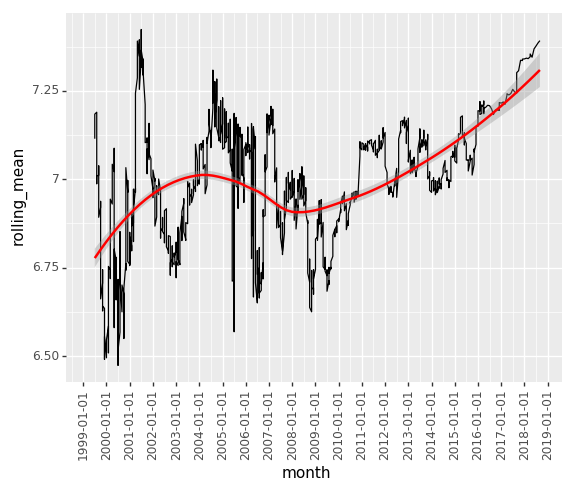

<ggplot: (8755641094194)>

In [293]:
(
    ggplot(by_date, aes('month', 'rolling_mean'))
    + geom_line()
    +scale_x_date(breaks='1 year')
    + theme(axis_text_x = element_text(angle=90))
    + geom_smooth(method='loess', color='red')
)